# Data Preprocessing
#### Run this script to proprocess all the data that will be coming in from one, many, or all of the following sources:
1. **MonkeyLogic:** (.bhv2 | .h5) behavior data *[500 or 1000Hz]*
  > * Photodiode data
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
2. **SpikeGLX:** (.meta & .bin) duplicates of analog data *[20000-30000Hz]*
  > * Photodiode data (split from ML)
  > * White Matter Camera Sync analog data (if applicable)
  > * White Matter Camera Save analog data (if applicable)
3. **WhiteMatter:** (.mp4 | .avi) video files *[60-120 fps]*
***

## Find Files
`FileContainer` will hold the relevant files listed above. <br>
* Specify `ROOT_DIR` to set the directory when prompted to select the files.
* `WARNING` printed if dates and monkeys not aligned across files

In [14]:
%load_ext autoreload
%autoreload 2
import re
import os
import sys
import cv2
import math
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from pprint import pprint
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
# Custom classes
from classes.FileContainer import FileContainer
from classes.SpikeGLX import SpikeGLX
# Custom functions
from spike_glx import read_SGLX

# pandas options
pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', None)

ROOT_DIR = '/Users/rahimhashim/My Drive/Columbia/Salzman/Monkey-Training/tasks'
file_container_obj = FileContainer(ROOT_DIR)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Select .bhv2/.h5 behavior file (i.e. 230927_Aragorn_choice.h5)
Behavior file selected: /Users/rahimhashim/Library/CloudStorage/GoogleDrive-rh2898@columbia.edu/.shortcut-targets-by-id/1LV5133wM_1EY8V6-UnKI9D7kmJwfyE52/data_Probabilistic_Reward_Airpuff_Choice/230929_Aragorn_choice.h5
  MonkeyLogic Date: 230929
  MonkeyLogic Monkey: aragorn
Select directory containing White Matter video files (i.e. 230927_Aragorn)
Video files directory selected: /Users/rahimhashim/Library/CloudStorage/GoogleDrive-rh2898@columbia.edu/.shortcut-targets-by-id/1weRx7ojG3amil91WgRMeTUVxse__Rsyt/rhAirpuff/8. Probabilistic_Reward_Airpuff_Choice/videos/230929_Aragorn
  White Matter Video Date: 230929
  White Matter Video Monkey: aragorn
Select directory containing SpikeGLX files
SpikeGLX files directory selected: /Users/rahimhashim/Library/CloudStorage/GoogleDrive-rh2898@columbia.edu/.shortcut-targets-by-id/1LV5133wM_1EY8V6-Un

***
## Convert MonkeyLogic File to Pandas
In order to run the behavior files through the preprocessing pipeline, we'll need to convert the MonkeyLogic file (either `.bhv2` or `.h5`) into a Session object which contains the following relevant attributes:
> * `session_obj.df`: pandas DataFrame with columns:
>   * `'photodiode'`: photodiode signal
>   * `'Gen2'`: WM sync signal
>   * `'Gen3'`: WM save signal
> * `'session_obj.video_path'`: directory of WM videos
> * `session_obj.monkey`: monkey name
> * `session_obj.date`: date of session (<YYMMDD>)

In [15]:
session_obj, error_dict, behavioral_code_dict = file_container_obj.ml_to_pd()

Parsing .h5 file...
Total number of trials: 539
  Choice task detected.
Parsing session data...


  0%|          | 0/539 [00:00<?, ?it/s]

  Complete.
    Correct trials: 398
    Errored trials: 141
    Session Length:  01:55:03
Creating Session Objects...
Lick threshold: 3.77 mV
  Min Values (X,Y): (-22.884,-42.777)
  Max Values (X,Y): (185.818,207.217)
  Reward Mag: 1.0
    Reward Drops: 11.0
    Reward Frequency: 1.0
    Reward Length: 200.0
  Reward Mag: 0.5
    Reward Drops: 4.0
    Reward Frequency: 1.0
    Reward Length: 150.0
  Reward Mag: 0.0
    Reward Drops: 0.0
    Reward Frequency: 0.0
    Reward Length: 0.0
  Airpuff Mag: 1.0
    Airpuff Magnitude: 1.0
    Airpuff Frequency: 1.0
  Airpuff Mag: 0.5
    Airpuff Magnitude: 0.5
    Airpuff Frequency: 1.0
  Airpuff Mag: 0.0
    Airpuff Magnitude: 0.0
    Airpuff Frequency: 0.0
Adding additional fields to session_df DataFrame...
  ['cam_frames'] field added.
  20 new fields added.
	0 rows removed due to nan valence.


In [3]:
from config.add_fields import add_fields
# save is lick
# lick is photodiode
# photodiode is save
if session_obj.monkey == 'gandalf':
  session_obj.df['cam_save_2'] = session_obj.df['cam_save'].copy()
  session_obj.df['cam_sync_2'] = session_obj.df['cam_sync'].copy()
  session_obj.df['cam_sync'] = session_obj.df['lick'].copy() # correct
  session_obj.df['cam_save'] = session_obj.df['cam_sync_2'].copy()
  session_obj.df['lick'] = session_obj.df['cam_save_2'].copy()
  del session_obj.df['cam_sync_2']
  del session_obj.df['cam_save_2']

  session_obj.df, session_obj = \
  add_fields(session_obj.df, session_obj, behavioral_code_dict)

Adding additional fields to session_df DataFrame...
   No reward magnitude column found, skipping valence assignment...
   No fractal column found, skipping fractal count...
   No blink window column found, skipping blink window...
   No pupil column found, skipping pupil pre-CS...
   No lick window column found, skipping lick window...
   No blink window column found, skipping blink window...
   No lick duration column found, skipping lick duration...
   No blink duration column found, skipping blink duration...
   No blink duration column found, skipping blink duration...
   No eye distance column found, skipping eye distance...
  ['cam_frames'] field added.
  20 new fields added.
   No behavioral analysis performed...


In [16]:
session_obj.df.head()

date  session_num  subject  trial_num  block  condition  correct  error  \
0  230929            0  aragorn          1      1          1        0      1   
1  230929            0  aragorn          2      1          1        1      0   
2  230929            0  aragorn          3      1          1        1      0   
3  230929            0  aragorn          4      1          1        1      0   
4  230929            0  aragorn          5      1          1        1      0   

   error_type                            behavioral_code_markers  \
0           2                             [9, 100, 101, 113, 18]   
1           0  [9, 100, 101, 102, 103, 104, 105, 106, 107, 10...   
2           0  [9, 100, 101, 102, 103, 104, 105, 106, 107, 10...   
3           0  [9, 100, 101, 102, 103, 104, 105, 106, 107, 10...   
4           0  [9, 100, 101, 102, 103, 104, 105, 106, 107, 10...   

                               behavioral_code_times stimuli_name_1 x_1_pos  \
0  [2.339500000005046, 2820.5403000000047, 2896.1...     _fractal_C   [0.0]   
1  [1497.8519000000006, 1630.170899999996, 1663.4...     _fractal_A   [0.0]   
2  [1656.829600000009, 1750.9104000000093, 1784.0...     _fractal_B   [0.0]   
3  [1499.4911000000002, 1601.539900000006, 1634.6...     _fractal_C   [0.0]   
4  [1500.4844000000048, 1622.1061000000248, 1655....     _fractal_A   [0.0]   

  y_1_pos stimuli_name_2 x_2_pos y_2_pos  reward_1  reward_prob_1  \
0   [0.0]     _fractal_C   [0.0]   [0.0]         0            0.0   
1   [0.0]     _fractal_A   [0.0]   [0.0]         1            1.0   
2   [0.0]     _fractal_B   [0.0]   [0.0]         1            1.0   
3   [0.0]     _fractal_C   [0.0]   [0.0]         0            0.0   
4   [0.0]     _fractal_A   [0.0]   [0.0]         1            1.0   

   reward_mag_1  reward_drops_1  reward_length_1  reward_2  reward_prob_2  \
0           0.0             0.0              0.0         0            0.0   
1           1.0            11.0            200.0         0            0.0   
2           0.5             4.0            150.0         0            0.0   
3           0.0             0.0              0.0         0            0.0   
4           1.0            11.0            200.0         0            0.0   

   reward_mag_2  airpuff_1  airpuff_prob_1  airpuff_mag_1  airpuff_2  \
0           0.0          1             1.0            0.5          0   
1           0.0          0             0.0            0.0          0   
2           0.0          0             0.0            0.0          0   
3           0.0          1             1.0            0.5          0   
4           0.0          0             0.0            0.0          0   

   airpuff_prob_2  airpuff_mag_2  \
0             0.0            0.0   
1             0.0            0.0   
2             0.0            0.0   
3             0.0            0.0   
4             0.0            0.0   

                                               eye_x  \
0  [185.81796525853645, 185.81796525853645, 185.8...   
1  [-16.164034671498406, -16.107718297090567, -16...   
2  [8.87105757143686, 8.87105757143686, 8.8710575...   
3  [9.255727872420483, 9.255727872420483, 9.26753...   
4  [185.81796525853645, 185.81796525853645, 185.8...   

                                               eye_y  \
0  [207.21715797802042, 207.21715797802042, 207.2...   
1  [15.64269982252469, 15.552038421411071, 15.552...   
2  [-13.783383184587414, -13.783383184587414, -13...   
3  [10.238520550145843, 10.238520550145843, 10.16...   
4  [207.21715797802042, 207.21715797802042, 207.2...   

                                           eye_pupil  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [8385.0, 8385.0, 8385.0, 8385.0, 8396.0, 8396....   
2  [8603.0, 8603.0, 8603.0, 8603.0, 8602.0, 8602....   
3  [8230.0, 8230.0, 8228.0, 8228.0, 8217.0, 8217....   
4  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   

                                                lick  \
0  [0.00921278980017022, 0.011185753149043257

In [70]:
import pickle
from config.h5_helper import pickler

pickler(True, os.path.dirname(file_container_obj.ml_file_path), session_obj.df, 'gandalf', 'UnityVR',
            error_dict, behavioral_code_dict)

Saving .pickle files to: /Users/rahimhashim/Library/CloudStorage/GoogleDrive-rh2898@columbia.edu/.shortcut-targets-by-id/1weRx7ojG3amil91WgRMeTUVxse__Rsyt/rhAirpuff
  Pickling 231004_gandalf_UnityVR_behave.pkl
  Total time to pickle: 0.5141 sec


*** 
## Process SpikeGLX

Assign `signal_dict` channels manually based on how you set up the PXI board. `epochs` are the MonkeyLogic eventcodes within `session_obj.df` distinguishing epochs in the task that you will reference later to break up videos based on.

In [17]:
# Manually assign the signal channel numbers
# from how you set them up on the NI PXIe-6341 board
signal_dict = {
  0: 'cam_sync',
  1: 'cam_save',
  2: 'lick',
  3: 'photodiode',
  4: 'empty'
}

# Manually assign the time epochs you care about
# which have to exist as rows in session_df
if session_obj.monkey in ['aragorn', 'bear']:
  epochs = ['Start Trial', 'Fixation On', 'CS On',	
          'Trace Start', 'Outcome Start', 'End Trial']
else:
  epochs = ['Start trial', 'End trial']
print('Epochs:')
# Print each epoch on its own line
for epoch in epochs:
  print(f'  {epoch}')

Epochs:
  Start Trial
  Fixation On
  CS On
  Trace Start
  Outcome Start
  End Trial


Always view the data you are working with before doing any type of analysis. Calling `read_SGLX` prompts a file selection tool (choose the .bin file that **must have the .meta file in the same directory as is the default for SpikeGLX output**), and `plot_channels_raw` allows for visualization of a window specified by [tStart - tEnd] **seconds**. 

Reading SGLX meta and bin files...
Select binary file
Bin File Path: /Users/rahimhashim/Library/CloudStorage/GoogleDrive-rh2898@columbia.edu/.shortcut-targets-by-id/1LV5133wM_1EY8V6-UnKI9D7kmJwfyE52/data_Probabilistic_Reward_Airpuff_Choice/aragorn_20230929_g0/aragorn_20230929_g0_t0.nidq.bin
File Name: C:/Users/Penfield/Desktop/Rahim/SpikeGLX/aragorn_20230929_g0/aragorn_20230929_g0_t0.nidq.bin
  Number of Channels: 5
  File Created: 2023-09-29T15:33:39
  File Length: 6926.260915188918
nChan: 5, nFileSamp: 146742816
 Complete.
Plotting channels...
  SpikeGLX object missing attributes (meta, chan_dict, signal_dict)
  Using input arguments instead.
Sample Rate:  21186.440678
 Channel [0]: cam_sync
  Max Val: 3342.285
  Min Val: -5.341
 Channel [1]: cam_save
  Max Val: 3347.168
  Min Val: 3281.86
 Channel [2]: lick
  Max Val: 4999.847
  Min Val: -11.597
 Channel [3]: photodiode
  Max Val: 2234.192
  Min Val: 589.447
 Channel [4]: empty
  Max Val: 0.0
  Min Val: 0.0


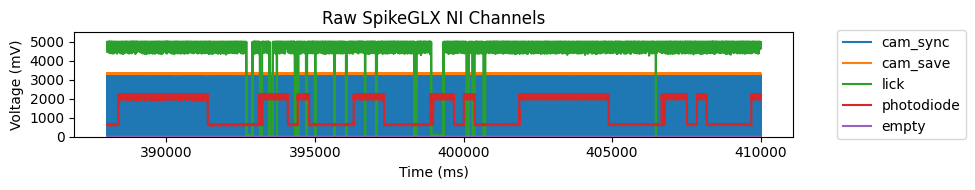

In [18]:
from spike_glx.read_SGLX import read_SGLX, plot_channels_raw

print('Reading SGLX meta and bin files...')
meta, chan_dict = read_SGLX()
print(' Complete.')
print('Plotting channels...')
plot_channels_raw(None, meta, chan_dict, signal_dict, tStart=0, tEnd=20)


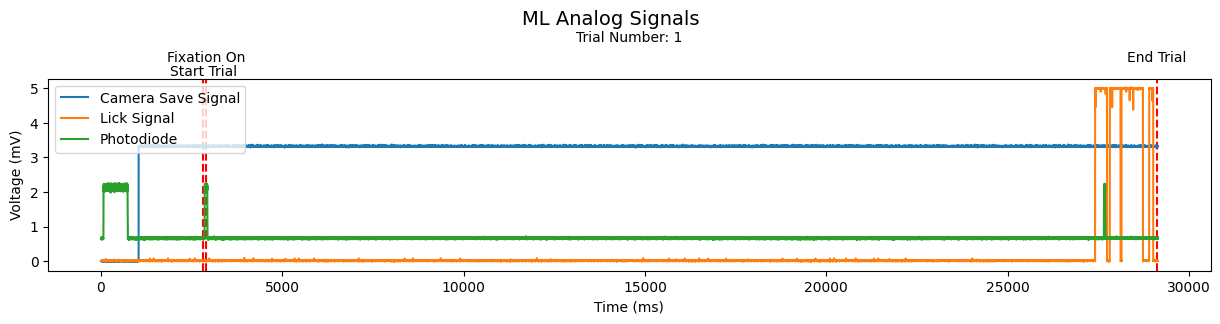

In [19]:
from spike_glx.read_SGLX import plot_analog_ML
# epochs = ['Start Trial', 'Fixation On', 'CS On',	
#           'Trace Start', 'Outcome Start', 'End Trial']
plot_analog_ML(session_obj.df, epochs, trial_num=1)

Pickled spikeglx_obj not found for: aragorn_230929
Generating new spikeglx_obj...
  Looking for SpikeGLX binary and meta file in:
  /Users/rahimhashim/Library/CloudStorage/GoogleDrive-rh2898@columbia.edu/.shortcut-targets-by-id/1LV5133wM_1EY8V6-UnKI9D7kmJwfyE52/data_Probabilistic_Reward_Airpuff_Choice
Looking for binary file in /Users/rahimhashim/Library/CloudStorage/GoogleDrive-rh2898@columbia.edu/.shortcut-targets-by-id/1LV5133wM_1EY8V6-UnKI9D7kmJwfyE52/data_Probabilistic_Reward_Airpuff_Choice
Found folder: aragorn_20230929_g0
  Found metadata file: aragorn_20230929_g0_t0.nidq.meta
  Found binary file: aragorn_20230929_g0_t0.nidq.bin
File Name: C:/Users/Penfield/Desktop/Rahim/SpikeGLX/aragorn_20230929_g0/aragorn_20230929_g0_t0.nidq.bin
  Number of Channels: 5
  File Created: 2023-09-29T15:33:39
  File Length: 6926.260915188918
nChan: 5, nFileSamp: 146742816
Number of Channels:  5
Sample Rate:  21186.440678
 Channel [0]: cam_sync
  Max Val: 3347.778
  Min Val: -7.629
 Channel [1]: cam

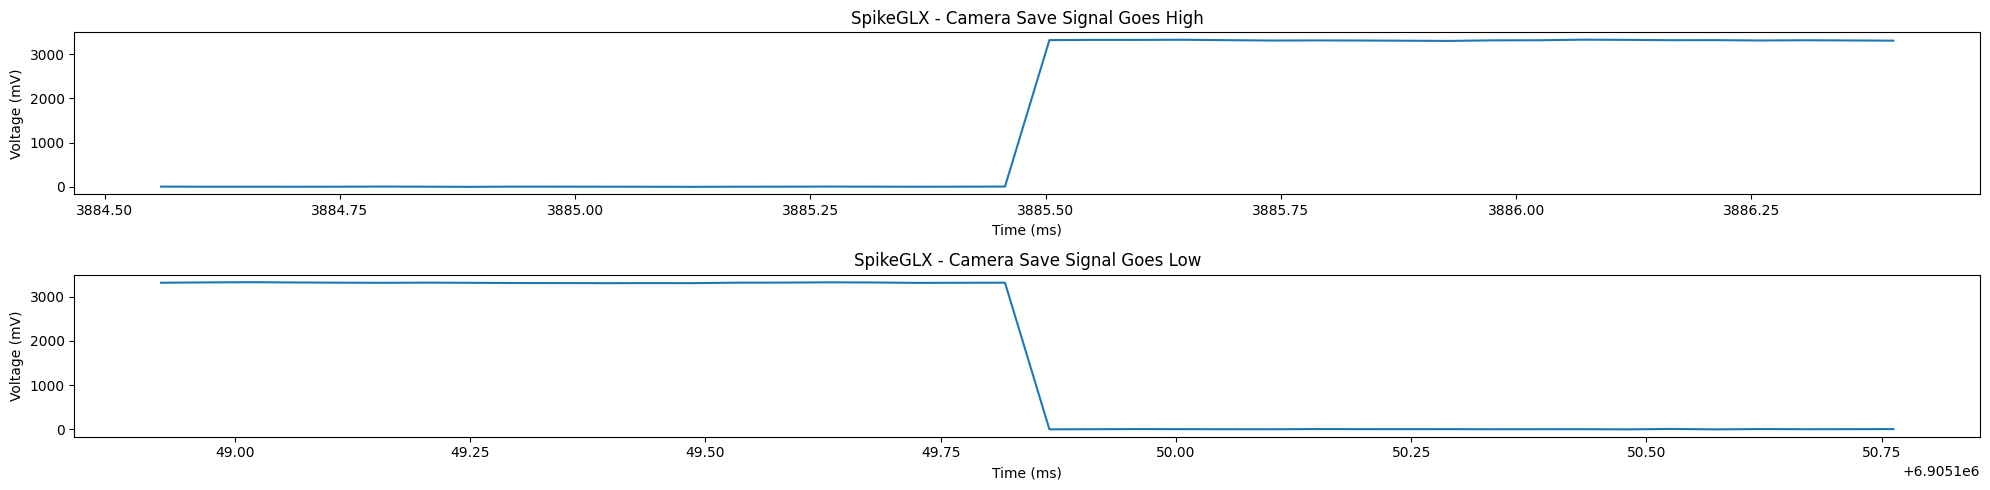

Video Folders:
['230929_Aragorn_155924', '230929_Aragorn_153333', '230929_Aragorn_153510']
Number of cameras: 4
  Camera: e3v831b | Number of videos: 6
  Camera: e3v8360 | Number of videos: 6
  Camera: e3v83ad | Number of videos: 6
  Camera: e3v83d6 | Number of videos: 6
Camera: e3v831b
  Video: e3v831b-20230929T153331-155332.avi | Frames: 144123 | FPS: 120.0 | Length (minutes): 20.02  
  Video: e3v831b-20230929T155332-161333.avi | Frames: 144124 | FPS: 120.0 | Length (minutes): 20.02  
  Video: e3v831b-20230929T161333-163334.avi | Frames: 144124 | FPS: 120.0 | Length (minutes): 20.02  
  Video: e3v831b-20230929T163334-165334.avi | Frames: 144005 | FPS: 120.0 | Length (minutes): 20.0   
  Video: e3v831b-20230929T165334-171335.avi | Frames: 144123 | FPS: 120.0 | Length (minutes): 20.02  
  Video: e3v831b-20230929T171335-172832.avi | Frames: 107645 | FPS: 120.0 | Length (minutes): 14.95  
  Total Frames: 828144
Camera: e3v8360
  Video: e3v8360-20230929T153331-155332.avi | Frames: 144123 

  0%|          | 0/539 [00:00<?, ?it/s]

Trial 1 | Correlation: 0.994 | SGLX High Time: 82320 | ML High Time: 1038
Trial 2 | Correlation: 0.994 | SGLX High Time: 29095 | ML High Time: 1573
Trial 3 | Correlation: 0.997 | SGLX High Time: 32526 | ML High Time: 1735
Trial 4 | Correlation: 0.997 | SGLX High Time: 29354 | ML High Time: 1585
Trial 5 | Correlation: 0.996 | SGLX High Time: 29358 | ML High Time: 1586
Trial 6 | Correlation: 0.997 | SGLX High Time: 32153 | ML High Time: 1718
Trial 7 | Correlation: 0.997 | SGLX High Time: 29028 | ML High Time: 1570
Trial 8 | Correlation: 0.993 | SGLX High Time: 29024 | ML High Time: 1570
Trial 9 | Correlation: 0.992 | SGLX High Time: 29040 | ML High Time: 1570
Trial 10 | Correlation: 0.993 | SGLX High Time: 28694 | ML High Time: 1554
Trial 11 | Correlation: 0.996 | SGLX High Time: 28301 | ML High Time: 1536
Trial 12 | Correlation: 0.996 | SGLX High Time: 28306 | ML High Time: 1536
Trial 13 | Correlation: 0.992 | SGLX High Time: 32625 | ML High Time: 1740
Trial 14 | Correlation: 0.998 | SG

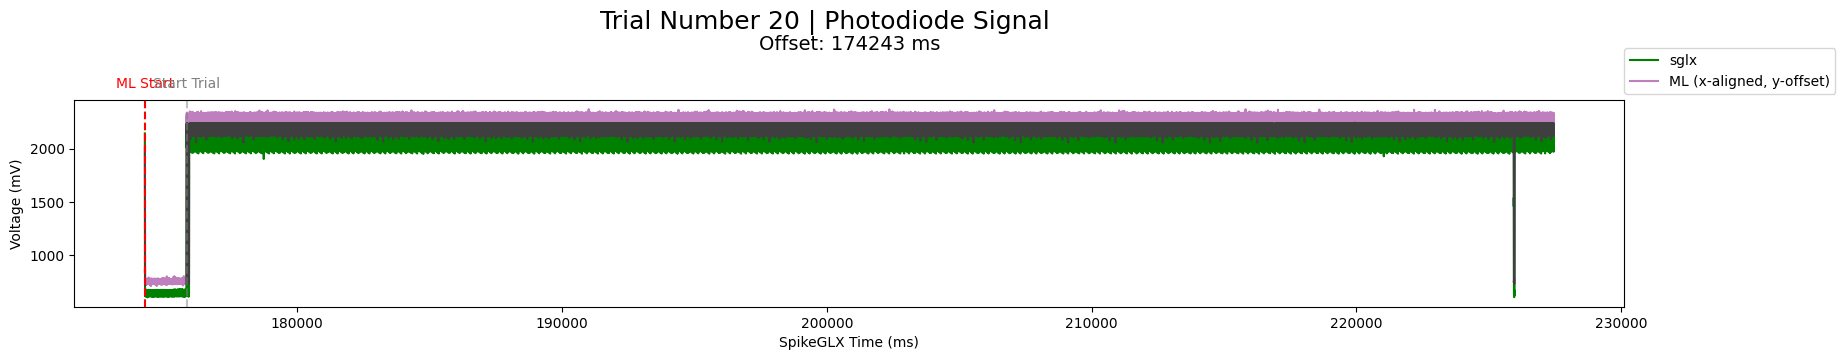

Trial 20:
  ML Cam Start           |  8      
  ML Cam End             |  53217  
  ML Cam Num Frames      |  6386   
  --------------------------------------
  SpikeGLX Trial Start   |  174243.45
  SpikeGLX Trial End     |  227462.45
  SpikeGLX Num Frames    |  6386   
  ML-SGLX Correlation: 0.94


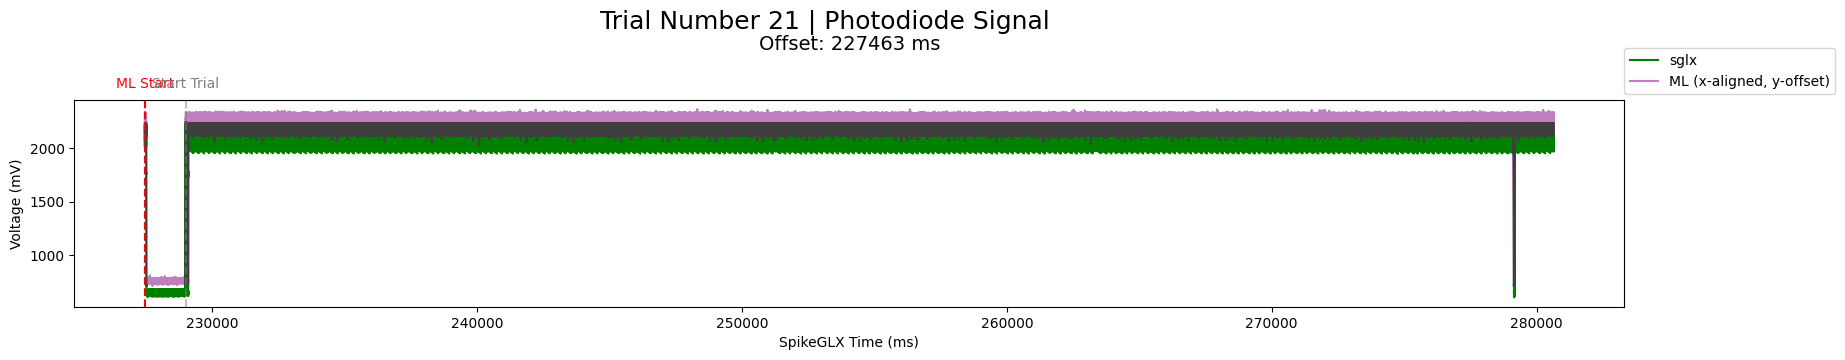

Trial 21:
  ML Cam Start           |  6      
  ML Cam End             |  53189  
  ML Cam Num Frames      |  6383   
  --------------------------------------
  SpikeGLX Trial Start   |  227462.53
  SpikeGLX Trial End     |  280652.53
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.938
Trial 22 | Correlation: 0.983 | SGLX High Time: 28328 | ML High Time: 1536
Trial 23 | Correlation: 0.996 | SGLX High Time: 29019 | ML High Time: 1570
Trial 24 | Correlation: 0.996 | SGLX High Time: 33269 | ML High Time: 1770
Trial 25 | Correlation: 0.996 | SGLX High Time: 33068 | ML High Time: 1761
Trial 26 | Correlation: 0.995 | SGLX High Time: 32624 | ML High Time: 1739
Trial 27 | Correlation: 0.996 | SGLX High Time: 28310 | ML High Time: 1536
Trial 28 | Correlation: 0.997 | SGLX High Time: 28685 | ML High Time: 1554
Trial 29 | Correlation: 0.994 | SGLX High Time: 29002 | ML High Time: 1569
Trial 30 | Correlation: 0.993 | SGLX High Time: 31492 | ML High Time: 1686
Trial 31 | Correlation: 0

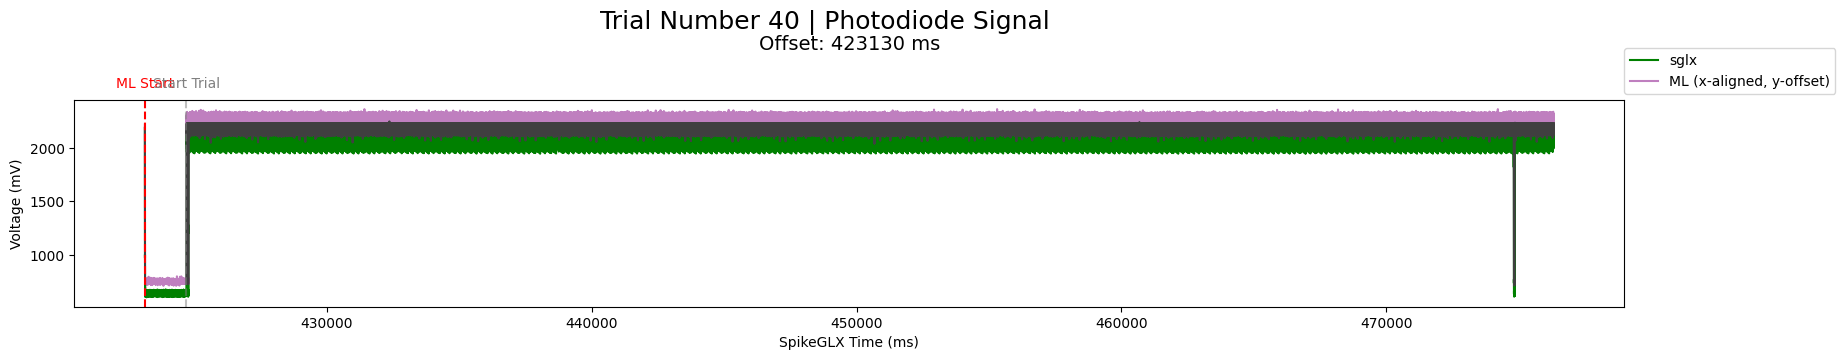

Trial 40:
  ML Cam Start           |  8      
  ML Cam End             |  53199  
  ML Cam Num Frames      |  6384   
  --------------------------------------
  SpikeGLX Trial Start   |  423129.61
  SpikeGLX Trial End     |  476330.61
  SpikeGLX Num Frames    |  6384   
  ML-SGLX Correlation: 0.938


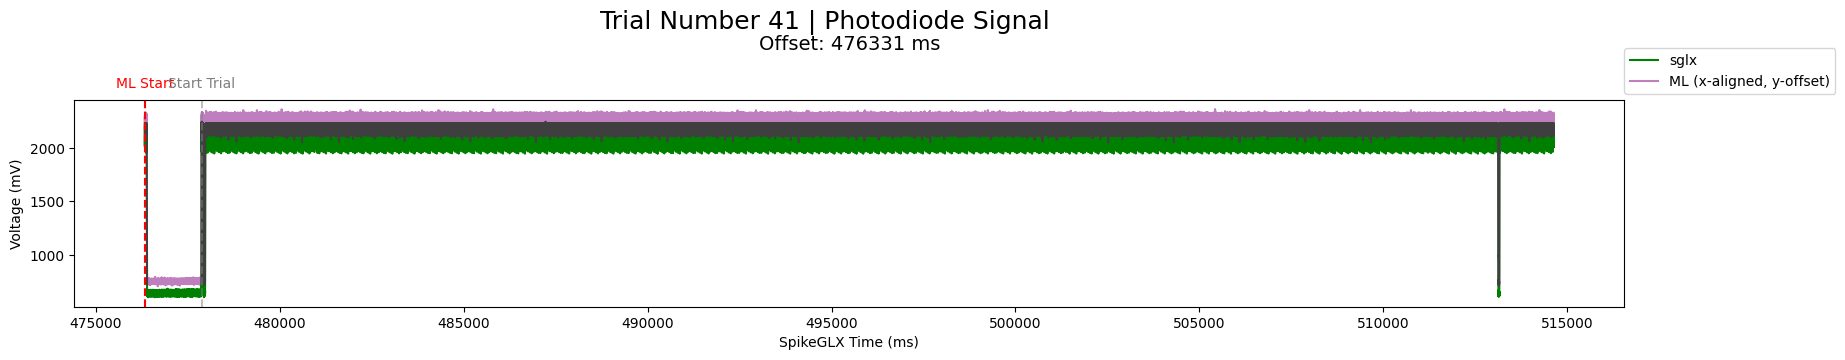

Trial 41:
  ML Cam Start           |  7      
  ML Cam End             |  38307  
  ML Cam Num Frames      |  4597   
  --------------------------------------
  SpikeGLX Trial Start   |  476331.33
  SpikeGLX Trial End     |  514641.33
  SpikeGLX Num Frames    |  4597   
  ML-SGLX Correlation: 0.954
Trial 42 | Correlation: 0.996 | SGLX High Time: 28326 | ML High Time: 1537
Trial 43 | Correlation: 0.996 | SGLX High Time: 29024 | ML High Time: 1570
Trial 44 | Correlation: 0.995 | SGLX High Time: 32617 | ML High Time: 1739
Trial 45 | Correlation: 0.996 | SGLX High Time: 32618 | ML High Time: 1739
Trial 46 | Correlation: 0.993 | SGLX High Time: 28695 | ML High Time: 1555
Trial 47 | Correlation: 0.997 | SGLX High Time: 29031 | ML High Time: 1570
Trial 48 | Correlation: 0.992 | SGLX High Time: 28691 | ML High Time: 1554
Trial 49 | Correlation: 0.996 | SGLX High Time: 28690 | ML High Time: 1554
Trial 50 | Correlation: 0.993 | SGLX High Time: 31744 | ML High Time: 1698


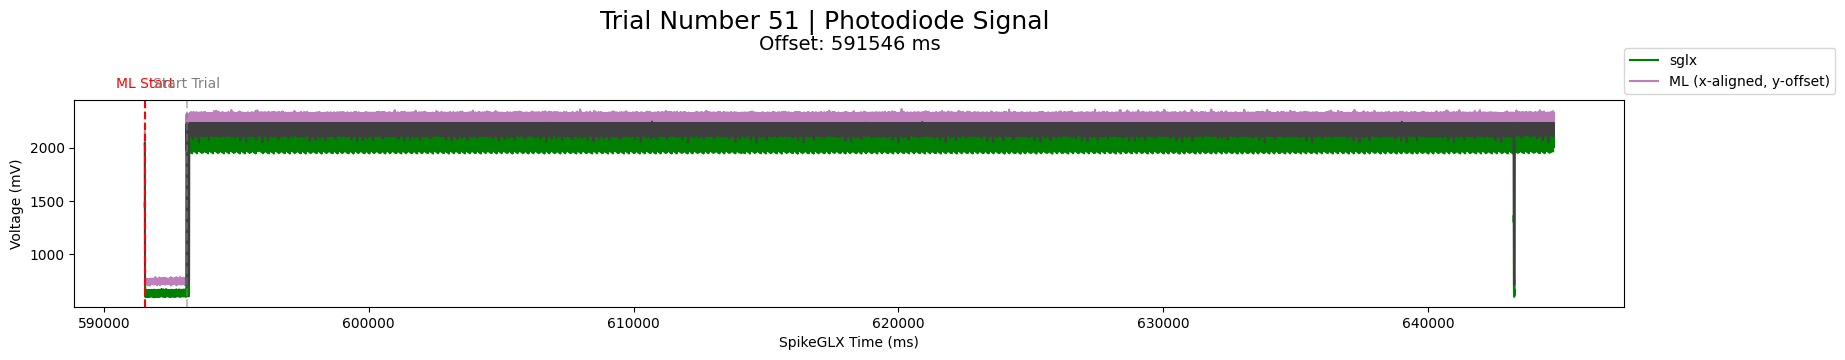

Trial 51:
  ML Cam Start           |  2      
  ML Cam End             |  53210  
  ML Cam Num Frames      |  6386   
  --------------------------------------
  SpikeGLX Trial Start   |  591545.54
  SpikeGLX Trial End     |  644760.54
  SpikeGLX Num Frames    |  6386   
  ML-SGLX Correlation: 0.94


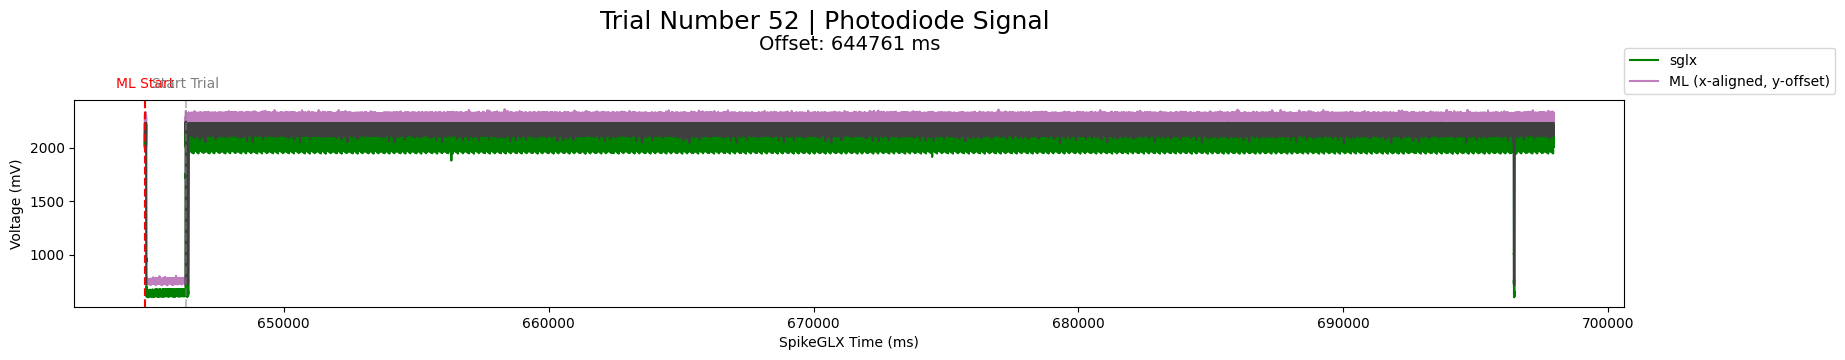

Trial 52:
  ML Cam Start           |  3      
  ML Cam End             |  53178  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  644761.19
  SpikeGLX Trial End     |  697947.19
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.937


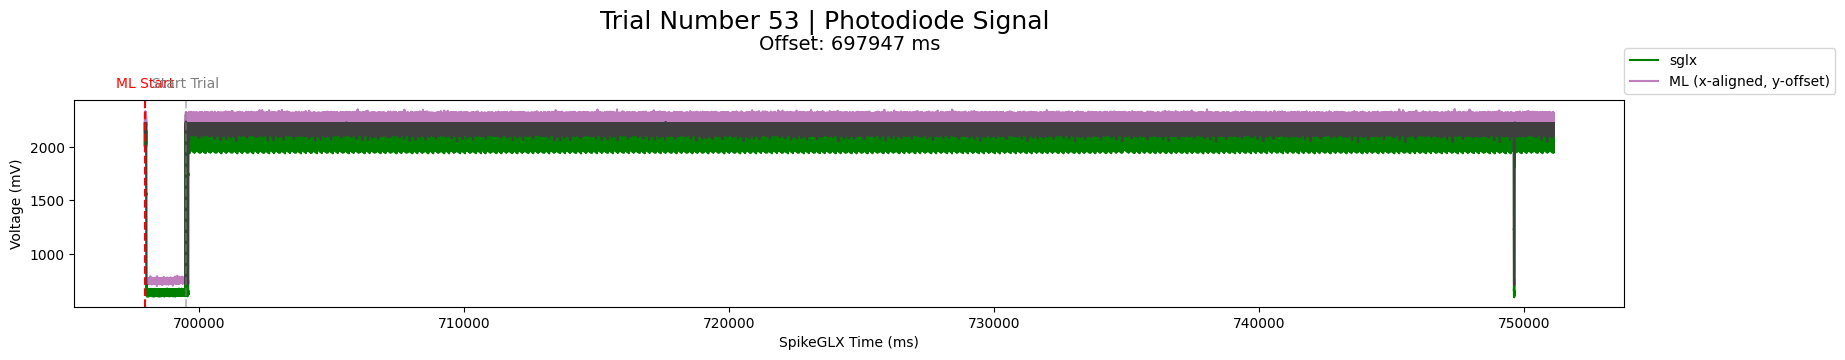

Trial 53:
  ML Cam Start           |  1      
  ML Cam End             |  53184  
  ML Cam Num Frames      |  6383   
  --------------------------------------
  SpikeGLX Trial Start   |  697947.36
  SpikeGLX Trial End     |  751132.36
  SpikeGLX Num Frames    |  6383   
  ML-SGLX Correlation: 0.938


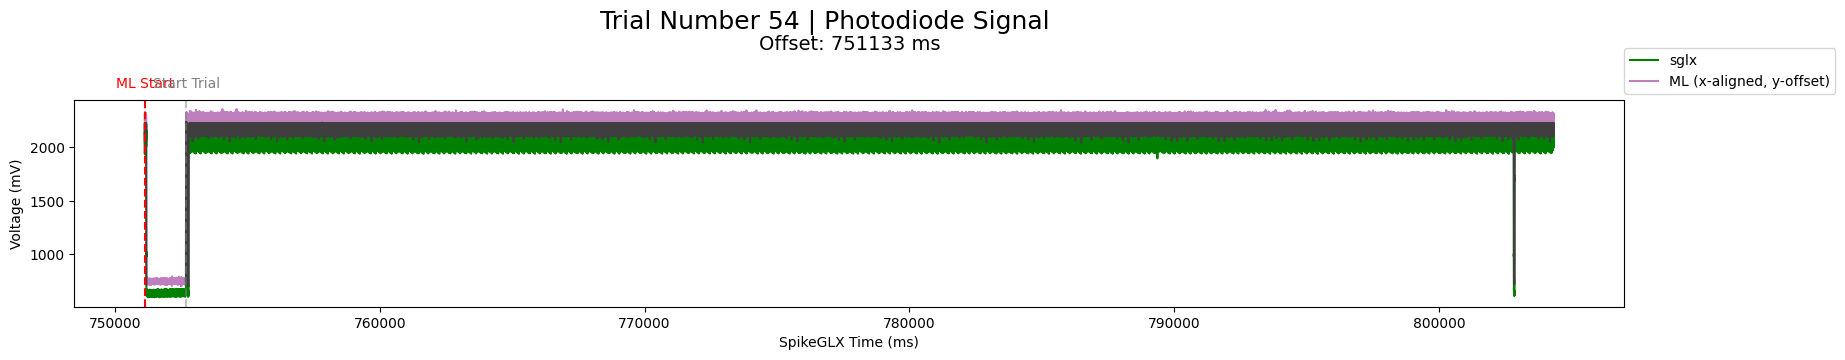

Trial 54:
  ML Cam Start           |  7      
  ML Cam End             |  53191  
  ML Cam Num Frames      |  6383   
  --------------------------------------
  SpikeGLX Trial Start   |  751133.03
  SpikeGLX Trial End     |  804331.03
  SpikeGLX Num Frames    |  6383   
  ML-SGLX Correlation: 0.935
Trial 55 | Correlation: 0.976 | SGLX High Time: 28319 | ML High Time: 1536


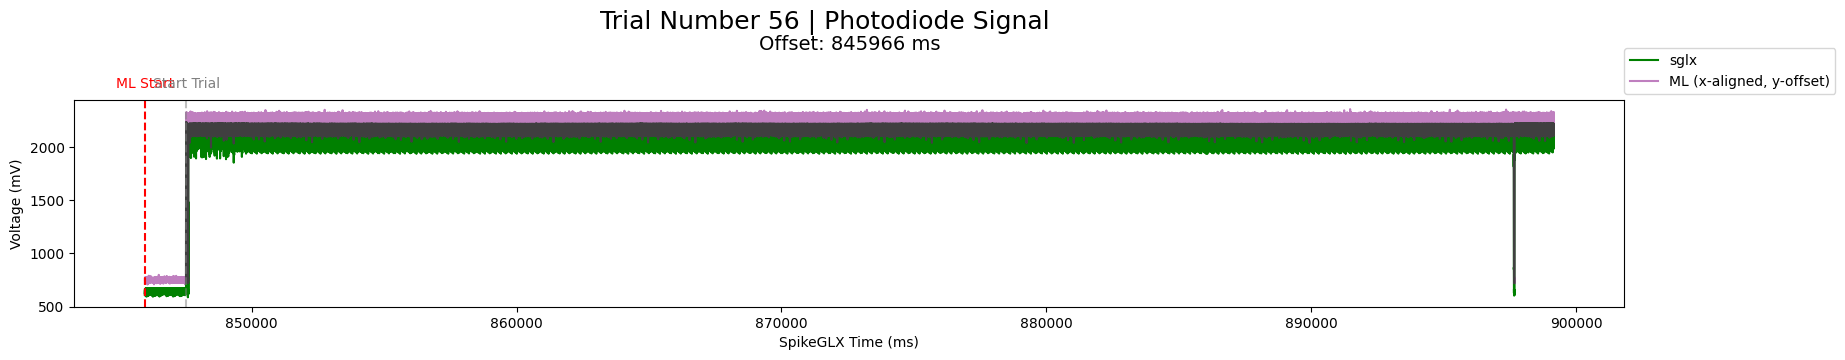

Trial 56:
  ML Cam Start           |  9      
  ML Cam End             |  53192  
  ML Cam Num Frames      |  6383   
  --------------------------------------
  SpikeGLX Trial Start   |  845966.27
  SpikeGLX Trial End     |  899166.27
  SpikeGLX Num Frames    |  6384   
  ML-SGLX Correlation: 0.937


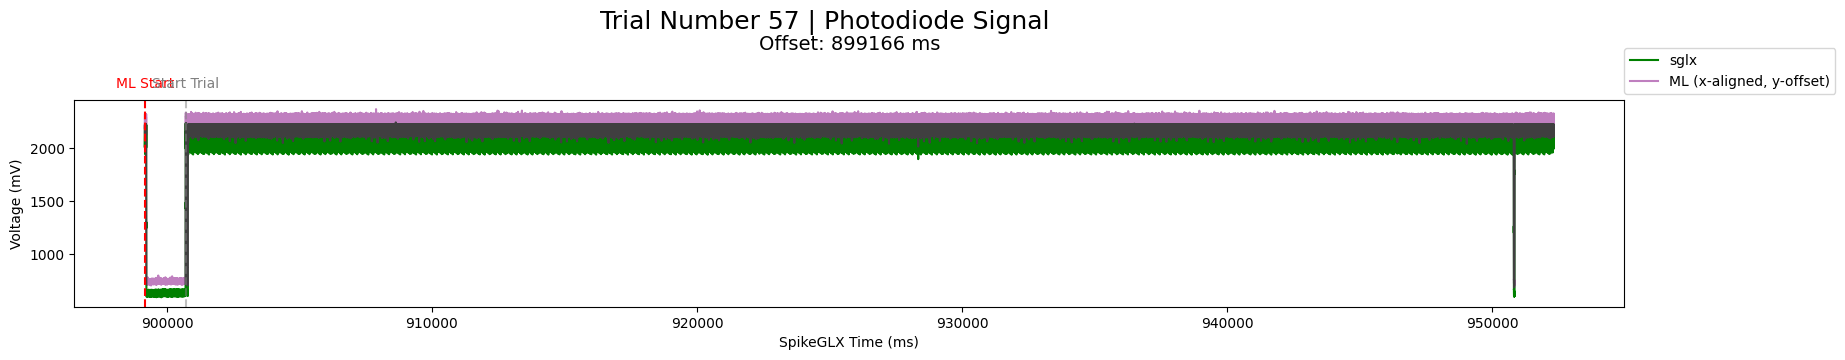

Trial 57:
  ML Cam Start           |  9      
  ML Cam End             |  53159  
  ML Cam Num Frames      |  6379   
  --------------------------------------
  SpikeGLX Trial Start   |  899166.25
  SpikeGLX Trial End     |  952331.25
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.935
Trial 58 | Correlation: 0.978 | SGLX High Time: 28327 | ML High Time: 1536
Trial 59 | Correlation: 0.993 | SGLX High Time: 28701 | ML High Time: 1555
Trial 60 | Correlation: 0.996 | SGLX High Time: 28692 | ML High Time: 1554
Trial 61 | Correlation: 0.997 | SGLX High Time: 29377 | ML High Time: 1586
Trial 62 | Correlation: 0.996 | SGLX High Time: 28682 | ML High Time: 1554
Trial 63 | Correlation: 0.997 | SGLX High Time: 32610 | ML High Time: 1739
Trial 64 | Correlation: 0.997 | SGLX High Time: 28684 | ML High Time: 1554
Trial 65 | Correlation: 0.996 | SGLX High Time: 28707 | ML High Time: 1555
Trial 66 | Correlation: 0.997 | SGLX High Time: 28702 | ML High Time: 1554
Trial 67 | Correlation: 0

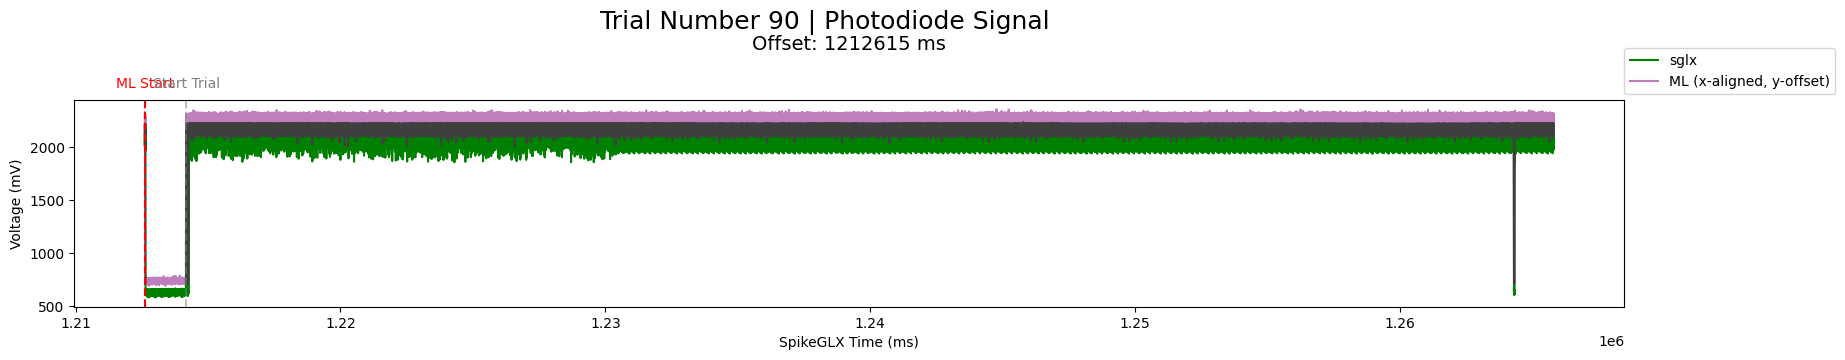

Trial 90:
  ML Cam Start           |  5      
  ML Cam End             |  53188  
  ML Cam Num Frames      |  6383   
  --------------------------------------
  SpikeGLX Trial Start   |  1212614.69
  SpikeGLX Trial End     |  1265810.69
  SpikeGLX Num Frames    |  6383   
  ML-SGLX Correlation: 0.939


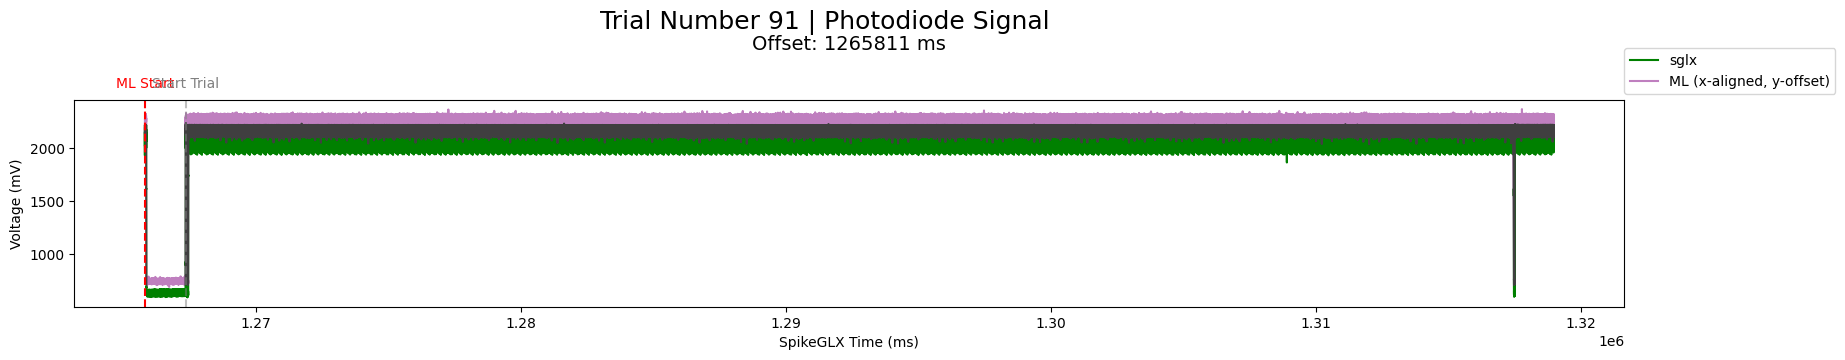

Trial 91:
  ML Cam Start           |  1      
  ML Cam End             |  53176  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  1265811.08
  SpikeGLX Trial End     |  1318992.08
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.937


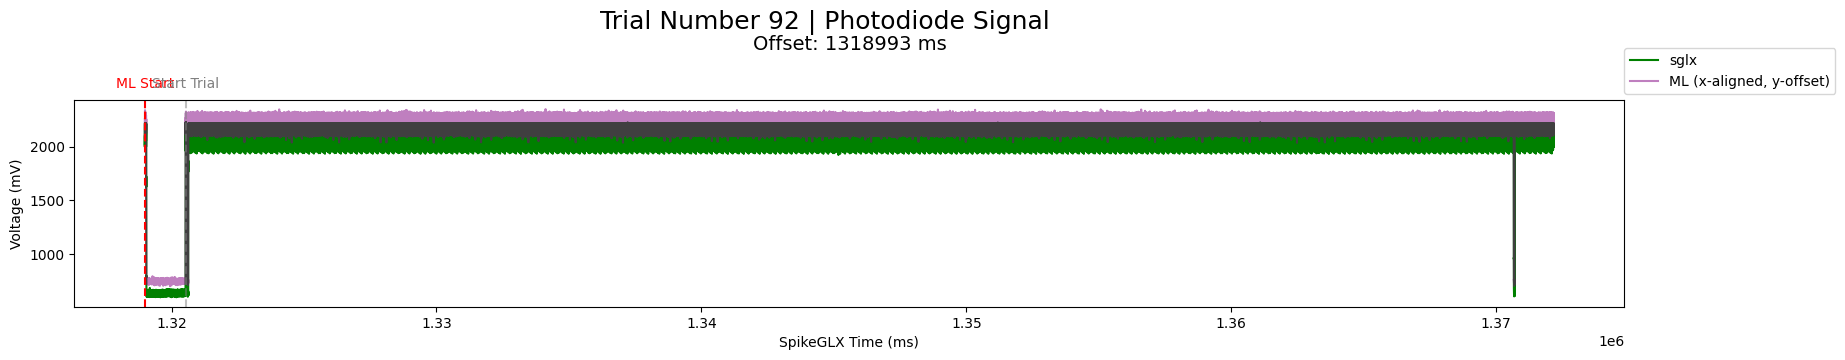

Trial 92:
  ML Cam Start           |  3      
  ML Cam End             |  53178  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  1318992.83
  SpikeGLX Trial End     |  1372177.83
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.934


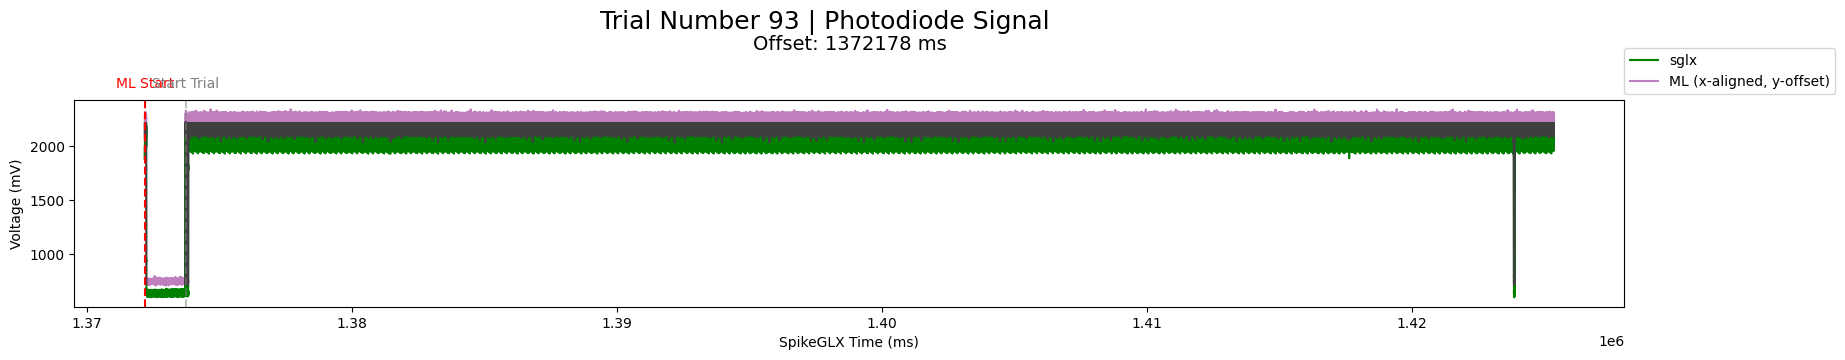

Trial 93:
  ML Cam Start           |  1      
  ML Cam End             |  53176  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  1372178.42
  SpikeGLX Trial End     |  1425359.42
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.937
Trial 94 | Correlation: 0.984 | SGLX High Time: 28326 | ML High Time: 1537
Trial 95 | Correlation: 0.995 | SGLX High Time: 28710 | ML High Time: 1554
Trial 96 | Correlation: 0.997 | SGLX High Time: 29018 | ML High Time: 1570
Trial 97 | Correlation: 0.996 | SGLX High Time: 29023 | ML High Time: 1570
Trial 98 | Correlation: 0.996 | SGLX High Time: 33060 | ML High Time: 1760
Trial 99 | Correlation: 0.998 | SGLX High Time: 29136 | ML High Time: 1575
Trial 100 | Correlation: 0.994 | SGLX High Time: 28675 | ML High Time: 1554
Trial 101 | Correlation: 0.998 | SGLX High Time: 31322 | ML High Time: 1678
Trial 102 | Correlation: 0.996 | SGLX High Time: 28689 | ML High Time: 1554
Trial 103 | Correlat

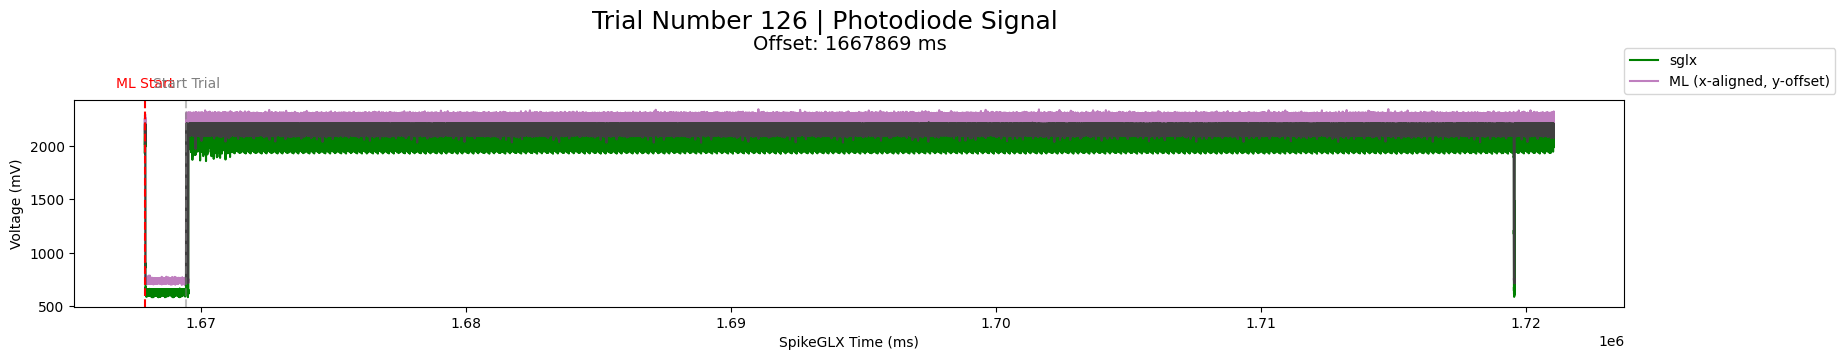

Trial 126:
  ML Cam Start           |  5      
  ML Cam End             |  53196  
  ML Cam Num Frames      |  6384   
  --------------------------------------
  SpikeGLX Trial Start   |  1667868.94
  SpikeGLX Trial End     |  1721065.94
  SpikeGLX Num Frames    |  6383   
  ML-SGLX Correlation: 0.938


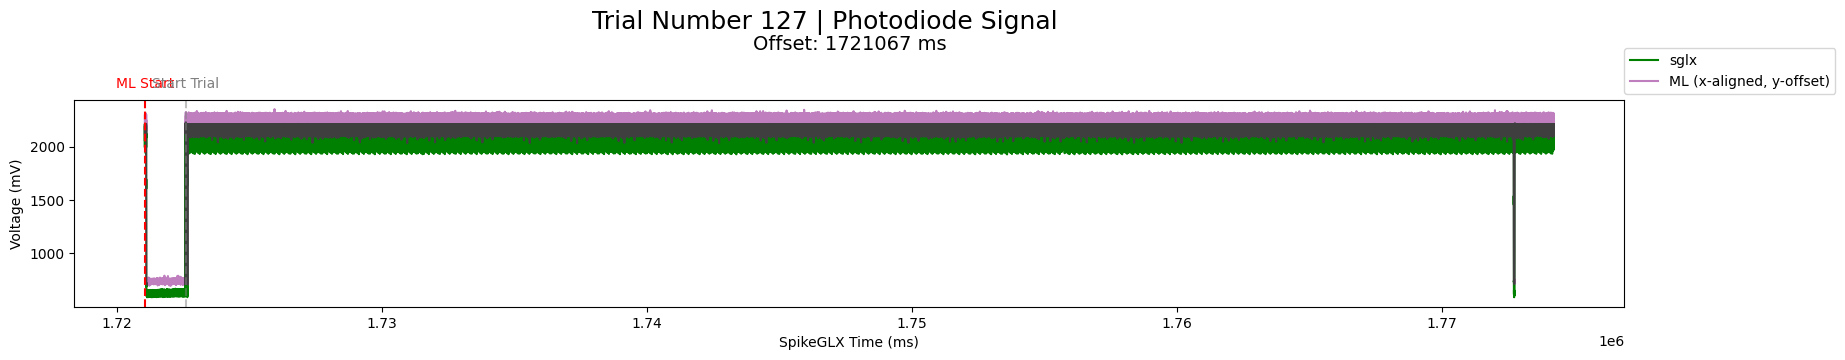

Trial 127:
  ML Cam Start           |  8      
  ML Cam End             |  53166  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  1721067.27
  SpikeGLX Trial End     |  1774235.27
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.935


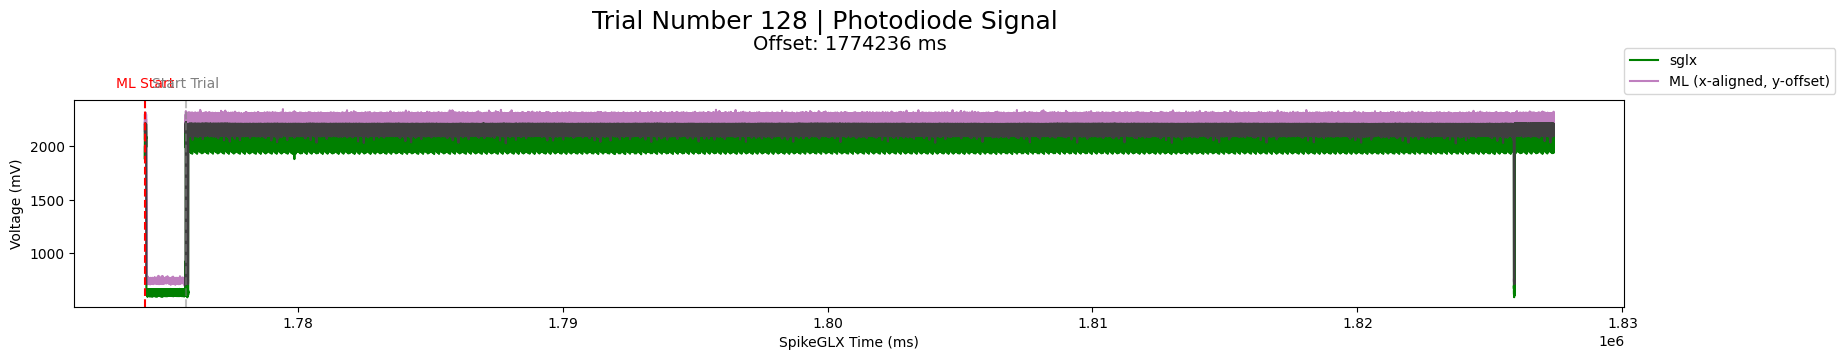

Trial 128:
  ML Cam Start           |  6      
  ML Cam End             |  53173  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  1774235.62
  SpikeGLX Trial End     |  1827416.62
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.935


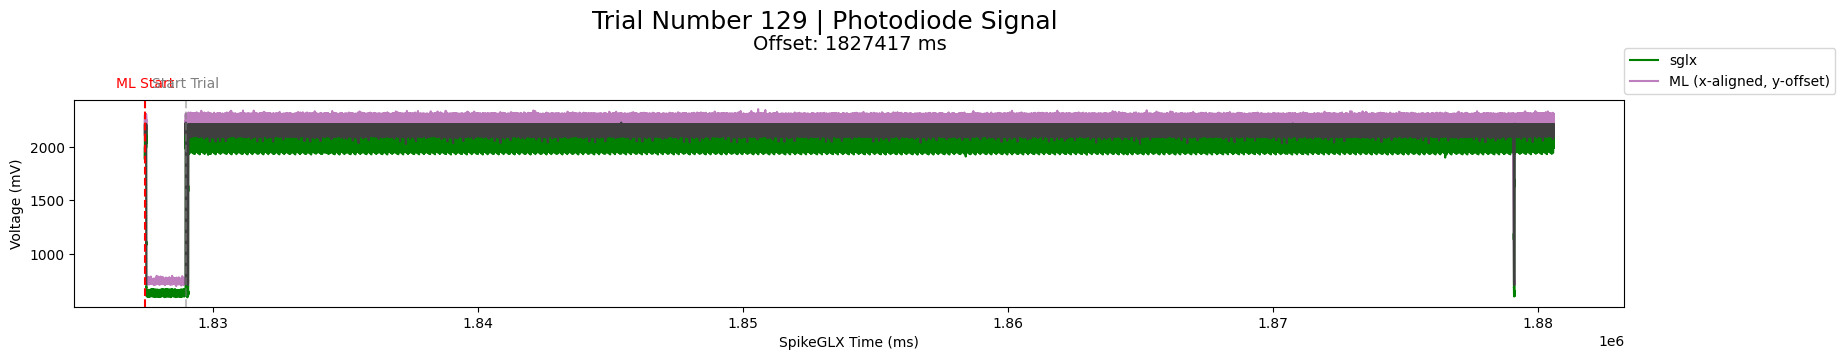

Trial 129:
  ML Cam Start           |  9      
  ML Cam End             |  53175  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  1827417.27
  SpikeGLX Trial End     |  1880599.27
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.935
Trial 130 | Correlation: 0.98 | SGLX High Time: 28332 | ML High Time: 1537
Trial 131 | Correlation: 0.995 | SGLX High Time: 28687 | ML High Time: 1554
Trial 132 | Correlation: 0.994 | SGLX High Time: 28705 | ML High Time: 1555
Trial 133 | Correlation: 0.993 | SGLX High Time: 31850 | ML High Time: 1703
Trial 134 | Correlation: 0.997 | SGLX High Time: 29032 | ML High Time: 1570
Trial 135 | Correlation: 0.995 | SGLX High Time: 28311 | ML High Time: 1536
Trial 136 | Correlation: 0.992 | SGLX High Time: 28685 | ML High Time: 1554
Trial 137 | Correlation: 0.997 | SGLX High Time: 29033 | ML High Time: 1570
Trial 138 | Correlation: 0.997 | SGLX High Time: 28313 | ML High Time: 1536
Trial 139 | Co

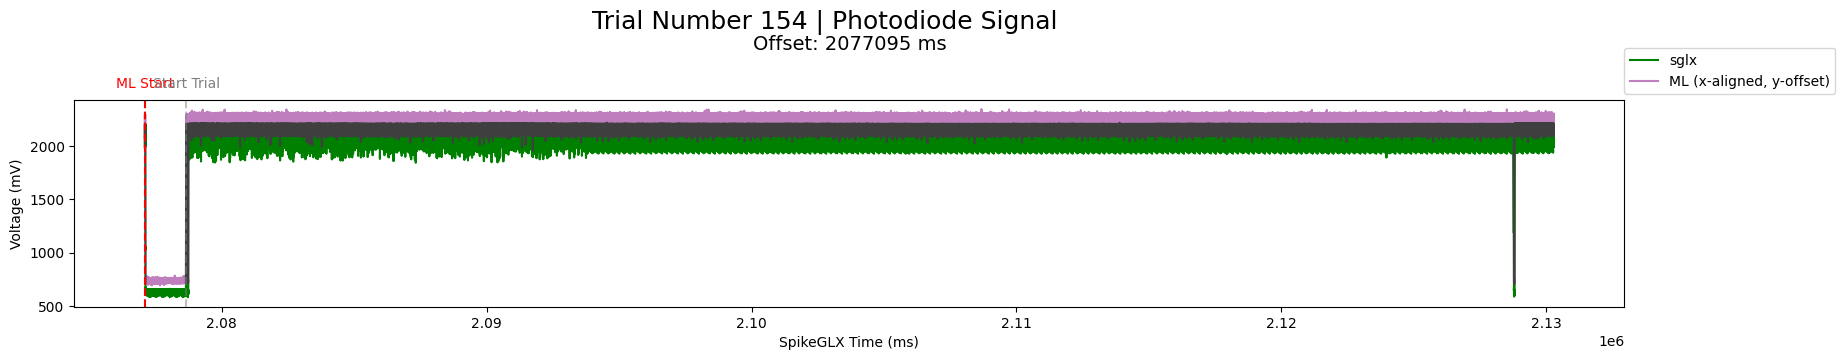

Trial 154:
  ML Cam Start           |  7      
  ML Cam End             |  53199  
  ML Cam Num Frames      |  6384   
  --------------------------------------
  SpikeGLX Trial Start   |  2077095.06
  SpikeGLX Trial End     |  2130295.06
  SpikeGLX Num Frames    |  6384   
  ML-SGLX Correlation: 0.937


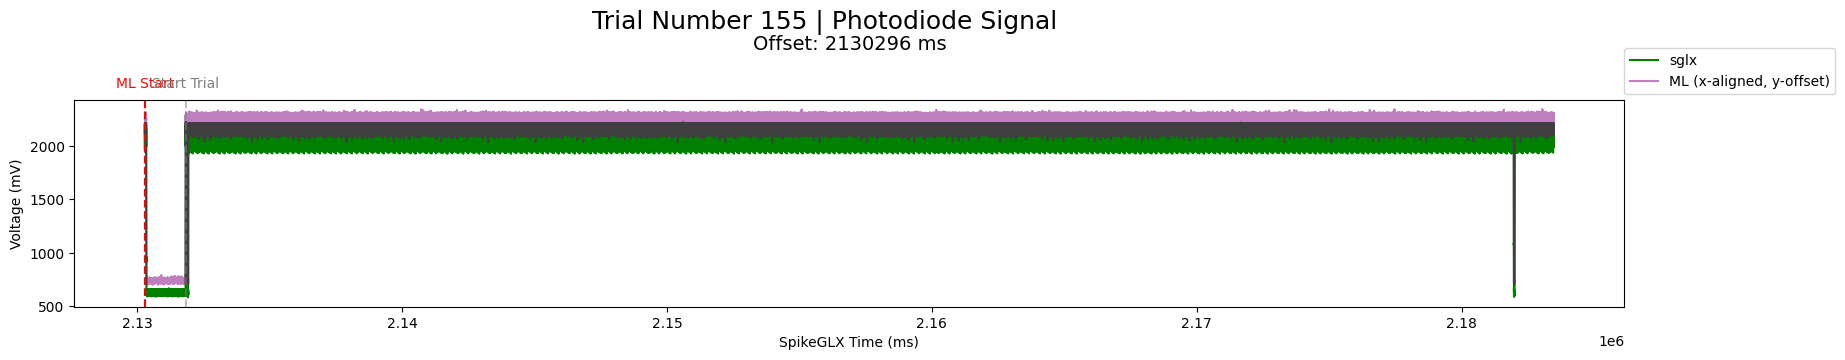

Trial 155:
  ML Cam Start           |  7      
  ML Cam End             |  53174  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  2130295.65
  SpikeGLX Trial End     |  2183477.65
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.937


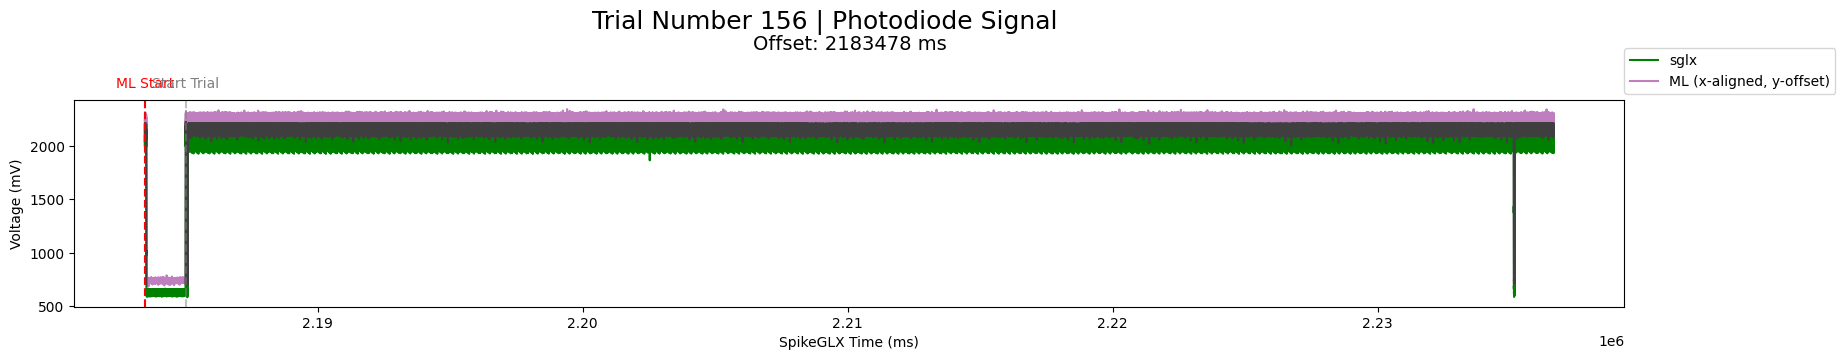

Trial 156:
  ML Cam Start           |  9      
  ML Cam End             |  53167  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  2183478.3
  SpikeGLX Trial End     |  2236647.3
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.938
Trial 157 | Correlation: 0.975 | SGLX High Time: 28325 | ML High Time: 1536
Trial 158 | Correlation: 0.995 | SGLX High Time: 28313 | ML High Time: 1536
Trial 159 | Correlation: 0.992 | SGLX High Time: 29003 | ML High Time: 1569
Trial 160 | Correlation: 0.997 | SGLX High Time: 29128 | ML High Time: 1575
Trial 161 | Correlation: 0.995 | SGLX High Time: 28697 | ML High Time: 1554
Trial 162 | Correlation: 0.993 | SGLX High Time: 34353 | ML High Time: 1822
Trial 163 | Correlation: 0.996 | SGLX High Time: 29032 | ML High Time: 1570
Trial 164 | Correlation: 0.995 | SGLX High Time: 28684 | ML High Time: 1554
Trial 165 | Correlation: 0.993 | SGLX High Time: 28702 | ML High Time: 1554
Trial 166 | Cor

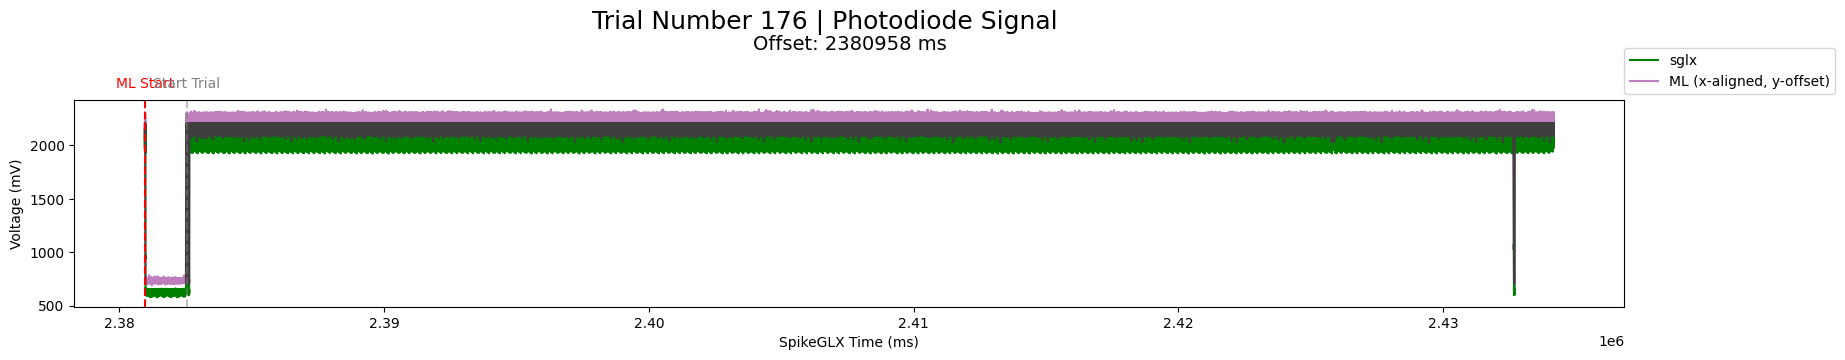

Trial 176:
  ML Cam Start           |  7      
  ML Cam End             |  53223  
  ML Cam Num Frames      |  6387   
  --------------------------------------
  SpikeGLX Trial Start   |  2380957.9
  SpikeGLX Trial End     |  2434181.9
  SpikeGLX Num Frames    |  6387   
  ML-SGLX Correlation: 0.937
Trial 177 | Correlation: 0.975 | SGLX High Time: 28312 | ML High Time: 1536
Trial 178 | Correlation: 0.993 | SGLX High Time: 28699 | ML High Time: 1554
Trial 179 | Correlation: 0.994 | SGLX High Time: 28303 | ML High Time: 1536
Trial 180 | Correlation: 0.997 | SGLX High Time: 32204 | ML High Time: 1720
Trial 181 | Correlation: 0.995 | SGLX High Time: 28679 | ML High Time: 1554
Trial 182 | Correlation: 0.994 | SGLX High Time: 28688 | ML High Time: 1554
Trial 183 | Correlation: 0.997 | SGLX High Time: 31857 | ML High Time: 1703
Trial 184 | Correlation: 0.996 | SGLX High Time: 28693 | ML High Time: 1554
Trial 185 | Correlation: 0.996 | SGLX High Time: 28677 | ML High Time: 1554
Trial 186 | Cor

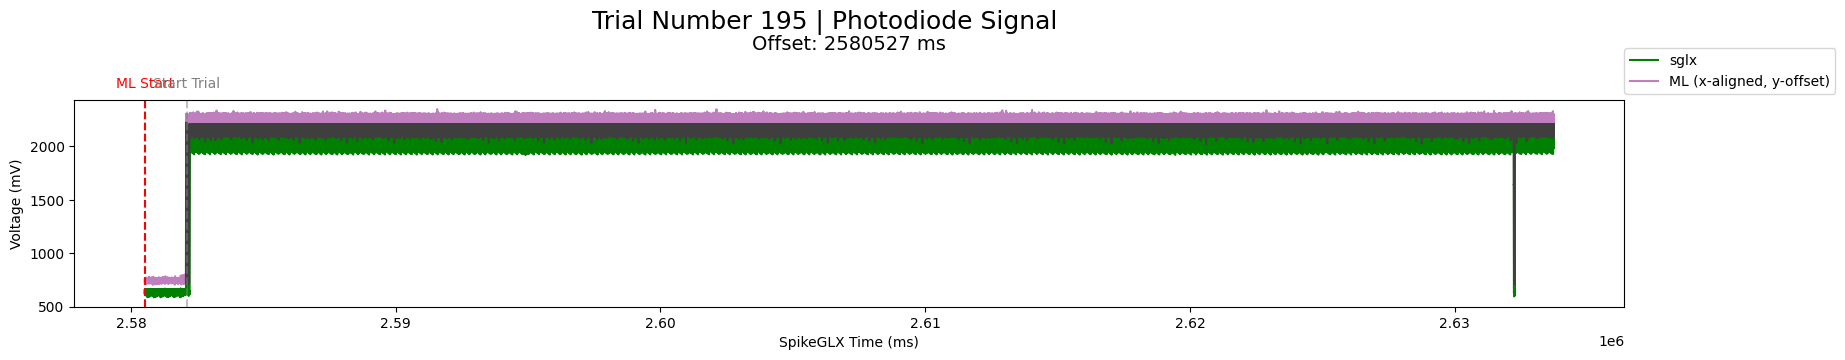

Trial 195:
  ML Cam Start           |  6      
  ML Cam End             |  53214  
  ML Cam Num Frames      |  6386   
  --------------------------------------
  SpikeGLX Trial Start   |  2580526.81
  SpikeGLX Trial End     |  2633746.81
  SpikeGLX Num Frames    |  6386   
  ML-SGLX Correlation: 0.937


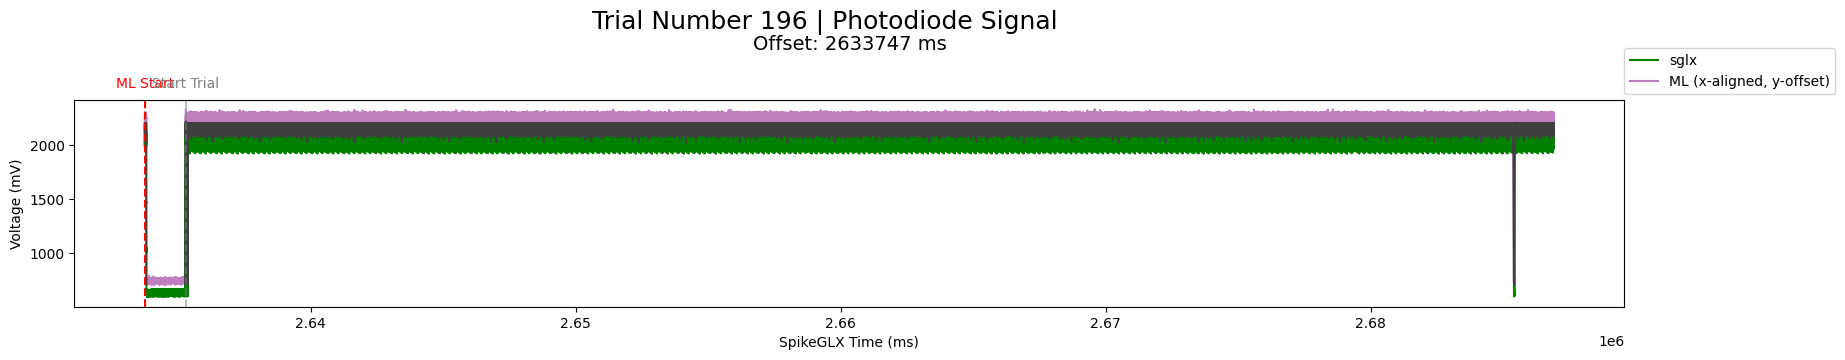

Trial 196:
  ML Cam Start           |  3      
  ML Cam End             |  53161  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  2633746.71
  SpikeGLX Trial End     |  2686911.71
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.934


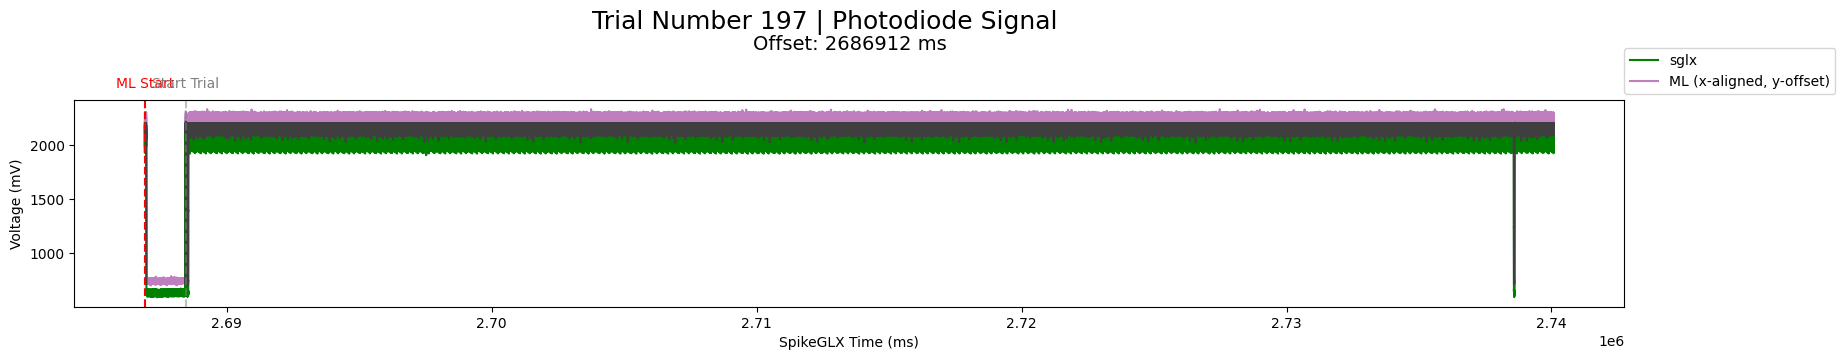

Trial 197:
  ML Cam Start           |  4      
  ML Cam End             |  53179  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  2686912.46
  SpikeGLX Trial End     |  2740093.46
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.937


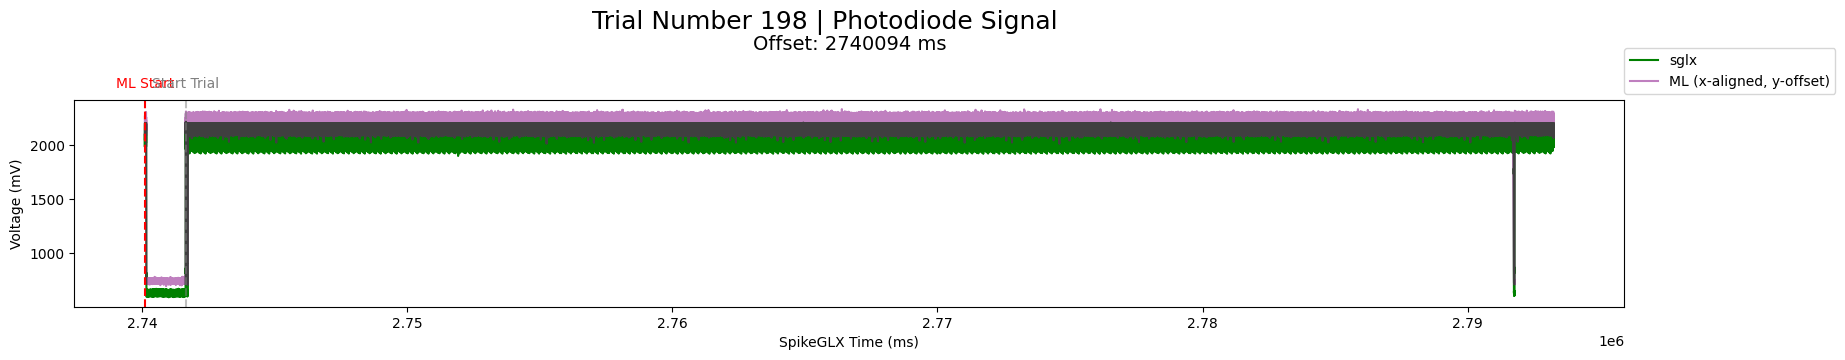

Trial 198:
  ML Cam Start           |  7      
  ML Cam End             |  53157  
  ML Cam Num Frames      |  6379   
  --------------------------------------
  SpikeGLX Trial Start   |  2740094.16
  SpikeGLX Trial End     |  2793259.16
  SpikeGLX Num Frames    |  6379   
  ML-SGLX Correlation: 0.934


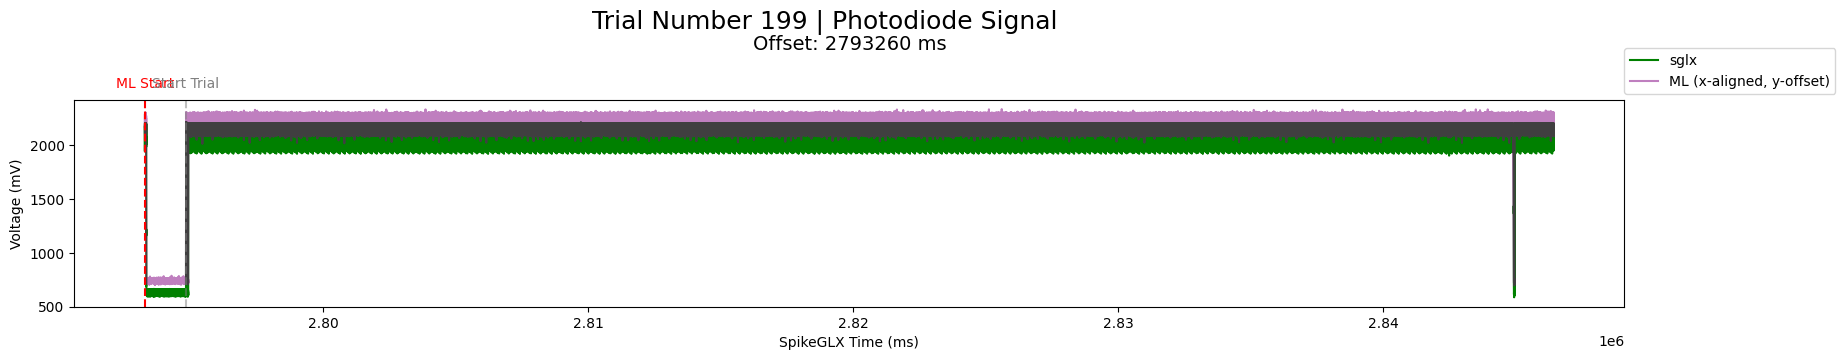

Trial 199:
  ML Cam Start           |  8      
  ML Cam End             |  53175  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  2793260.01
  SpikeGLX Trial End     |  2846442.01
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.937


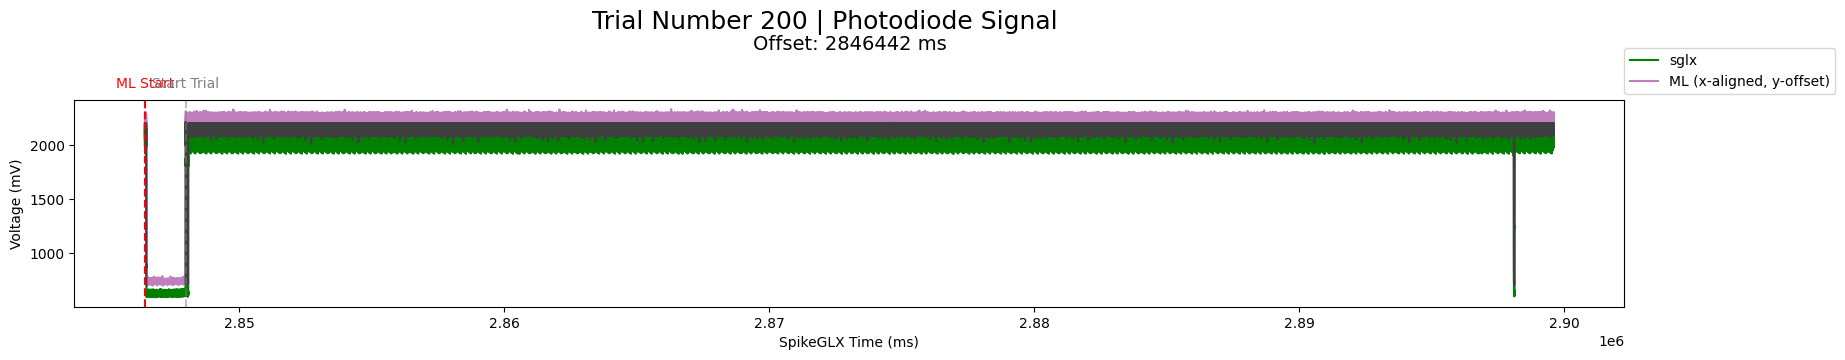

Trial 200:
  ML Cam Start           |  1      
  ML Cam End             |  53176  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  2846442.19
  SpikeGLX Trial End     |  2899624.19
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.938


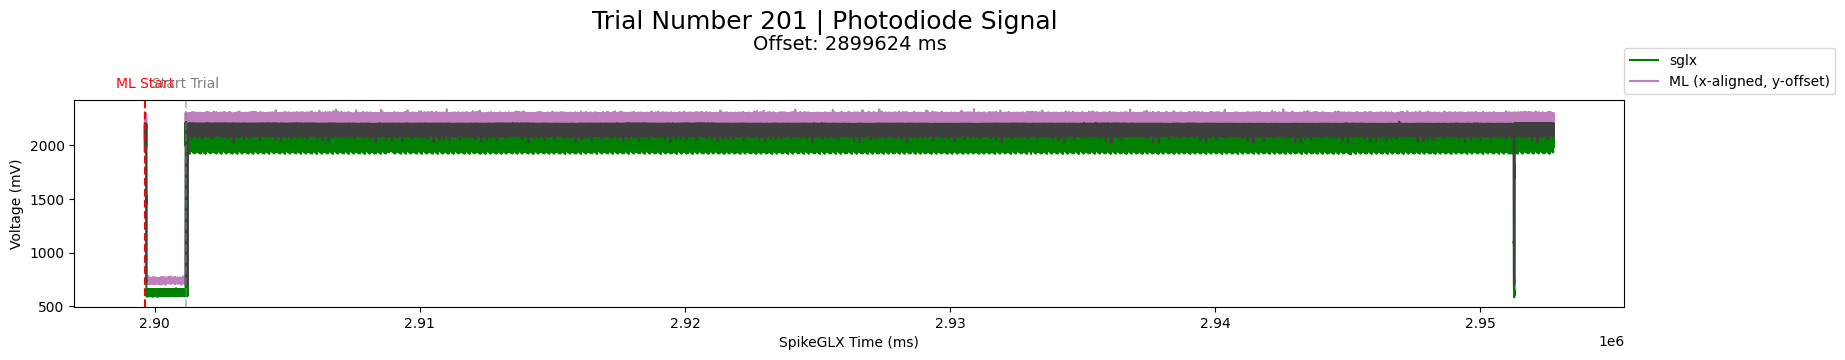

Trial 201:
  ML Cam Start           |  2      
  ML Cam End             |  53161  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  2899624.17
  SpikeGLX Trial End     |  2952789.17
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.935


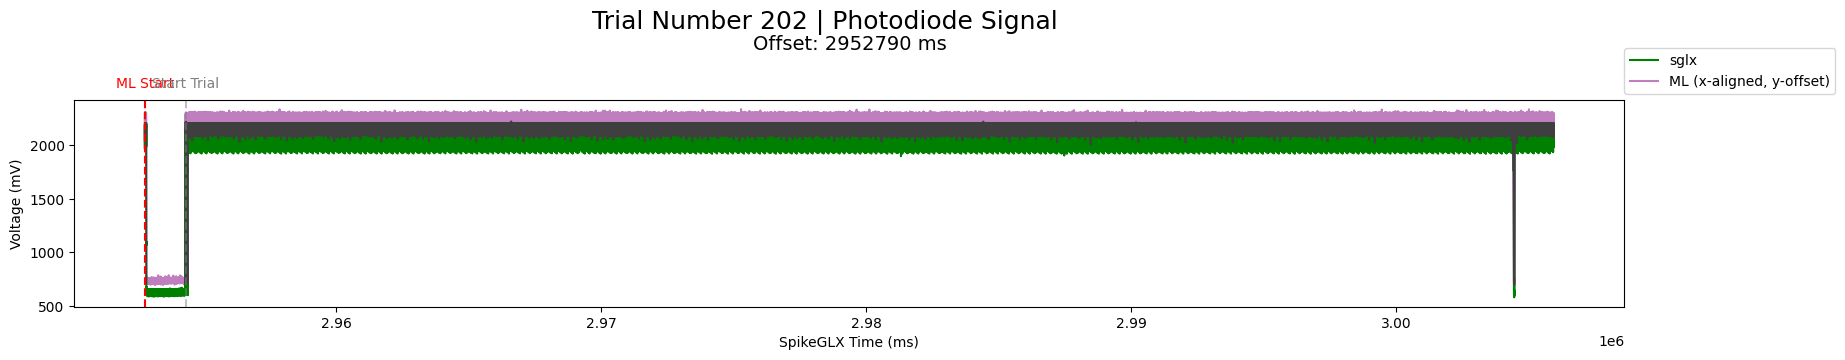

Trial 202:
  ML Cam Start           |  4      
  ML Cam End             |  53162  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  2952789.73
  SpikeGLX Trial End     |  3005953.73
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.933
Trial 203 | Correlation: 0.973 | SGLX High Time: 28348 | ML High Time: 1537
Trial 204 | Correlation: 0.994 | SGLX High Time: 29386 | ML High Time: 1587
Trial 205 | Correlation: 0.995 | SGLX High Time: 29033 | ML High Time: 1570
Trial 206 | Correlation: 0.995 | SGLX High Time: 29030 | ML High Time: 1570
Trial 207 | Correlation: 0.997 | SGLX High Time: 29014 | ML High Time: 1569
Trial 208 | Correlation: 0.996 | SGLX High Time: 29022 | ML High Time: 1570
Trial 209 | Correlation: 0.998 | SGLX High Time: 32184 | ML High Time: 1719
Trial 210 | Correlation: 0.992 | SGLX High Time: 28684 | ML High Time: 1554
Trial 211 | Correlation: 0.995 | SGLX High Time: 29020 | ML High Time: 1569
Trial 212 | C

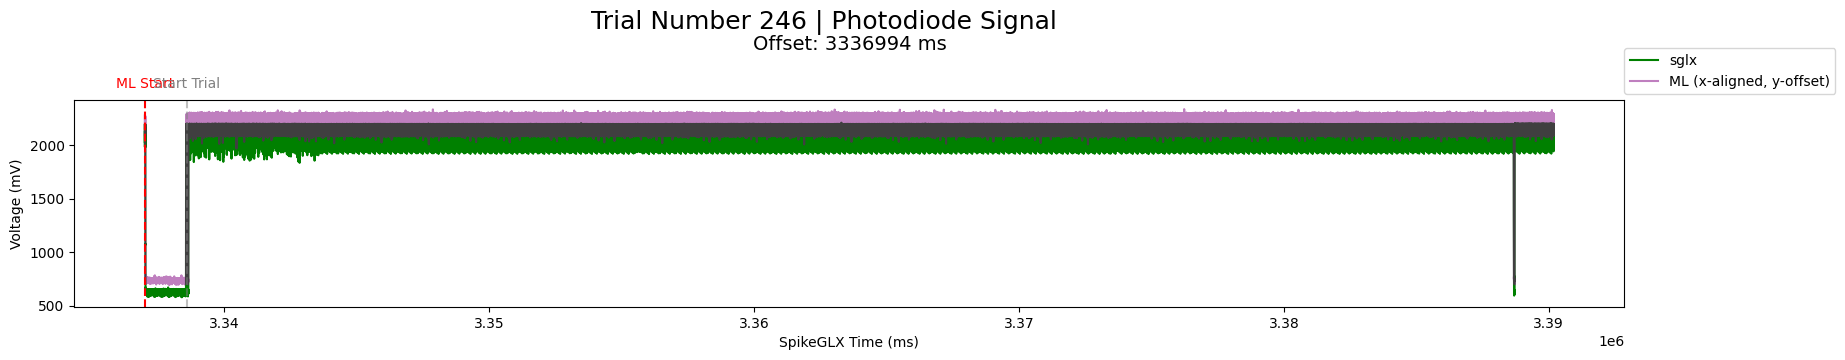

Trial 246:
  ML Cam Start           |  4      
  ML Cam End             |  53195  
  ML Cam Num Frames      |  6384   
  --------------------------------------
  SpikeGLX Trial Start   |  3336994.18
  SpikeGLX Trial End     |  3390197.18
  SpikeGLX Num Frames    |  6384   
  ML-SGLX Correlation: 0.936


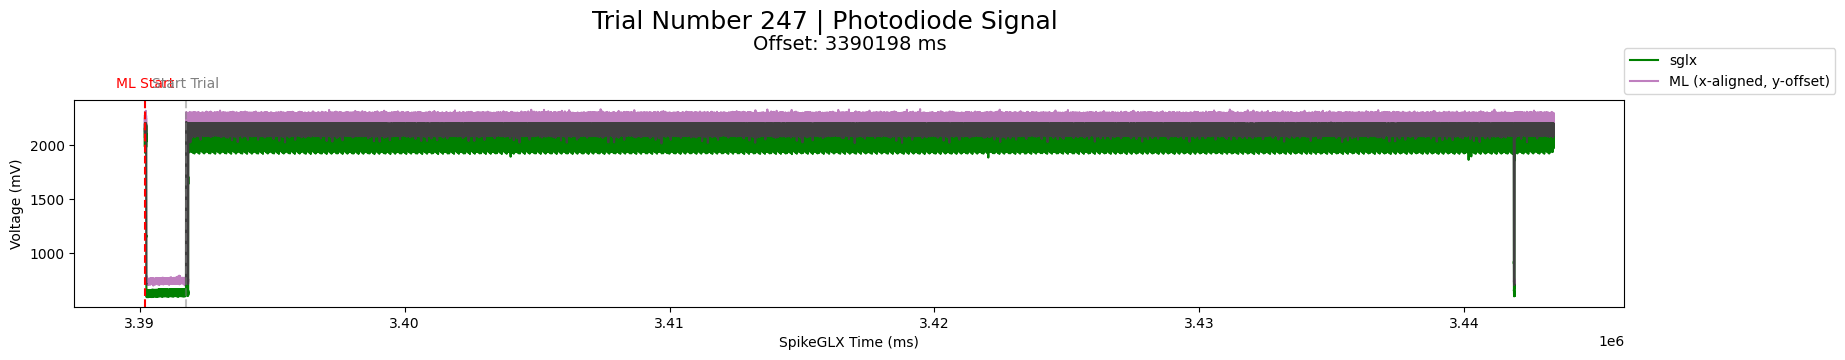

Trial 247:
  ML Cam Start           |  1      
  ML Cam End             |  53176  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  3390197.61
  SpikeGLX Trial End     |  3443379.61
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.935


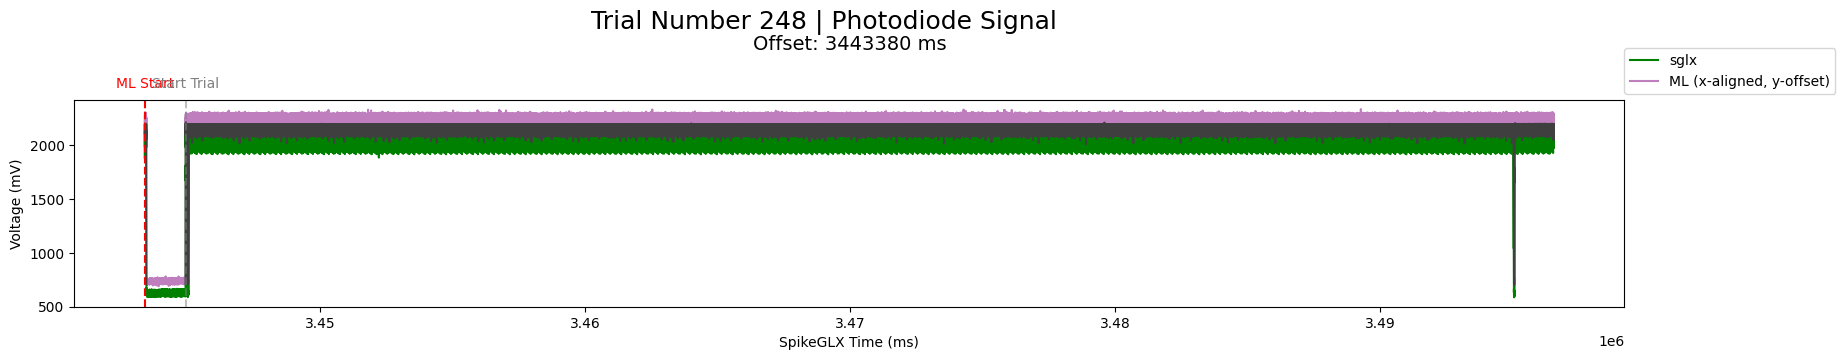

Trial 248:
  ML Cam Start           |  2      
  ML Cam End             |  53177  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  3443380.25
  SpikeGLX Trial End     |  3496562.25
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.934


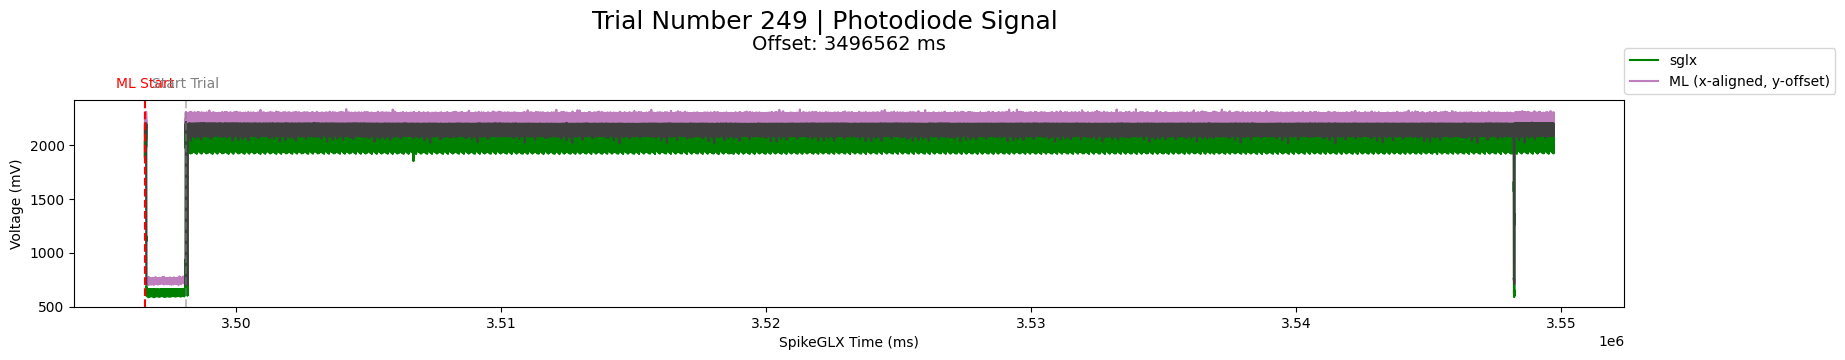

Trial 249:
  ML Cam Start           |  3      
  ML Cam End             |  53162  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  3496562.29
  SpikeGLX Trial End     |  3549727.29
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.936


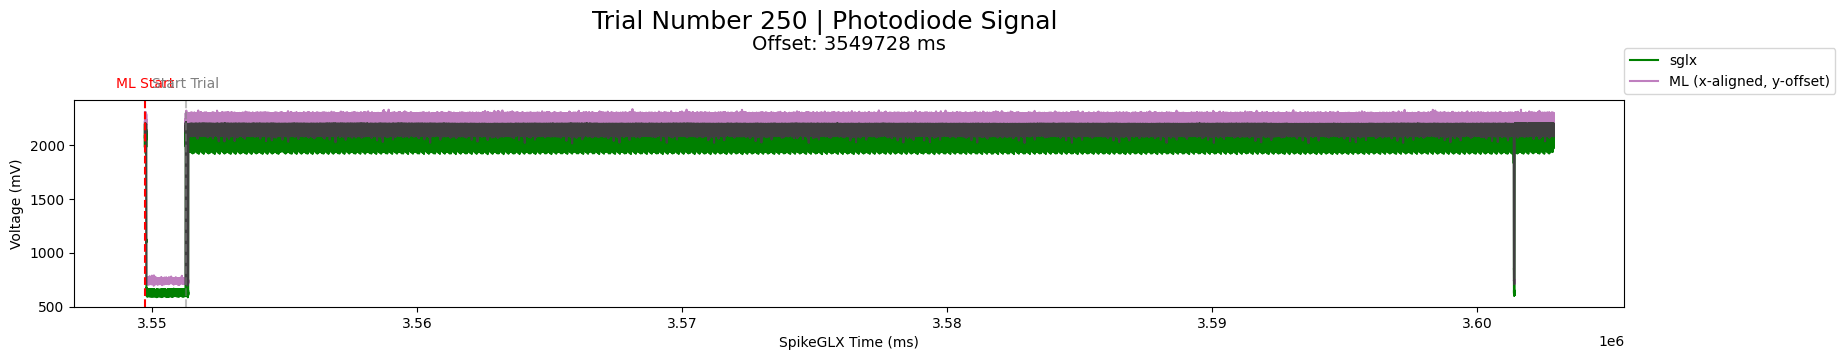

Trial 250:
  ML Cam Start           |  5      
  ML Cam End             |  53180  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  3549727.89
  SpikeGLX Trial End     |  3602908.89
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.938
Trial 251 | Correlation: 0.973 | SGLX High Time: 28340 | ML High Time: 1537
Trial 252 | Correlation: 0.997 | SGLX High Time: 28705 | ML High Time: 1554
Trial 253 | Correlation: 0.993 | SGLX High Time: 28689 | ML High Time: 1554
Trial 254 | Correlation: 0.996 | SGLX High Time: 28320 | ML High Time: 1537
Trial 255 | Correlation: 0.995 | SGLX High Time: 29023 | ML High Time: 1570
Trial 256 | Correlation: 0.996 | SGLX High Time: 28332 | ML High Time: 1537
Trial 257 | Correlation: 0.996 | SGLX High Time: 31852 | ML High Time: 1703
Trial 258 | Correlation: 0.996 | SGLX High Time: 33040 | ML High Time: 1759
Trial 259 | Correlation: 0.998 | SGLX High Time: 30858 | ML High Time: 1657
Trial 260 | C

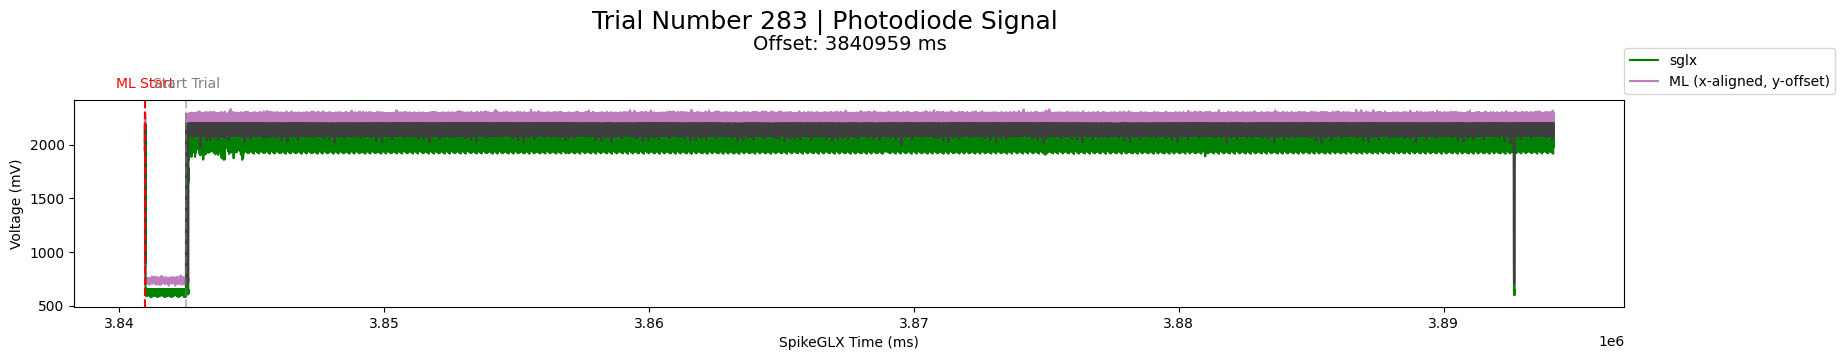

Trial 283:
  ML Cam Start           |  2      
  ML Cam End             |  53202  
  ML Cam Num Frames      |  6385   
  --------------------------------------
  SpikeGLX Trial Start   |  3840958.82
  SpikeGLX Trial End     |  3894168.82
  SpikeGLX Num Frames    |  6385   
  ML-SGLX Correlation: 0.939


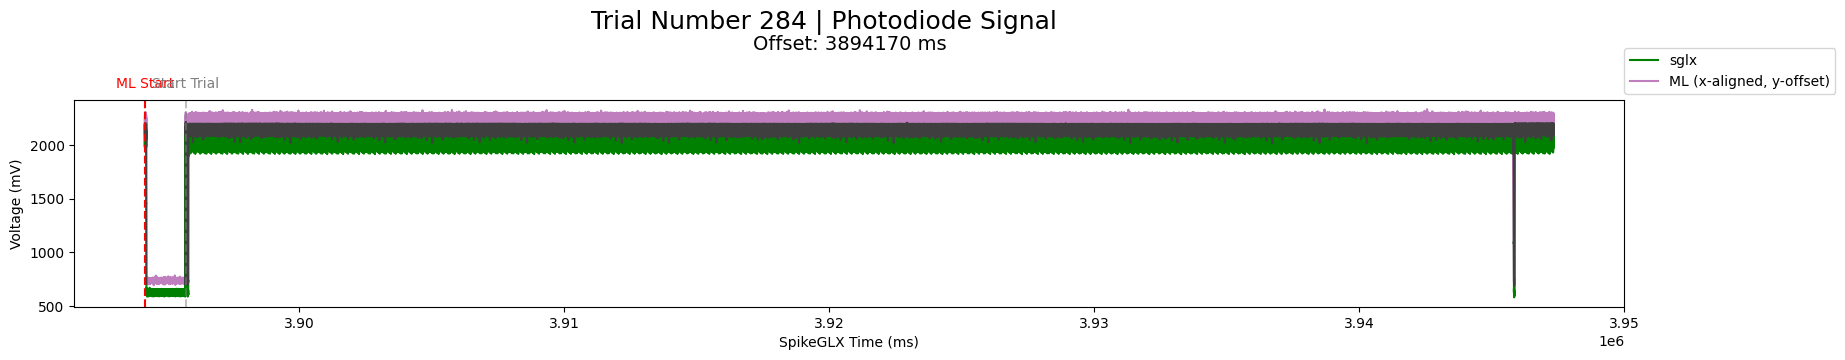

Trial 284:
  ML Cam Start           |  8      
  ML Cam End             |  53183  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  3894169.52
  SpikeGLX Trial End     |  3947354.52
  SpikeGLX Num Frames    |  6383   
  ML-SGLX Correlation: 0.934


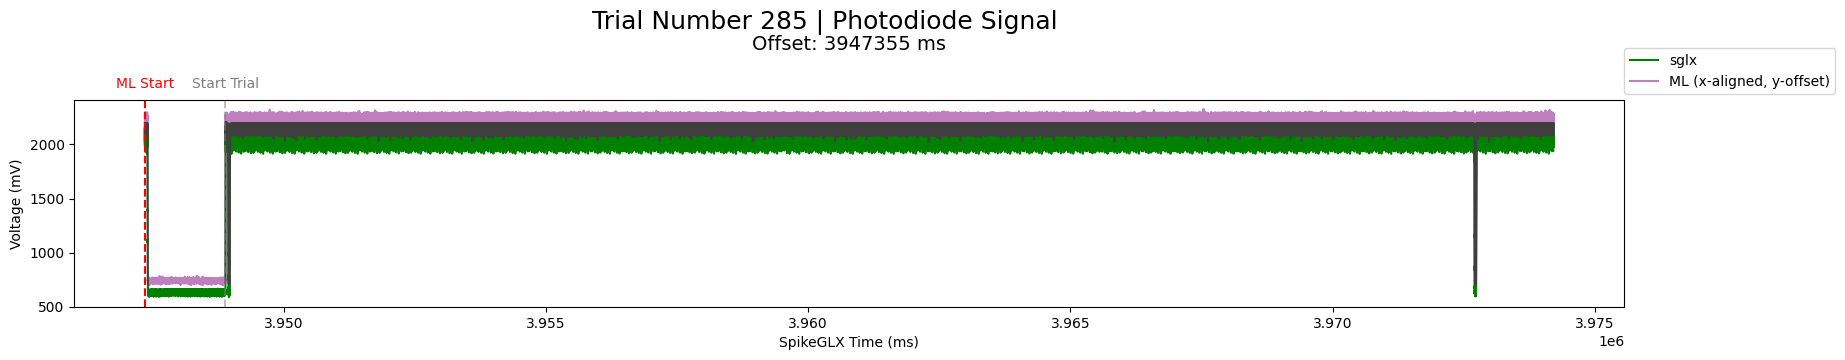

Trial 285:
  ML Cam Start           |  7      
  ML Cam End             |  26857  
  ML Cam Num Frames      |  3223   
  --------------------------------------
  SpikeGLX Trial Start   |  3947355.18
  SpikeGLX Trial End     |  3974216.18
  SpikeGLX Num Frames    |  3223   
  ML-SGLX Correlation: 0.966
Trial 286 | Correlation: 0.997 | SGLX High Time: 28335 | ML High Time: 1537


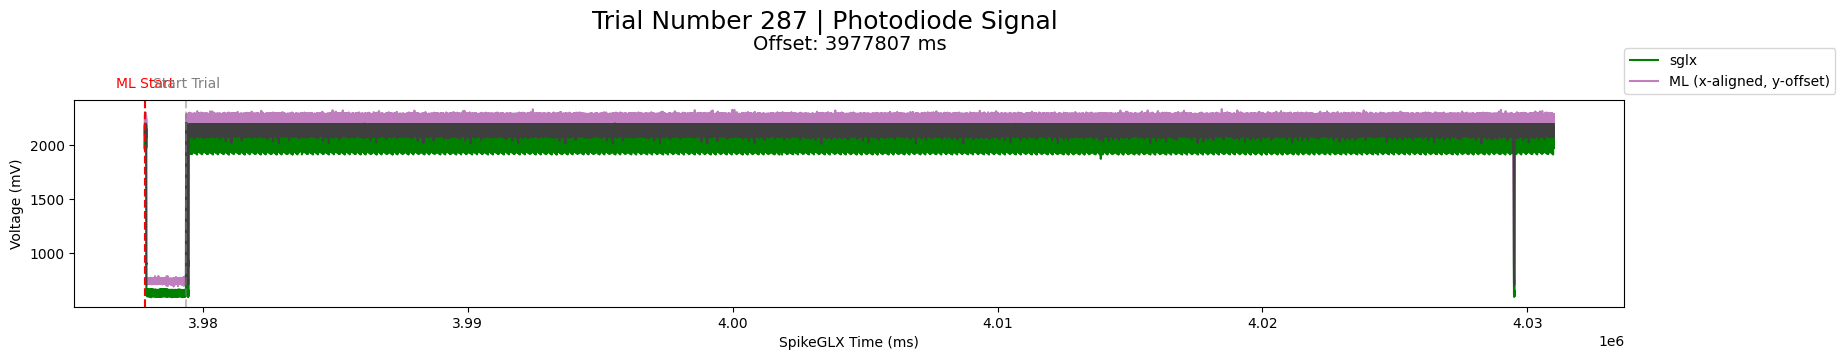

Trial 287:
  ML Cam Start           |  6      
  ML Cam End             |  53197  
  ML Cam Num Frames      |  6384   
  --------------------------------------
  SpikeGLX Trial Start   |  3977806.88
  SpikeGLX Trial End     |  4031008.88
  SpikeGLX Num Frames    |  6384   
  ML-SGLX Correlation: 0.938
Trial 288 | Correlation: 0.993 | SGLX High Time: 28318 | ML High Time: 1536
Trial 289 | Correlation: 0.995 | SGLX High Time: 33485 | ML High Time: 1781
Trial 290 | Correlation: 0.996 | SGLX High Time: 29373 | ML High Time: 1586
Trial 291 | Correlation: 0.996 | SGLX High Time: 32170 | ML High Time: 1718
Trial 292 | Correlation: 0.997 | SGLX High Time: 33049 | ML High Time: 1760
Trial 293 | Correlation: 0.996 | SGLX High Time: 28694 | ML High Time: 1554
Trial 294 | Correlation: 0.997 | SGLX High Time: 28689 | ML High Time: 1555
Trial 295 | Correlation: 0.998 | SGLX High Time: 28698 | ML High Time: 1554
Trial 296 | Correlation: 0.996 | SGLX High Time: 28691 | ML High Time: 1554
Trial 297 | C

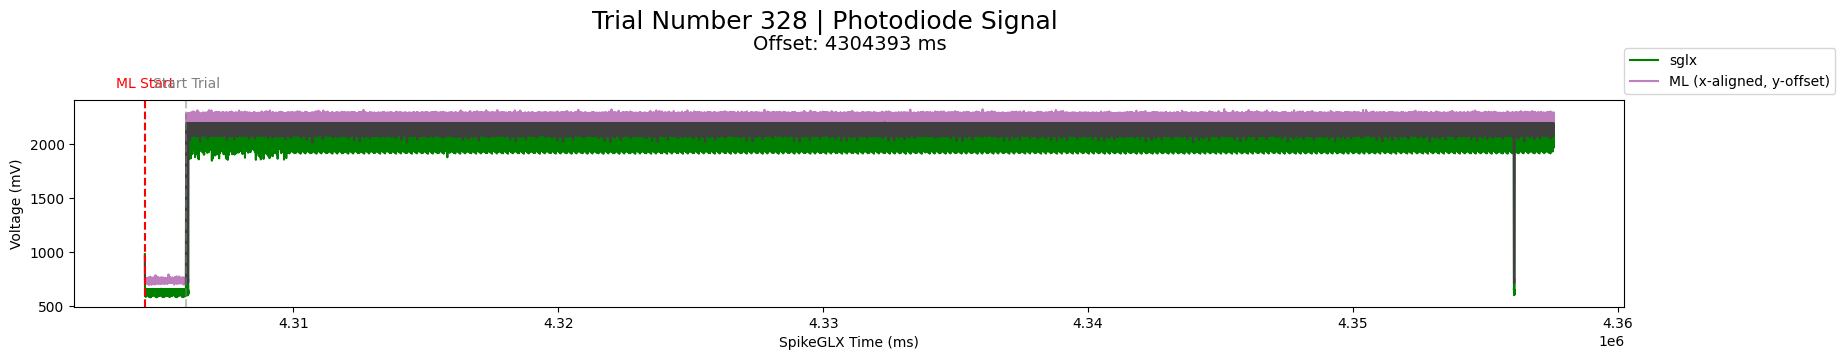

Trial 328:
  ML Cam Start           |  6      
  ML Cam End             |  53197  
  ML Cam Num Frames      |  6384   
  --------------------------------------
  SpikeGLX Trial Start   |  4304392.64
  SpikeGLX Trial End     |  4357591.64
  SpikeGLX Num Frames    |  6384   
  ML-SGLX Correlation: 0.936
Trial 329 | Correlation: 0.989 | SGLX High Time: 28329 | ML High Time: 1536
Trial 330 | Correlation: 0.996 | SGLX High Time: 28690 | ML High Time: 1554
Trial 331 | Correlation: 0.996 | SGLX High Time: 32535 | ML High Time: 1736
Trial 332 | Correlation: 0.995 | SGLX High Time: 28686 | ML High Time: 1554
Trial 333 | Correlation: 0.996 | SGLX High Time: 28700 | ML High Time: 1554
Trial 334 | Correlation: 0.994 | SGLX High Time: 29009 | ML High Time: 1570
Trial 335 | Correlation: 0.993 | SGLX High Time: 32915 | ML High Time: 1753


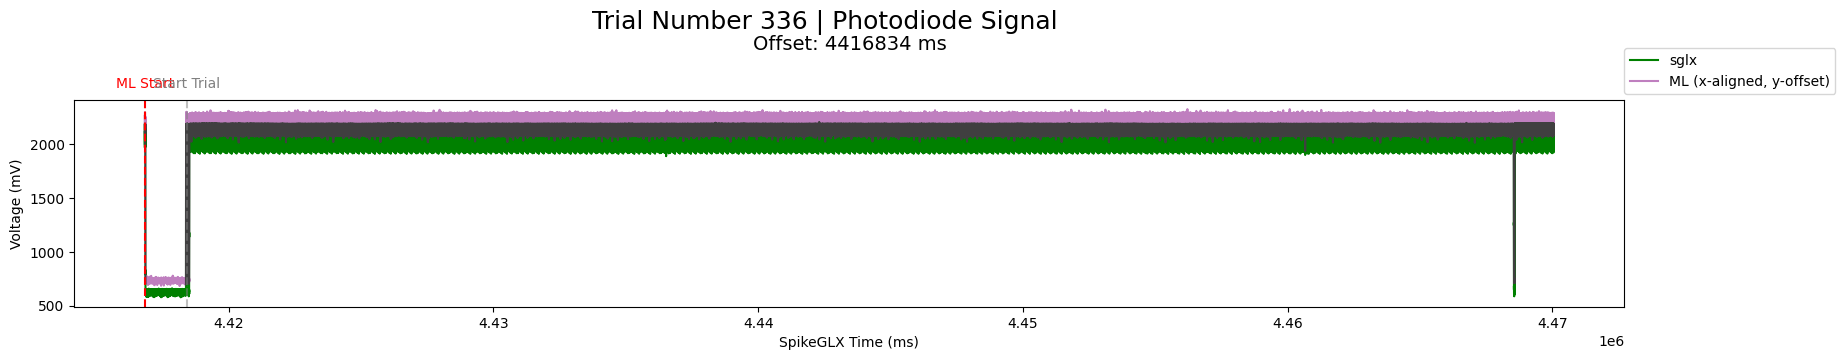

Trial 336:
  ML Cam Start           |  7      
  ML Cam End             |  53216  
  ML Cam Num Frames      |  6386   
  --------------------------------------
  SpikeGLX Trial Start   |  4416833.75
  SpikeGLX Trial End     |  4470056.75
  SpikeGLX Num Frames    |  6386   
  ML-SGLX Correlation: 0.939


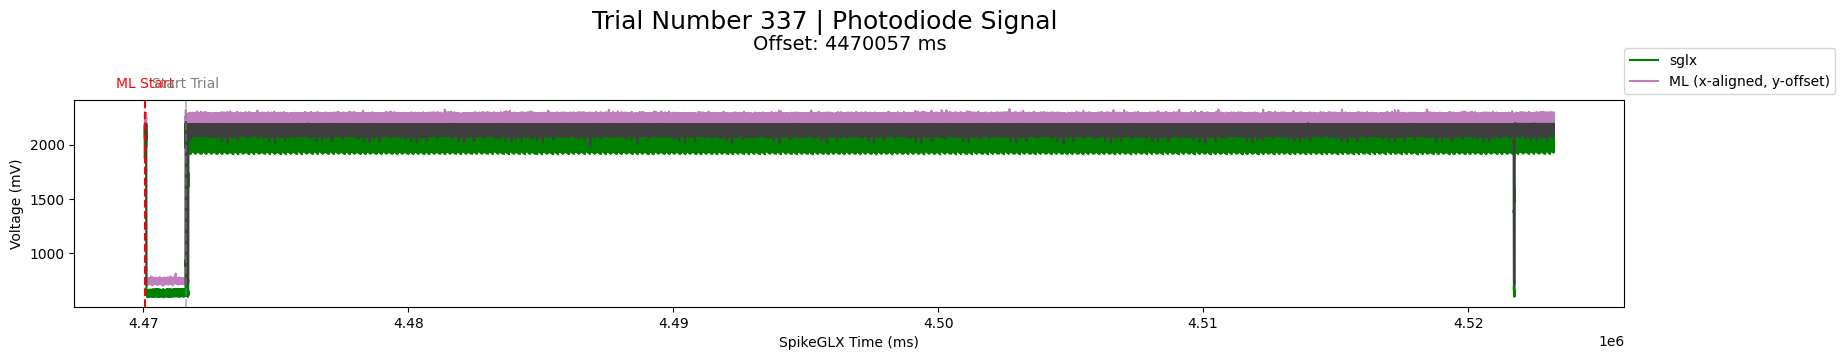

Trial 337:
  ML Cam Start           |  1      
  ML Cam End             |  53176  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  4470057.28
  SpikeGLX Trial End     |  4523238.28
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.937


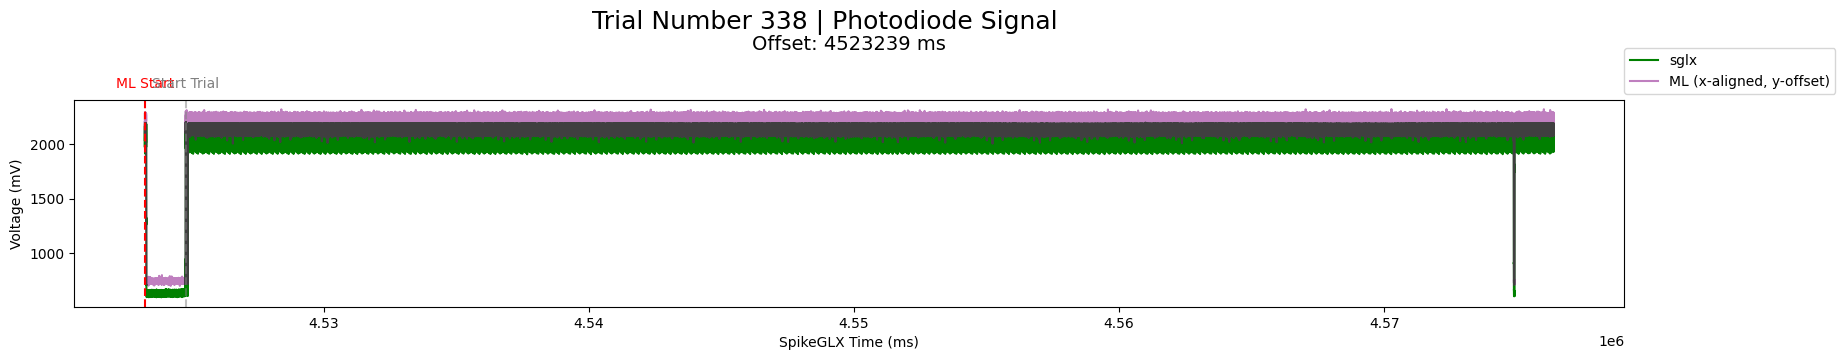

Trial 338:
  ML Cam Start           |  3      
  ML Cam End             |  53161  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  4523238.94
  SpikeGLX Trial End     |  4576404.94
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.934


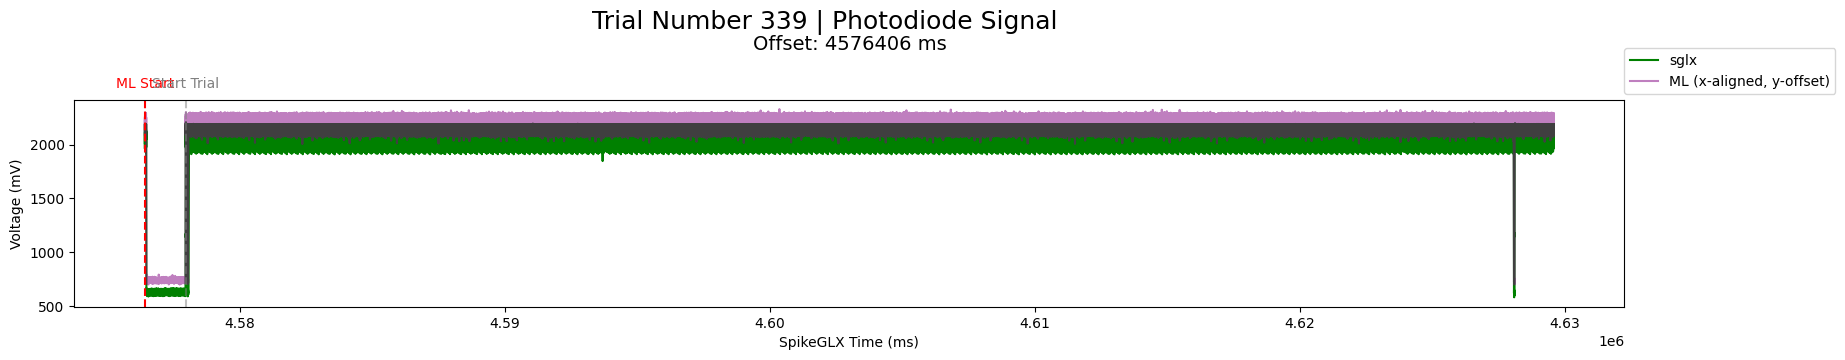

Trial 339:
  ML Cam Start           |  4      
  ML Cam End             |  53179  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  4576405.54
  SpikeGLX Trial End     |  4629591.54
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.937


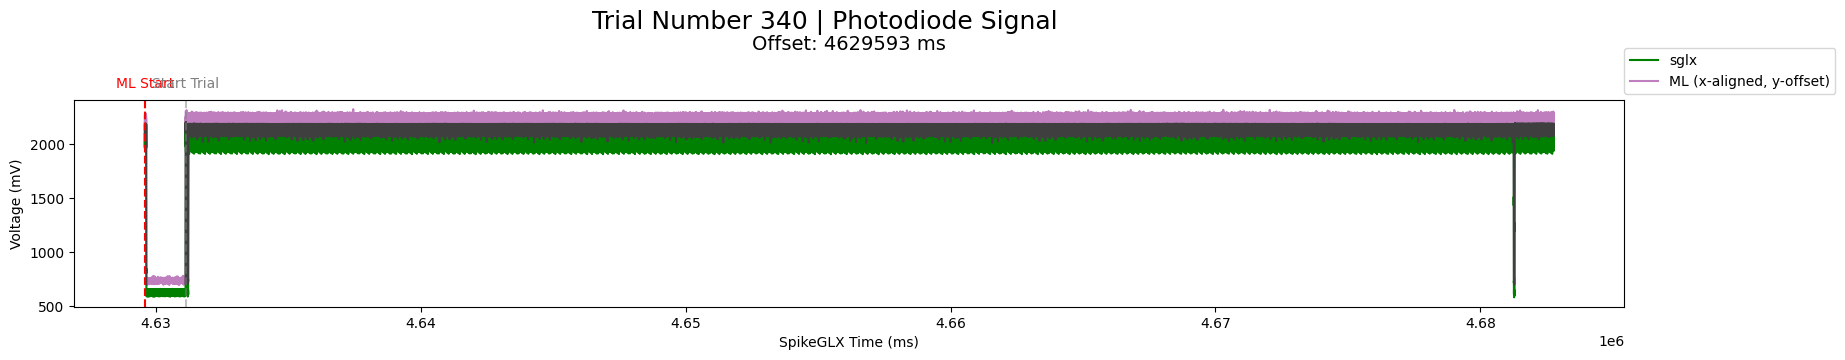

Trial 340:
  ML Cam Start           |  1      
  ML Cam End             |  53176  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  4629592.58
  SpikeGLX Trial End     |  4682773.58
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.937


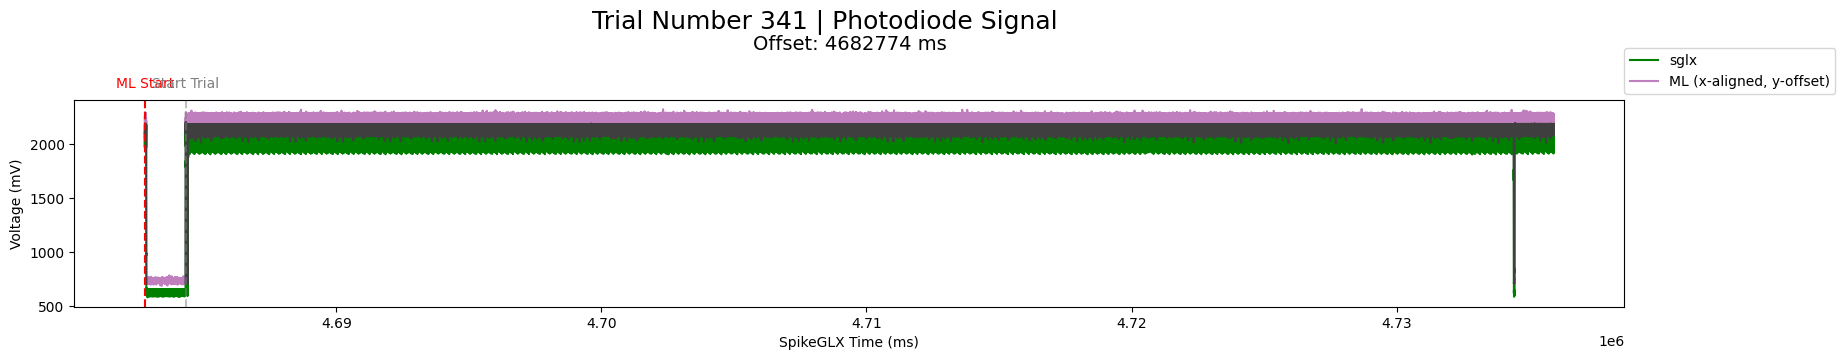

Trial 341:
  ML Cam Start           |  3      
  ML Cam End             |  53162  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  4682773.91
  SpikeGLX Trial End     |  4735938.91
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.937


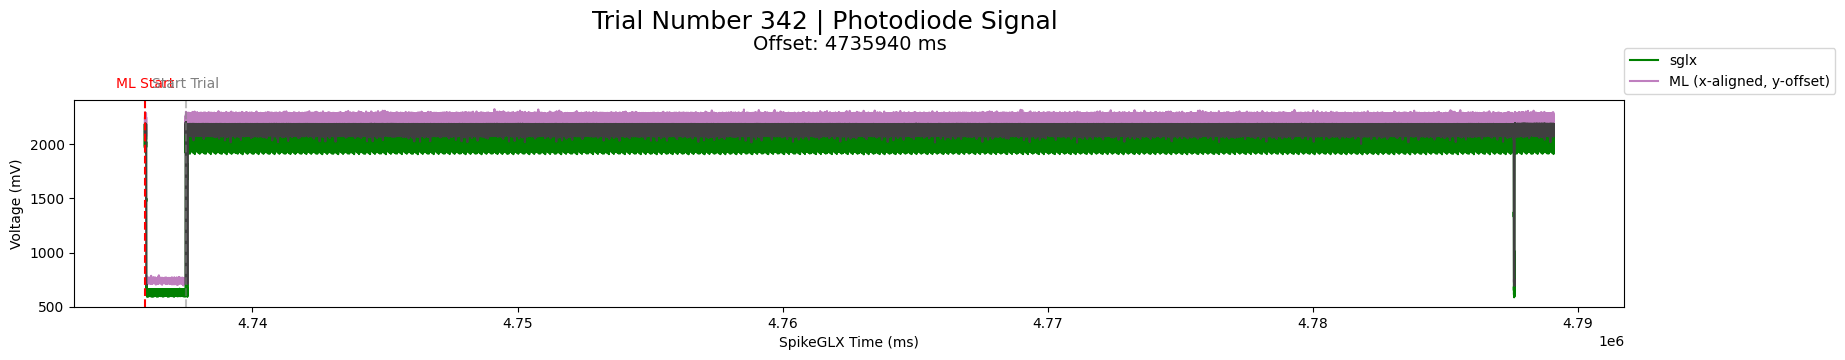

Trial 342:
  ML Cam Start           |  5      
  ML Cam End             |  53155  
  ML Cam Num Frames      |  6379   
  --------------------------------------
  SpikeGLX Trial Start   |  4735939.61
  SpikeGLX Trial End     |  4789102.61
  SpikeGLX Num Frames    |  6379   
  ML-SGLX Correlation: 0.935


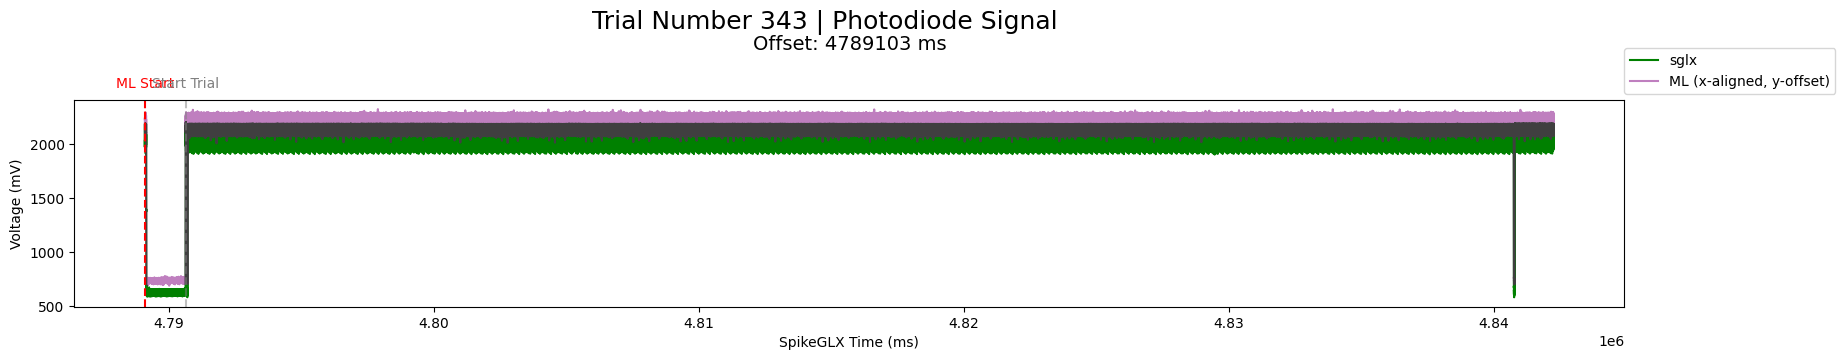

Trial 343:
  ML Cam Start           |  9      
  ML Cam End             |  53159  
  ML Cam Num Frames      |  6379   
  --------------------------------------
  SpikeGLX Trial Start   |  4789103.28
  SpikeGLX Trial End     |  4842268.28
  SpikeGLX Num Frames    |  6379   
  ML-SGLX Correlation: 0.937


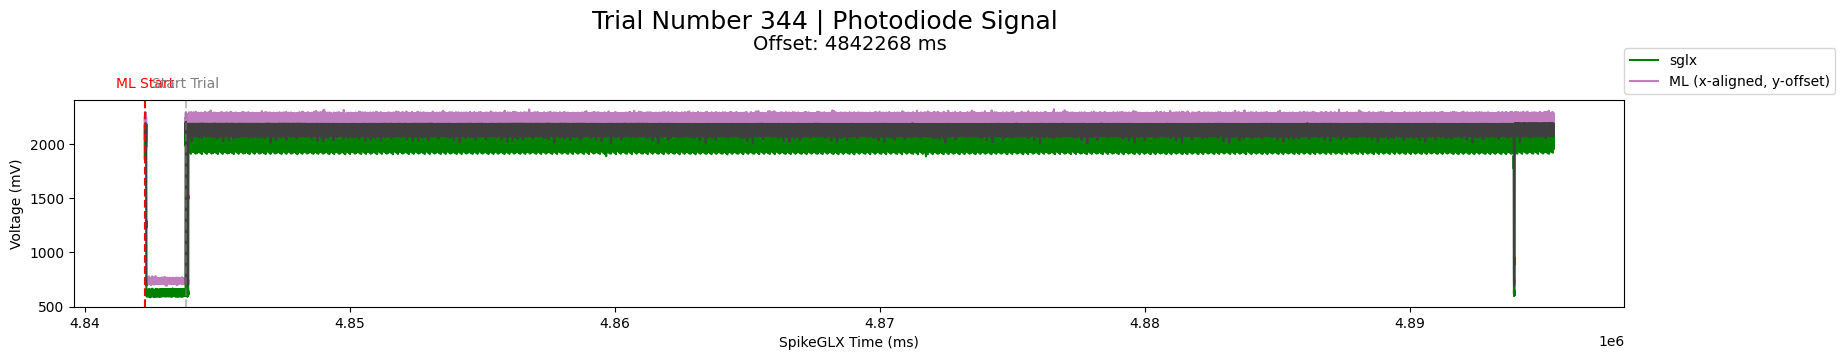

Trial 344:
  ML Cam Start           |  2      
  ML Cam End             |  53177  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  4842267.89
  SpikeGLX Trial End     |  4895450.89
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.934
Trial 345 | Correlation: 0.988 | SGLX High Time: 28329 | ML High Time: 1536
Trial 346 | Correlation: 0.995 | SGLX High Time: 29010 | ML High Time: 1569
Trial 347 | Correlation: 0.997 | SGLX High Time: 28314 | ML High Time: 1536
Trial 348 | Correlation: 0.995 | SGLX High Time: 28298 | ML High Time: 1536
Trial 349 | Correlation: 0.996 | SGLX High Time: 28696 | ML High Time: 1554
Trial 350 | Correlation: 0.998 | SGLX High Time: 32195 | ML High Time: 1720
Trial 351 | Correlation: 0.995 | SGLX High Time: 28687 | ML High Time: 1554
Trial 352 | Correlation: 0.998 | SGLX High Time: 28685 | ML High Time: 1554
Trial 353 | Correlation: 0.998 | SGLX High Time: 28696 | ML High Time: 1554
Trial 354 | C

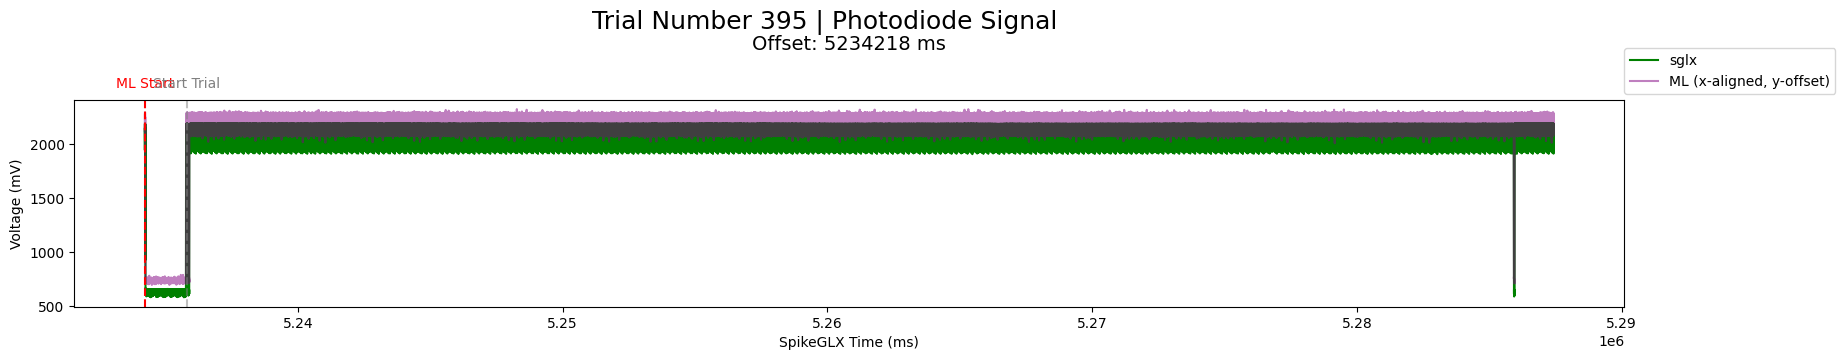

Trial 395:
  ML Cam Start           |  7      
  ML Cam End             |  53215  
  ML Cam Num Frames      |  6386   
  --------------------------------------
  SpikeGLX Trial Start   |  5234217.77
  SpikeGLX Trial End     |  5287439.77
  SpikeGLX Num Frames    |  6386   
  ML-SGLX Correlation: 0.937
Trial 396 | Correlation: 0.993 | SGLX High Time: 28315 | ML High Time: 1536


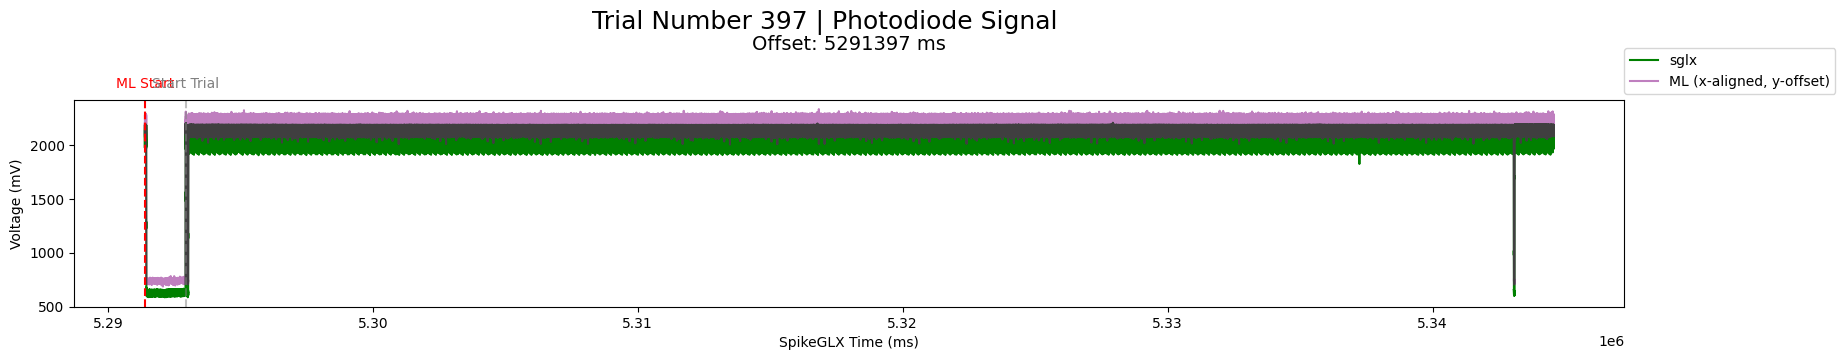

Trial 397:
  ML Cam Start           |  3      
  ML Cam End             |  53178  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  5291396.95
  SpikeGLX Trial End     |  5344580.95
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.938


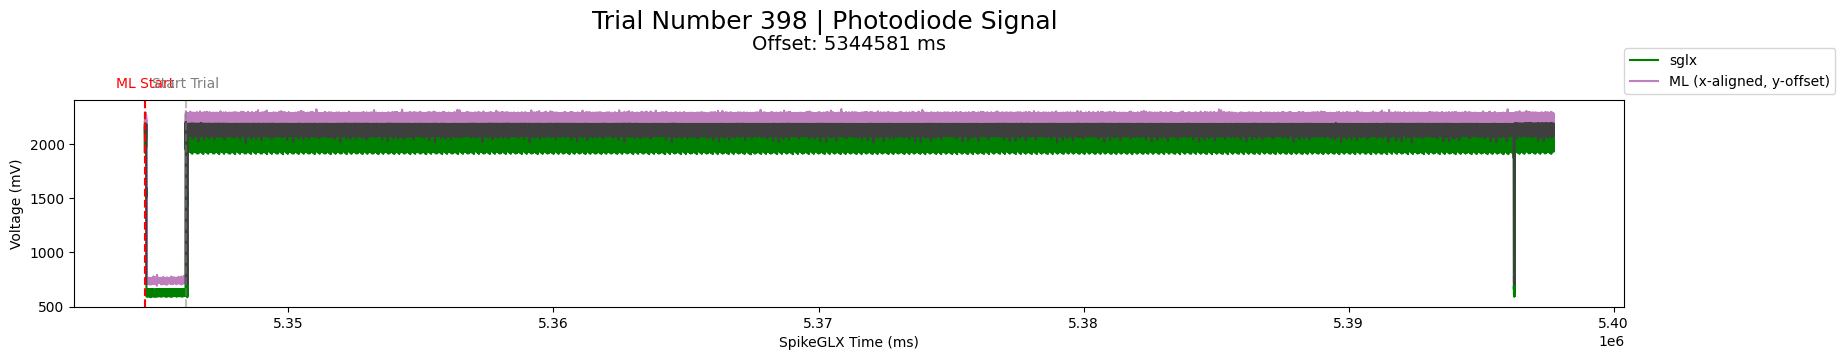

Trial 398:
  ML Cam Start           |  2      
  ML Cam End             |  53160  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  5344581.24
  SpikeGLX Trial End     |  5397749.24
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.933


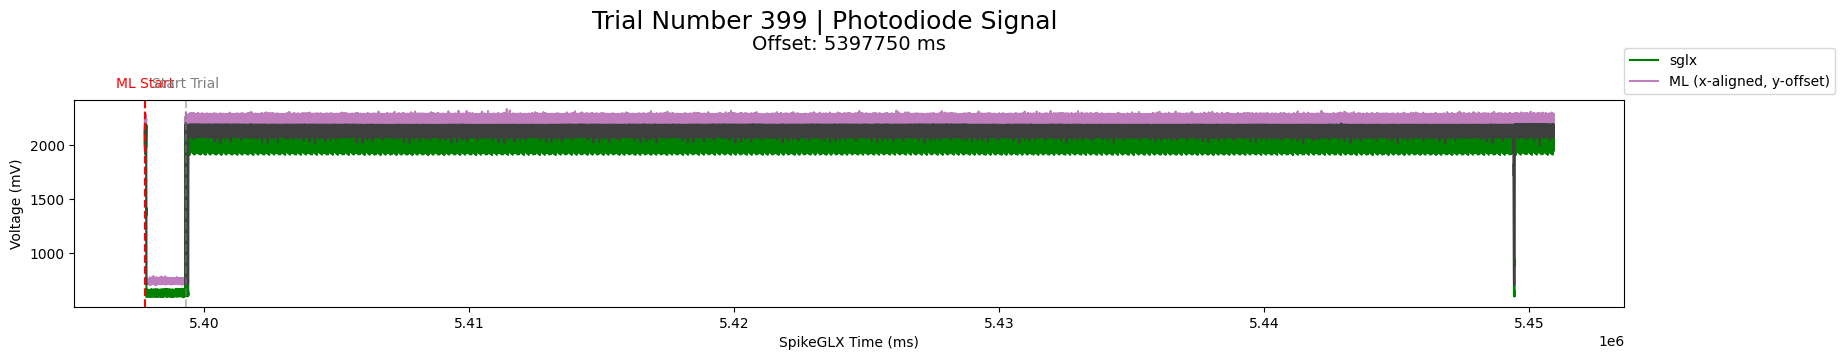

Trial 399:
  ML Cam Start           |  9      
  ML Cam End             |  53175  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  5397749.68
  SpikeGLX Trial End     |  5450929.68
  SpikeGLX Num Frames    |  6382   
  ML-SGLX Correlation: 0.934


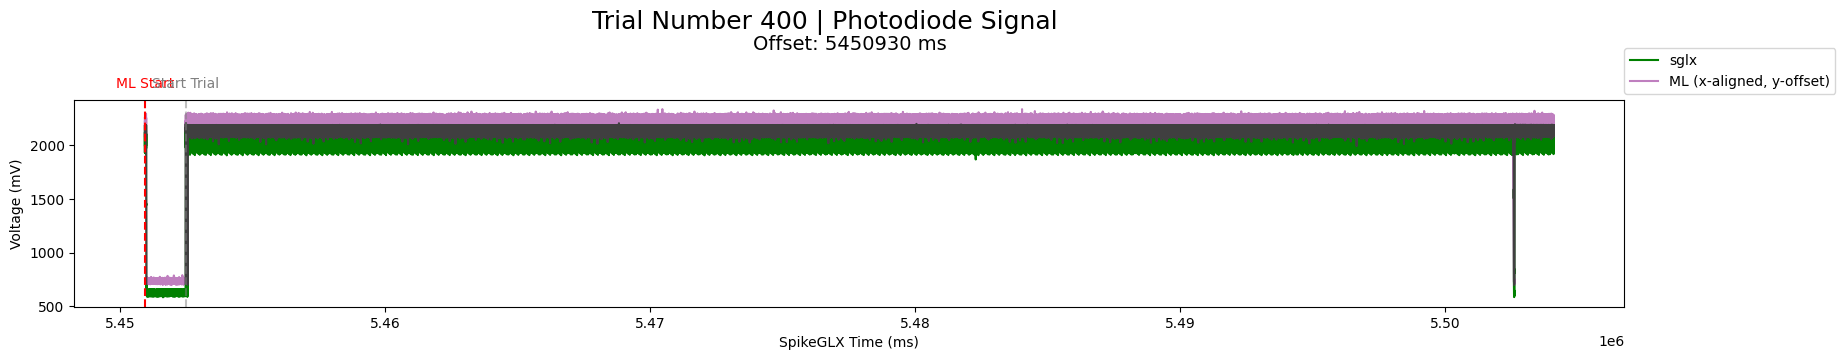

Trial 400:
  ML Cam Start           |  4      
  ML Cam End             |  53162  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  5450930.49
  SpikeGLX Trial End     |  5504095.49
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.933


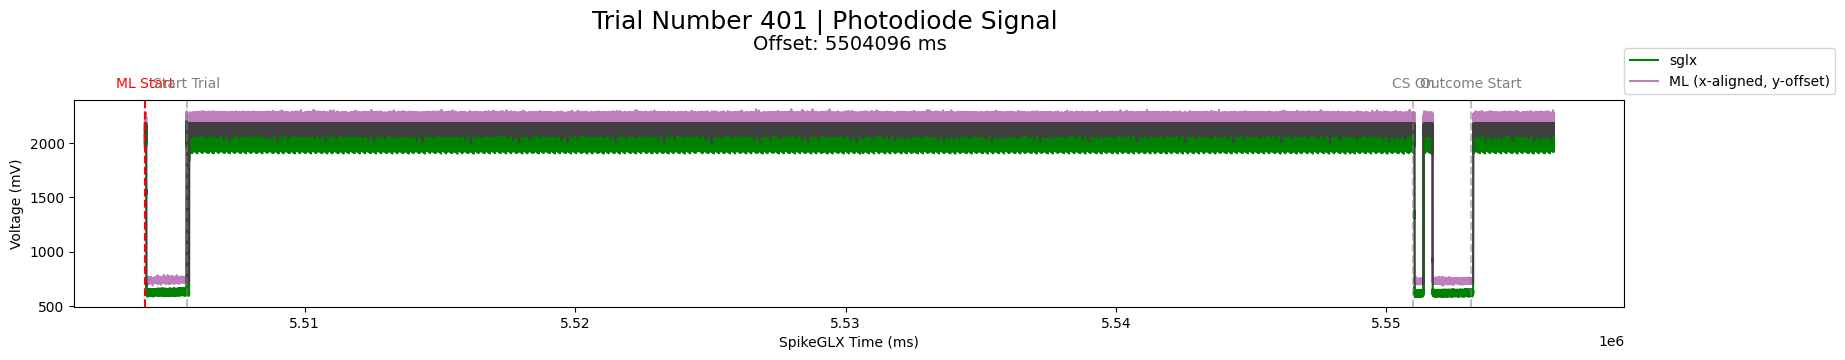

Trial 401:
  ML Cam Start           |  5      
  ML Cam End             |  52089  
  ML Cam Num Frames      |  6251   
  --------------------------------------
  SpikeGLX Trial Start   |  5504095.77
  SpikeGLX Trial End     |  5556192.77
  SpikeGLX Num Frames    |  6251   
  ML-SGLX Correlation: 0.969
Trial 402 | Correlation: 0.992 | SGLX High Time: 32623 | ML High Time: 1739
Trial 403 | Correlation: 0.995 | SGLX High Time: 28684 | ML High Time: 1554
Trial 404 | Correlation: 0.994 | SGLX High Time: 28687 | ML High Time: 1554
Trial 405 | Correlation: 0.997 | SGLX High Time: 31307 | ML High Time: 1677
Trial 406 | Correlation: 0.997 | SGLX High Time: 28678 | ML High Time: 1554
Trial 407 | Correlation: 0.994 | SGLX High Time: 28704 | ML High Time: 1555
Trial 408 | Correlation: 0.998 | SGLX High Time: 29037 | ML High Time: 1570
Trial 409 | Correlation: 0.997 | SGLX High Time: 28690 | ML High Time: 1554
Trial 410 | Correlation: 0.996 | SGLX High Time: 29126 | ML High Time: 1575
Trial 411 | C

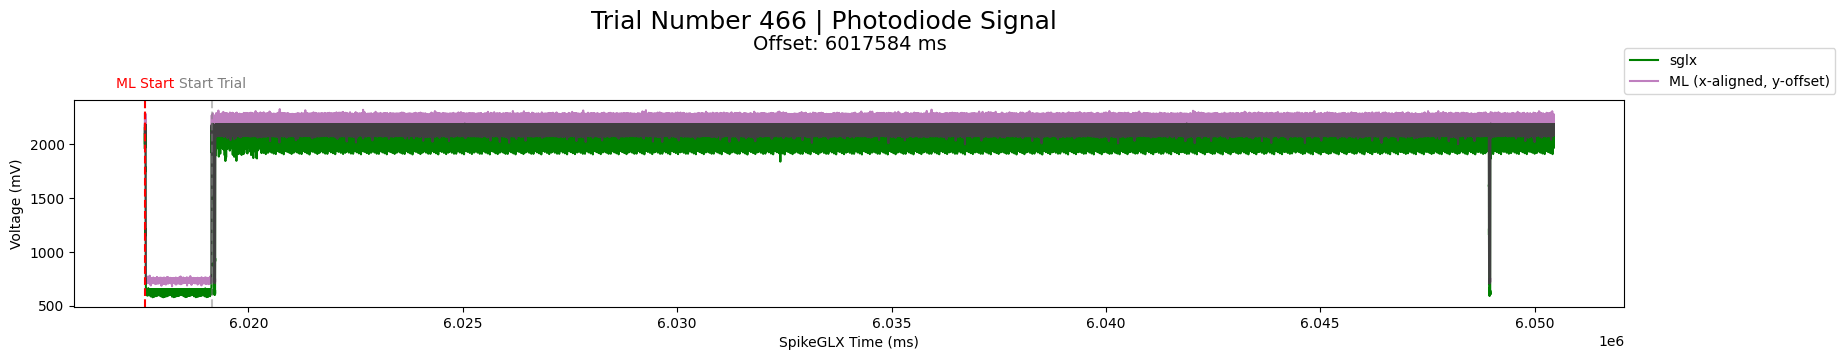

Trial 466:
  ML Cam Start           |  5      
  ML Cam End             |  32864  
  ML Cam Num Frames      |  3944   
  --------------------------------------
  SpikeGLX Trial Start   |  6017584.37
  SpikeGLX Trial End     |  6050451.37
  SpikeGLX Num Frames    |  3944   
  ML-SGLX Correlation: 0.96


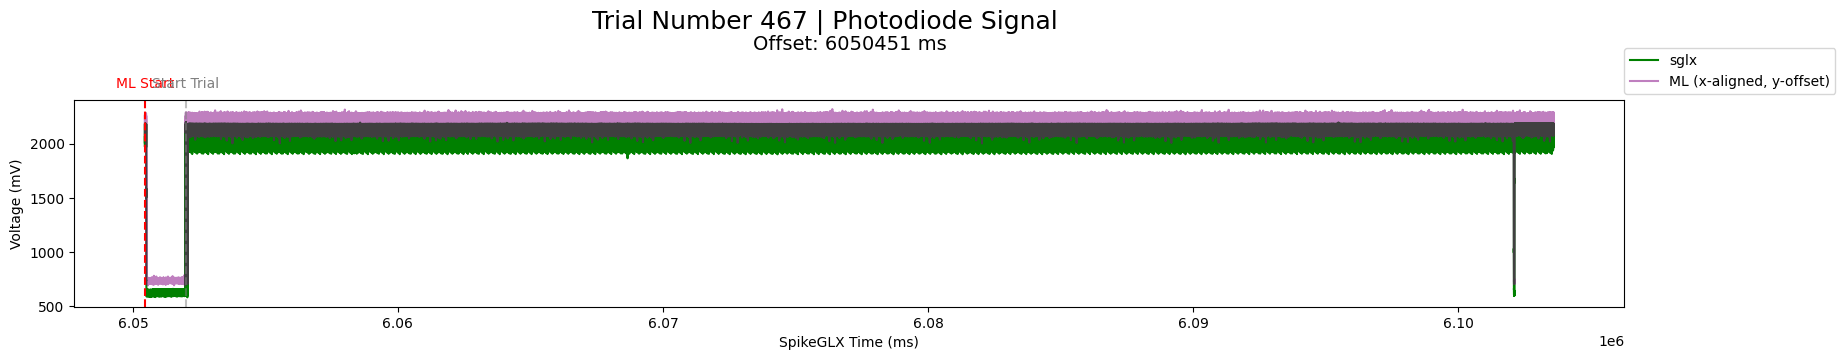

Trial 467:
  ML Cam Start           |  5      
  ML Cam End             |  53163  
  ML Cam Num Frames      |  6380   
  --------------------------------------
  SpikeGLX Trial Start   |  6050451.11
  SpikeGLX Trial End     |  6103621.11
  SpikeGLX Num Frames    |  6380   
  ML-SGLX Correlation: 0.936
Trial 468 | Correlation: 0.995 | SGLX High Time: 28328 | ML High Time: 1536
Trial 469 | Correlation: 0.993 | SGLX High Time: 28313 | ML High Time: 1536


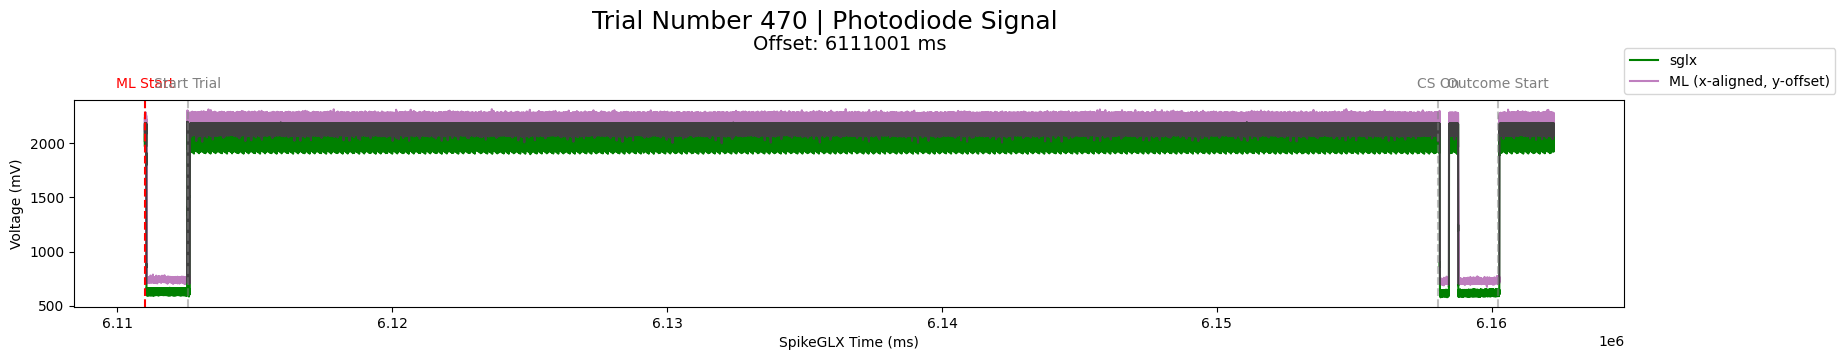

Trial 470:
  ML Cam Start           |  6      
  ML Cam End             |  51256  
  ML Cam Num Frames      |  6151   
  --------------------------------------
  SpikeGLX Trial Start   |  6111000.78
  SpikeGLX Trial End     |  6162262.78
  SpikeGLX Num Frames    |  6151   
  ML-SGLX Correlation: 0.969
Trial 471 | Correlation: 0.994 | SGLX High Time: 28712 | ML High Time: 1554
Trial 472 | Correlation: 0.996 | SGLX High Time: 32165 | ML High Time: 1719
Trial 473 | Correlation: 0.995 | SGLX High Time: 28705 | ML High Time: 1554
Trial 474 | Correlation: 0.997 | SGLX High Time: 33255 | ML High Time: 1770
Trial 475 | Correlation: 0.996 | SGLX High Time: 29025 | ML High Time: 1570
Trial 476 | Correlation: 0.996 | SGLX High Time: 28686 | ML High Time: 1553
Trial 477 | Correlation: 0.995 | SGLX High Time: 28686 | ML High Time: 1554
Trial 478 | Correlation: 0.994 | SGLX High Time: 29000 | ML High Time: 1569
Trial 479 | Correlation: 0.993 | SGLX High Time: 28311 | ML High Time: 1536
Trial 480 | C

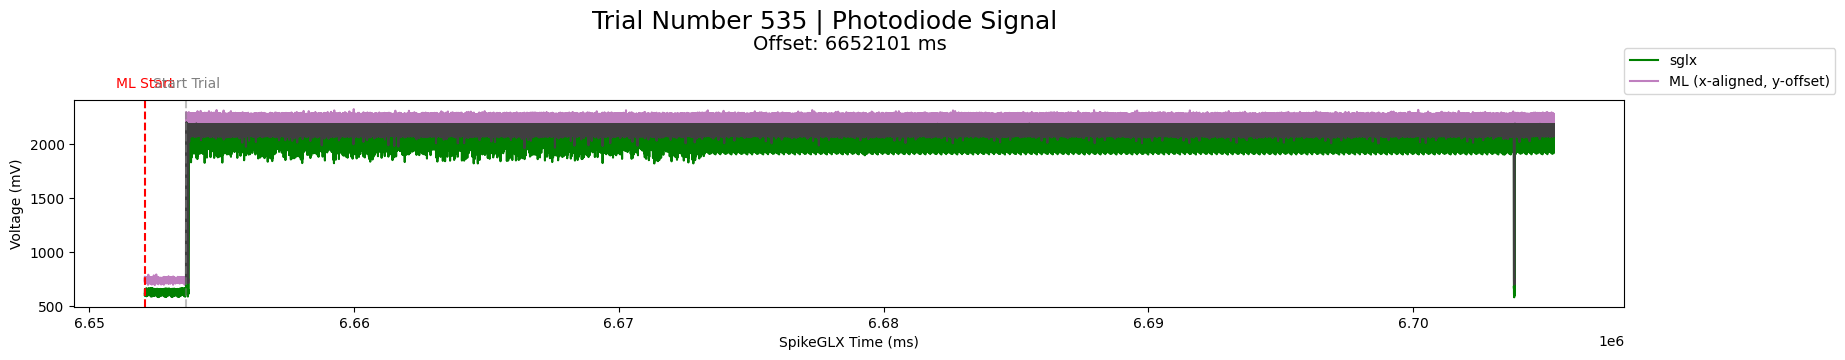

Trial 535:
  ML Cam Start           |  2      
  ML Cam End             |  53202  
  ML Cam Num Frames      |  6385   
  --------------------------------------
  SpikeGLX Trial Start   |  6652101.37
  SpikeGLX Trial End     |  6705311.37
  SpikeGLX Num Frames    |  6385   
  ML-SGLX Correlation: 0.939


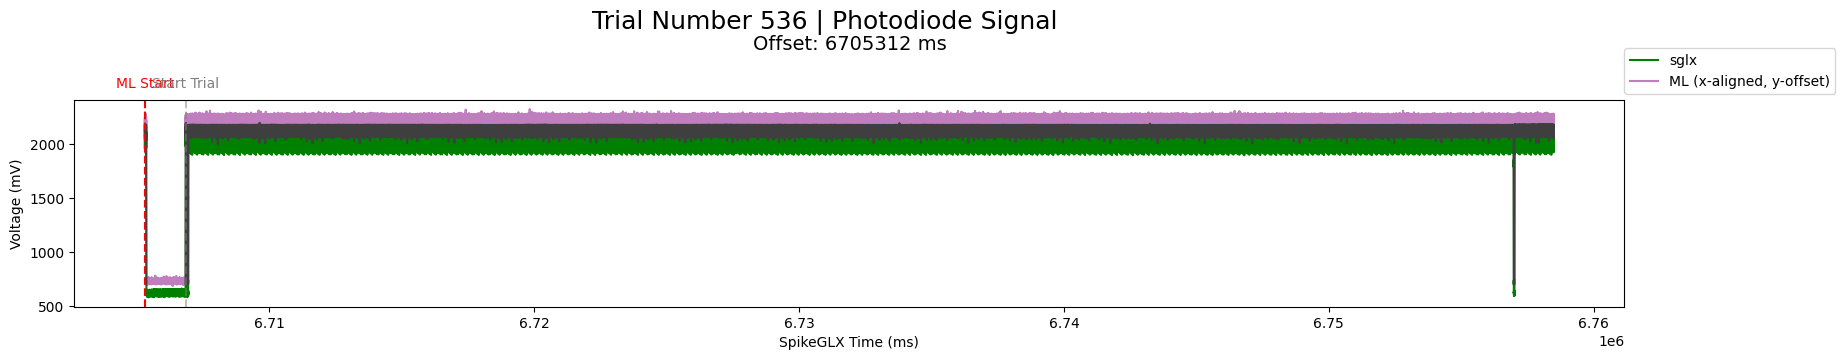

Trial 536:
  ML Cam Start           |  9      
  ML Cam End             |  53184  
  ML Cam Num Frames      |  6382   
  --------------------------------------
  SpikeGLX Trial Start   |  6705312.07
  SpikeGLX Trial End     |  6758497.07
  SpikeGLX Num Frames    |  6383   
  ML-SGLX Correlation: 0.934


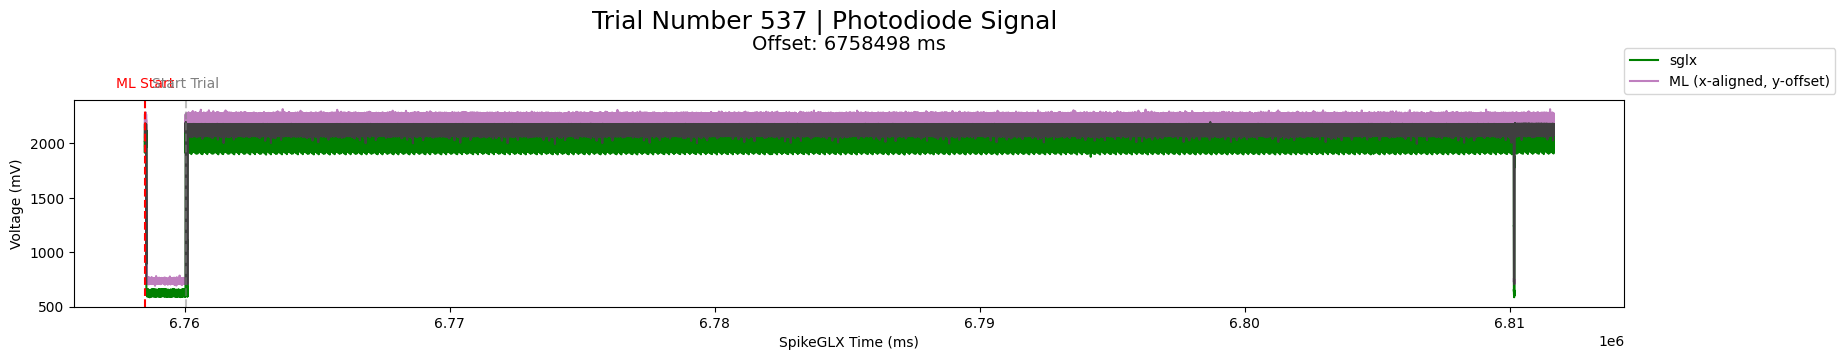

Trial 537:
  ML Cam Start           |  7      
  ML Cam End             |  53157  
  ML Cam Num Frames      |  6379   
  --------------------------------------
  SpikeGLX Trial Start   |  6758498.03
  SpikeGLX Trial End     |  6811663.03
  SpikeGLX Num Frames    |  6379   
  ML-SGLX Correlation: 0.936


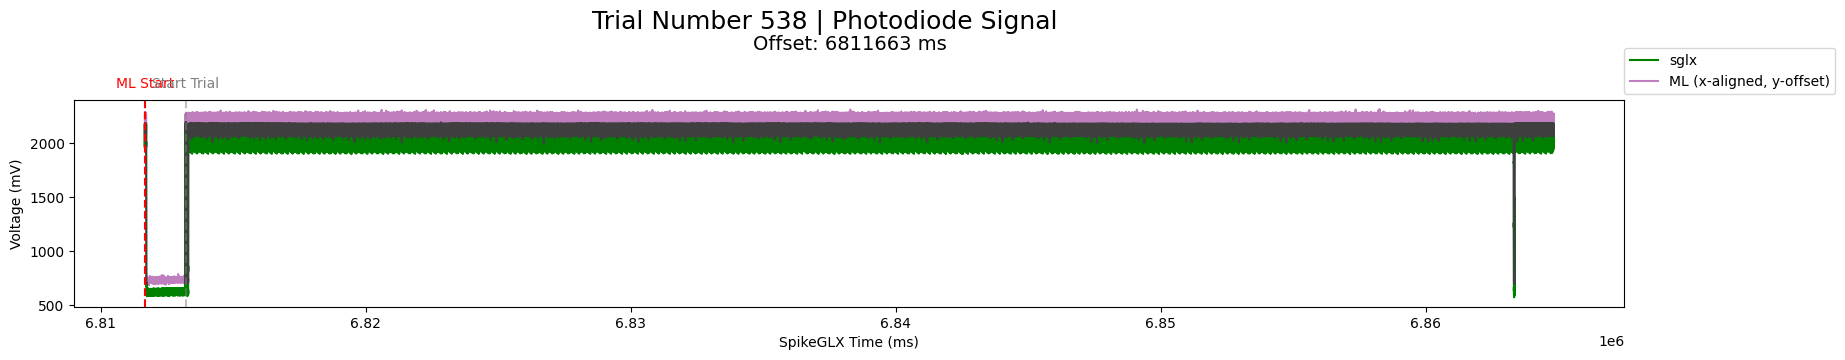

Trial 538:
  ML Cam Start           |  9      
  ML Cam End             |  53175  
  ML Cam Num Frames      |  6381   
  --------------------------------------
  SpikeGLX Trial Start   |  6811663.5
  SpikeGLX Trial End     |  6864844.5
  SpikeGLX Num Frames    |  6381   
  ML-SGLX Correlation: 0.937


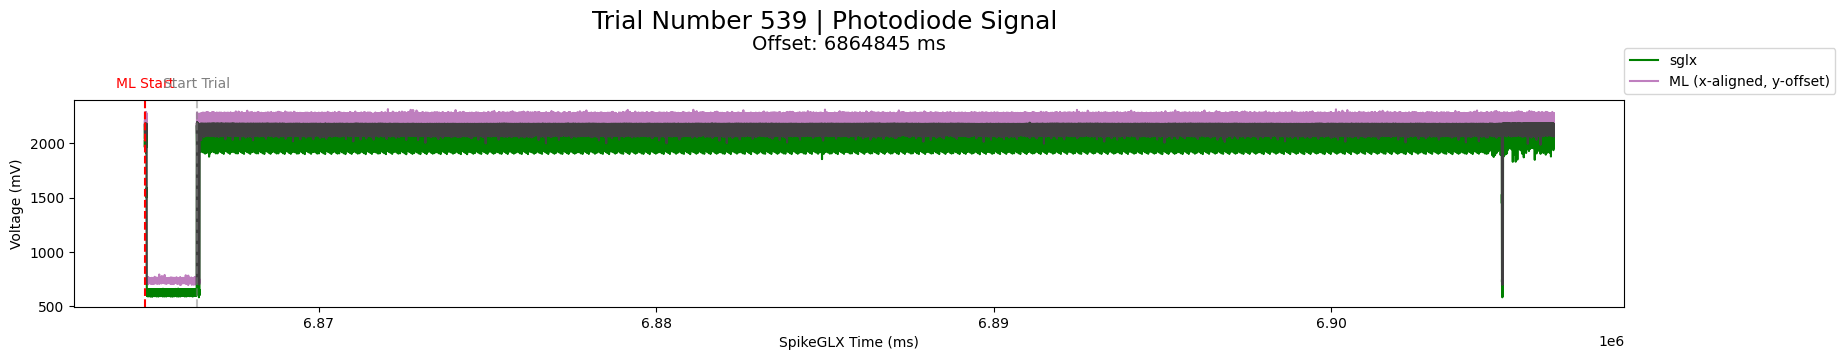

Trial 539:
  ML Cam Start           |  3      
  ML Cam End             |  40303  
  ML Cam Num Frames      |  4837   
  --------------------------------------
  SpikeGLX Trial Start   |  6864845.01
  SpikeGLX Trial End     |  6906598.01
  SpikeGLX Num Frames    |  4837   
  ML-SGLX Correlation: 0.95


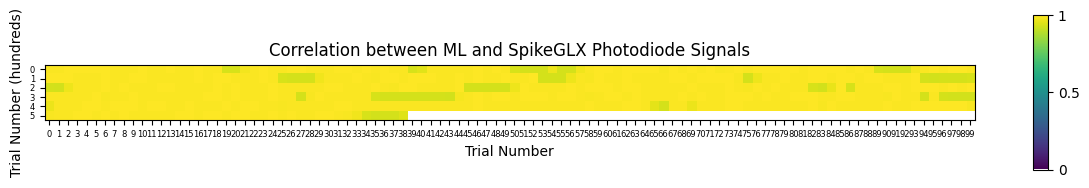

  Done.
Comparing ML and SpikeGLX photodiode signals...
Number of frames in ML Cam TTL: 828078
Number of frames in SpikeGLX Cam TTL: 828144
  Done.
Plotting ML and SpikeGLX photodiode signals...


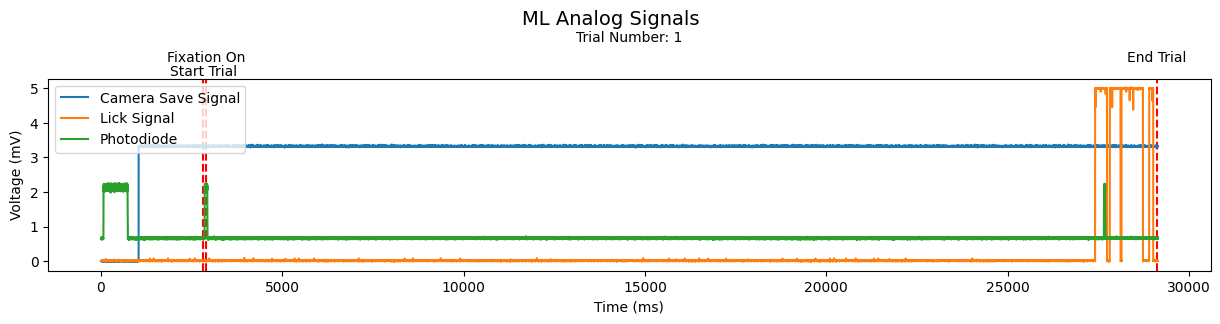

  Done.
Plotting first trial...


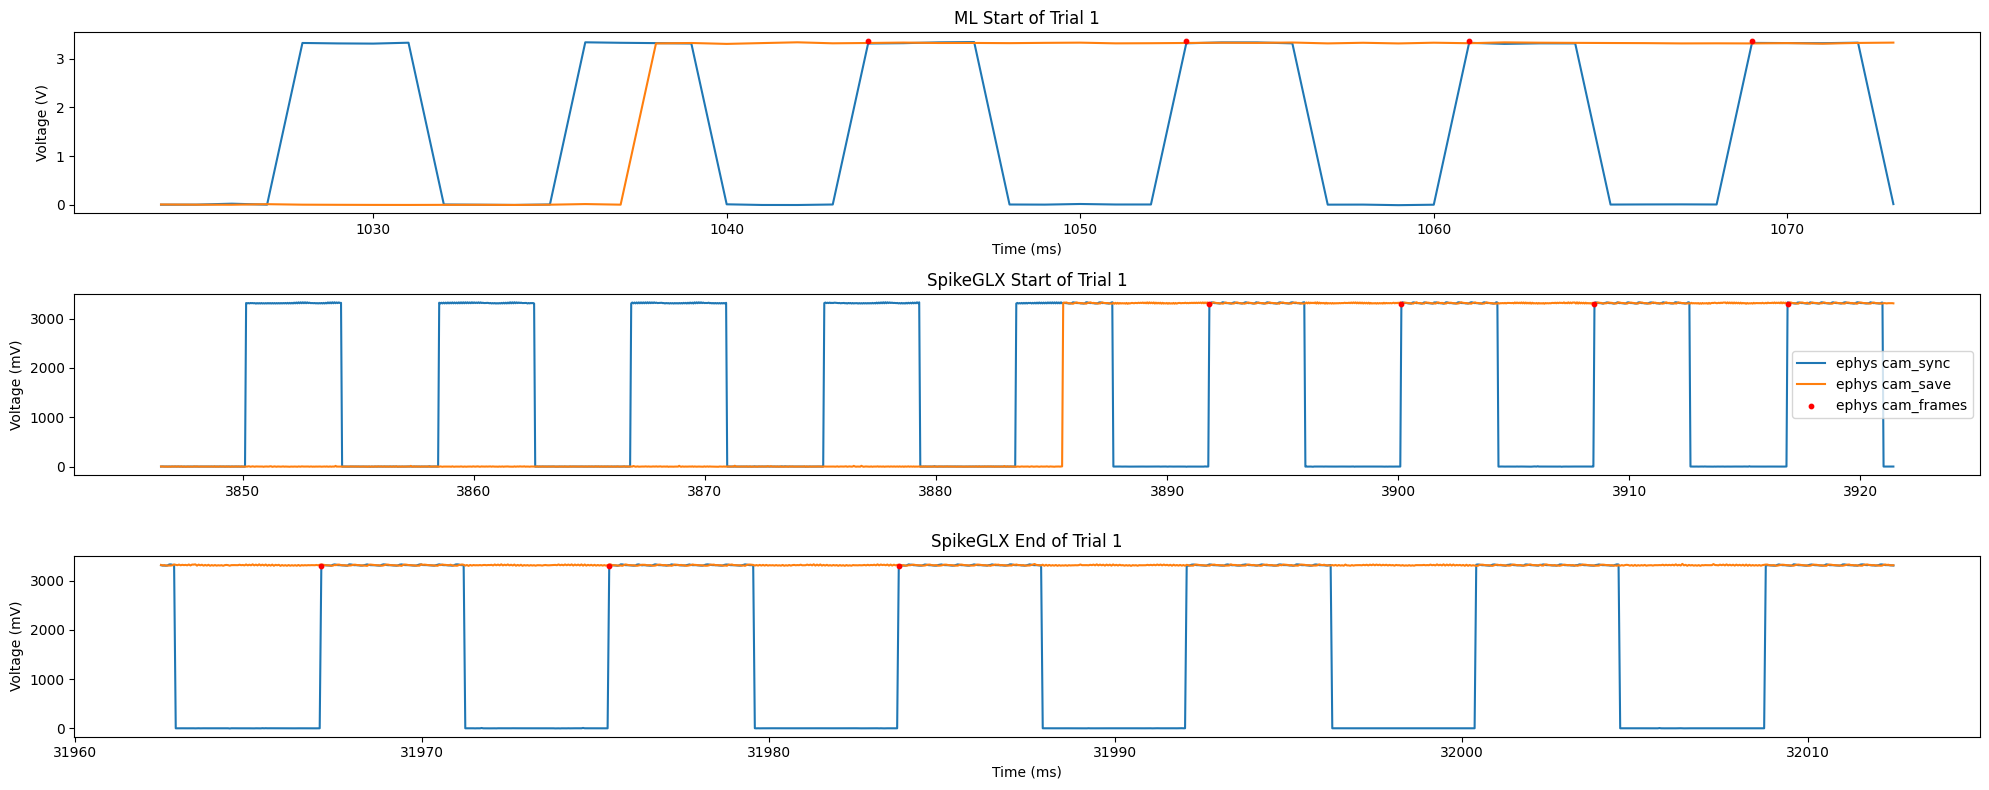

  Done.
Saving spikeglx_obj...
Pickle file size: 5876.483098 MB
Pickle file saved: /Users/rahimhashim/Desktop/Monkey-Emotions/spikeglx_obj_aragorn_230929.pkl
  Done. Saved spikeglx_obj to /Users/rahimhashim/Desktop/Monkey-Emotions/spikeglx_obj_aragorn_230929.pkl


In [57]:
from spike_glx.load_SGLX import load_sglx

# Load the spikeglx object
spikeglx_obj = load_sglx(session_obj.df, 
                         session_obj, 
                         file_container_obj, 
                         signal_dict, 
                         epochs)

### ML-SpikeGLX Session Correlation
To see just the correlation matrix for each trial in a session, run `plot_spikeglx_ml_corr` with the newly-generated `spikeglx_obj`.

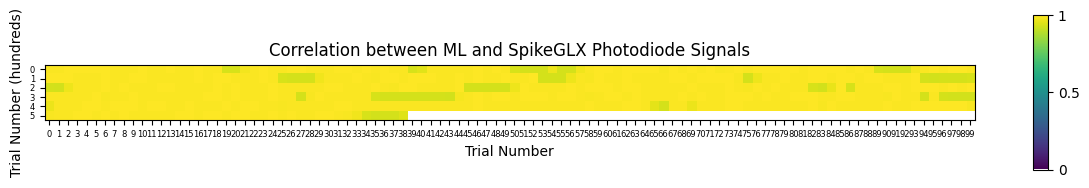

In [23]:
from spike_glx.read_SGLX import plot_spikeglx_ml_corr
plot_spikeglx_ml_corr(spikeglx_obj.ml_sglx_corr_matrix, 100)

***
## Process White Matter Videos

After generating a `SpikeGLX` object, you can segment all the White Matter videos by trial.

In [63]:
from video.wm_videos import parse_wm_videos

if session_obj.monkey == 'gandalf':
  epoch_start = 'start'
  epoch_end = 'end'
else:
  epoch_start = 'Trace Start'
  epoch_end = 'Outcome Start'

kwargs = {'spikeglx_obj': spikeglx_obj,       # 'spikeglx_obj': spikeglx_obj
          'session_obj': session_obj,         # 'session_obj': session_obj
          'trial_start': 0,                   # 'trial_start': 0 
          'trial_end': len(session_obj.df),   # 'trial_end': len(session_obj.df)
          'epoch_start': epoch_start,         # 'epoch_start': 'start'
          'epoch_end': epoch_end,             # 'epoch_end': 'end'   
          'thread_flag': False}               # 'thread_flag': False

parse_wm_videos(**kwargs)

Parsing Trials for Videos: 0 - 539
	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_1_e3v831b.mp4


Cam: e3v831b | Trial: 1 | Frames: 3836-4015:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_1_e3v8360.mp4


Cam: e3v8360 | Trial: 1 | Frames: 3836-4015:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_1_e3v83ad.mp4


Cam: e3v83ad | Trial: 1 | Frames: 3836-4015:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_1_e3v83d6.mp4


Cam: e3v83d6 | Trial: 1 | Frames: 3836-4015:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v831b.mp4


Cam: e3v831b | Trial: 2 | Frames: 4766-4944:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v8360.mp4


Cam: e3v8360 | Trial: 2 | Frames: 4766-4944:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v83ad.mp4


Cam: e3v83ad | Trial: 2 | Frames: 4766-4944:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v83d6.mp4


Cam: e3v83d6 | Trial: 2 | Frames: 4766-4944:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v831b.mp4


Cam: e3v831b | Trial: 3 | Frames: 5559-5740:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v8360.mp4


Cam: e3v8360 | Trial: 3 | Frames: 5559-5740:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v83ad.mp4


Cam: e3v83ad | Trial: 3 | Frames: 5559-5740:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v83d6.mp4


Cam: e3v83d6 | Trial: 3 | Frames: 5559-5740:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v831b.mp4


Cam: e3v831b | Trial: 4 | Frames: 6243-6422:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v8360.mp4


Cam: e3v8360 | Trial: 4 | Frames: 6243-6422:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v83ad.mp4


Cam: e3v83ad | Trial: 4 | Frames: 6243-6422:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v83d6.mp4


Cam: e3v83d6 | Trial: 4 | Frames: 6243-6422:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v831b.mp4


Cam: e3v831b | Trial: 5 | Frames: 7178-7359:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v8360.mp4


Cam: e3v8360 | Trial: 5 | Frames: 7178-7359:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v83ad.mp4


Cam: e3v83ad | Trial: 5 | Frames: 7178-7359:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v83d6.mp4


Cam: e3v83d6 | Trial: 5 | Frames: 7178-7359:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v831b.mp4


Cam: e3v831b | Trial: 6 | Frames: 7734-7913:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v8360.mp4


Cam: e3v8360 | Trial: 6 | Frames: 7734-7913:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v83ad.mp4


Cam: e3v83ad | Trial: 6 | Frames: 7734-7913:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v83d6.mp4


Cam: e3v83d6 | Trial: 6 | Frames: 7734-7913:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v831b.mp4


Cam: e3v831b | Trial: 7 | Frames: 8413-8594:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v8360.mp4


Cam: e3v8360 | Trial: 7 | Frames: 8413-8594:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v83ad.mp4


Cam: e3v83ad | Trial: 7 | Frames: 8413-8594:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v83d6.mp4


Cam: e3v83d6 | Trial: 7 | Frames: 8413-8594:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v831b.mp4


Cam: e3v831b | Trial: 8 | Frames: 9886-10066:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v8360.mp4


Cam: e3v8360 | Trial: 8 | Frames: 9886-10066:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v83ad.mp4


Cam: e3v83ad | Trial: 8 | Frames: 9886-10066:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v83d6.mp4


Cam: e3v83d6 | Trial: 8 | Frames: 9886-10066:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v831b.mp4


Cam: e3v831b | Trial: 10 | Frames: 12072-12251:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v8360.mp4


Cam: e3v8360 | Trial: 10 | Frames: 12072-12251:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v83ad.mp4


Cam: e3v83ad | Trial: 10 | Frames: 12072-12251:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v83d6.mp4


Cam: e3v83d6 | Trial: 10 | Frames: 12072-12251:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_11_e3v831b.mp4


Cam: e3v831b | Trial: 11 | Frames: 12855-13034:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_11_e3v8360.mp4


Cam: e3v8360 | Trial: 11 | Frames: 12855-13034:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_11_e3v83ad.mp4


Cam: e3v83ad | Trial: 11 | Frames: 12855-13034:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_11_e3v83d6.mp4


Cam: e3v83d6 | Trial: 11 | Frames: 12855-13034:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_12_e3v831b.mp4


Cam: e3v831b | Trial: 12 | Frames: 13789-13970:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_12_e3v8360.mp4


Cam: e3v8360 | Trial: 12 | Frames: 13789-13970:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_12_e3v83ad.mp4


Cam: e3v83ad | Trial: 12 | Frames: 13789-13970:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_12_e3v83d6.mp4


Cam: e3v83d6 | Trial: 12 | Frames: 13789-13970:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_13_e3v831b.mp4


Cam: e3v831b | Trial: 13 | Frames: 15266-15445:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_13_e3v8360.mp4


Cam: e3v8360 | Trial: 13 | Frames: 15266-15445:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_13_e3v83ad.mp4


Cam: e3v83ad | Trial: 13 | Frames: 15266-15445:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_13_e3v83d6.mp4


Cam: e3v83d6 | Trial: 13 | Frames: 15266-15445:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_14_e3v831b.mp4


Cam: e3v831b | Trial: 14 | Frames: 15816-15997:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_14_e3v8360.mp4


Cam: e3v8360 | Trial: 14 | Frames: 15816-15997:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_14_e3v83ad.mp4


Cam: e3v83ad | Trial: 14 | Frames: 15816-15997:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_14_e3v83d6.mp4


Cam: e3v83d6 | Trial: 14 | Frames: 15816-15997:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_15_e3v831b.mp4


Cam: e3v831b | Trial: 15 | Frames: 16393-16575:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_15_e3v8360.mp4


Cam: e3v8360 | Trial: 15 | Frames: 16393-16575:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_15_e3v83ad.mp4


Cam: e3v83ad | Trial: 15 | Frames: 16393-16575:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_15_e3v83d6.mp4


Cam: e3v83d6 | Trial: 15 | Frames: 16393-16575:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_16_e3v831b.mp4


Cam: e3v831b | Trial: 16 | Frames: 17863-18043:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_16_e3v8360.mp4


Cam: e3v8360 | Trial: 16 | Frames: 17863-18043:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_16_e3v83ad.mp4


Cam: e3v83ad | Trial: 16 | Frames: 17863-18043:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_16_e3v83d6.mp4


Cam: e3v83d6 | Trial: 16 | Frames: 17863-18043:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_17_e3v831b.mp4


Cam: e3v831b | Trial: 17 | Frames: 18663-18845:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_17_e3v8360.mp4


Cam: e3v8360 | Trial: 17 | Frames: 18663-18845:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_17_e3v83ad.mp4


Cam: e3v83ad | Trial: 17 | Frames: 18663-18845:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_17_e3v83d6.mp4


Cam: e3v83d6 | Trial: 17 | Frames: 18663-18845:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_18_e3v831b.mp4


Cam: e3v831b | Trial: 18 | Frames: 19328-19509:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_18_e3v8360.mp4


Cam: e3v8360 | Trial: 18 | Frames: 19328-19509:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_18_e3v83ad.mp4


Cam: e3v83ad | Trial: 18 | Frames: 19328-19509:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_18_e3v83d6.mp4


Cam: e3v83d6 | Trial: 18 | Frames: 19328-19509:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_21_e3v831b.mp4


Cam: e3v831b | Trial: 21 | Frames: 35499-35679:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_21_e3v8360.mp4


Cam: e3v8360 | Trial: 21 | Frames: 35499-35679:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_21_e3v83ad.mp4


Cam: e3v83ad | Trial: 21 | Frames: 35499-35679:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_21_e3v83d6.mp4


Cam: e3v83d6 | Trial: 21 | Frames: 35499-35679:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_22_e3v831b.mp4


Cam: e3v831b | Trial: 22 | Frames: 36985-37164:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_22_e3v8360.mp4


Cam: e3v8360 | Trial: 22 | Frames: 36985-37164:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_22_e3v83ad.mp4


Cam: e3v83ad | Trial: 22 | Frames: 36985-37164:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_22_e3v83d6.mp4


Cam: e3v83d6 | Trial: 22 | Frames: 36985-37164:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_23_e3v831b.mp4


Cam: e3v831b | Trial: 23 | Frames: 37919-38097:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_23_e3v8360.mp4


Cam: e3v8360 | Trial: 23 | Frames: 37919-38097:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_23_e3v83ad.mp4


Cam: e3v83ad | Trial: 23 | Frames: 37919-38097:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_23_e3v83d6.mp4


Cam: e3v83d6 | Trial: 23 | Frames: 37919-38097:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_24_e3v831b.mp4


Cam: e3v831b | Trial: 24 | Frames: 38852-39030:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_24_e3v8360.mp4


Cam: e3v8360 | Trial: 24 | Frames: 38852-39030:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_24_e3v83ad.mp4


Cam: e3v83ad | Trial: 24 | Frames: 38852-39030:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_24_e3v83d6.mp4


Cam: e3v83d6 | Trial: 24 | Frames: 38852-39030:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_26_e3v831b.mp4


Cam: e3v831b | Trial: 26 | Frames: 40172-40352:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_26_e3v8360.mp4


Cam: e3v8360 | Trial: 26 | Frames: 40172-40352:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_26_e3v83ad.mp4


Cam: e3v83ad | Trial: 26 | Frames: 40172-40352:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_26_e3v83d6.mp4


Cam: e3v83d6 | Trial: 26 | Frames: 40172-40352:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_27_e3v831b.mp4


Cam: e3v831b | Trial: 27 | Frames: 40722-40902:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_27_e3v8360.mp4


Cam: e3v8360 | Trial: 27 | Frames: 40722-40902:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_27_e3v83ad.mp4


Cam: e3v83ad | Trial: 27 | Frames: 40722-40902:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_27_e3v83d6.mp4


Cam: e3v83d6 | Trial: 27 | Frames: 40722-40902:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_28_e3v831b.mp4


Cam: e3v831b | Trial: 28 | Frames: 41407-41586:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_28_e3v8360.mp4


Cam: e3v8360 | Trial: 28 | Frames: 41407-41586:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_28_e3v83ad.mp4


Cam: e3v83ad | Trial: 28 | Frames: 41407-41586:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_28_e3v83d6.mp4


Cam: e3v83d6 | Trial: 28 | Frames: 41407-41586:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_29_e3v831b.mp4


Cam: e3v831b | Trial: 29 | Frames: 42339-42520:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_29_e3v8360.mp4


Cam: e3v8360 | Trial: 29 | Frames: 42339-42520:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_29_e3v83ad.mp4


Cam: e3v83ad | Trial: 29 | Frames: 42339-42520:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_29_e3v83d6.mp4


Cam: e3v83d6 | Trial: 29 | Frames: 42339-42520:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_30_e3v831b.mp4


Cam: e3v831b | Trial: 30 | Frames: 43811-43990:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_30_e3v8360.mp4


Cam: e3v8360 | Trial: 30 | Frames: 43811-43990:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_30_e3v83ad.mp4


Cam: e3v83ad | Trial: 30 | Frames: 43811-43990:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_30_e3v83d6.mp4


Cam: e3v83d6 | Trial: 30 | Frames: 43811-43990:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_31_e3v831b.mp4


Cam: e3v831b | Trial: 31 | Frames: 44597-44777:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_31_e3v8360.mp4


Cam: e3v8360 | Trial: 31 | Frames: 44597-44777:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_31_e3v83ad.mp4


Cam: e3v83ad | Trial: 31 | Frames: 44597-44777:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_31_e3v83d6.mp4


Cam: e3v83d6 | Trial: 31 | Frames: 44597-44777:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_32_e3v831b.mp4


Cam: e3v831b | Trial: 32 | Frames: 45158-45338:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_32_e3v8360.mp4


Cam: e3v8360 | Trial: 32 | Frames: 45158-45338:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_32_e3v83ad.mp4


Cam: e3v83ad | Trial: 32 | Frames: 45158-45338:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_32_e3v83d6.mp4


Cam: e3v83d6 | Trial: 32 | Frames: 45158-45338:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_33_e3v831b.mp4


Cam: e3v831b | Trial: 33 | Frames: 45953-46132:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_33_e3v8360.mp4


Cam: e3v8360 | Trial: 33 | Frames: 45953-46132:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_33_e3v83ad.mp4


Cam: e3v83ad | Trial: 33 | Frames: 45953-46132:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_33_e3v83d6.mp4


Cam: e3v83d6 | Trial: 33 | Frames: 45953-46132:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_34_e3v831b.mp4


Cam: e3v831b | Trial: 34 | Frames: 46903-47084:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_34_e3v8360.mp4


Cam: e3v8360 | Trial: 34 | Frames: 46903-47084:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_34_e3v83ad.mp4


Cam: e3v83ad | Trial: 34 | Frames: 46903-47084:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_34_e3v83d6.mp4


Cam: e3v83d6 | Trial: 34 | Frames: 46903-47084:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_35_e3v831b.mp4


Cam: e3v831b | Trial: 35 | Frames: 47572-47750:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_35_e3v8360.mp4


Cam: e3v8360 | Trial: 35 | Frames: 47572-47750:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_35_e3v83ad.mp4


Cam: e3v83ad | Trial: 35 | Frames: 47572-47750:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_35_e3v83d6.mp4


Cam: e3v83d6 | Trial: 35 | Frames: 47572-47750:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_36_e3v831b.mp4


Cam: e3v831b | Trial: 36 | Frames: 48509-48688:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_36_e3v8360.mp4


Cam: e3v8360 | Trial: 36 | Frames: 48509-48688:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_36_e3v83ad.mp4


Cam: e3v83ad | Trial: 36 | Frames: 48509-48688:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_36_e3v83d6.mp4


Cam: e3v83d6 | Trial: 36 | Frames: 48509-48688:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_37_e3v831b.mp4


Cam: e3v831b | Trial: 37 | Frames: 49443-49624:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_37_e3v8360.mp4


Cam: e3v8360 | Trial: 37 | Frames: 49443-49624:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_37_e3v83ad.mp4


Cam: e3v83ad | Trial: 37 | Frames: 49443-49624:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_37_e3v83d6.mp4


Cam: e3v83d6 | Trial: 37 | Frames: 49443-49624:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_38_e3v831b.mp4


Cam: e3v831b | Trial: 38 | Frames: 50116-50295:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_38_e3v8360.mp4


Cam: e3v8360 | Trial: 38 | Frames: 50116-50295:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_38_e3v83ad.mp4


Cam: e3v83ad | Trial: 38 | Frames: 50116-50295:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_38_e3v83d6.mp4


Cam: e3v83d6 | Trial: 38 | Frames: 50116-50295:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_41_e3v831b.mp4


Cam: e3v831b | Trial: 41 | Frames: 61644-61823:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_41_e3v8360.mp4


Cam: e3v8360 | Trial: 41 | Frames: 61644-61823:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_41_e3v83ad.mp4


Cam: e3v83ad | Trial: 41 | Frames: 61644-61823:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_41_e3v83d6.mp4


Cam: e3v83d6 | Trial: 41 | Frames: 61644-61823:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_42_e3v831b.mp4


Cam: e3v831b | Trial: 42 | Frames: 62434-62612:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_42_e3v8360.mp4


Cam: e3v8360 | Trial: 42 | Frames: 62434-62612:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_42_e3v83ad.mp4


Cam: e3v83ad | Trial: 42 | Frames: 62434-62612:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_42_e3v83d6.mp4


Cam: e3v83d6 | Trial: 42 | Frames: 62434-62612:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_43_e3v831b.mp4


Cam: e3v831b | Trial: 43 | Frames: 63362-63541:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_43_e3v8360.mp4


Cam: e3v8360 | Trial: 43 | Frames: 63362-63541:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_43_e3v83ad.mp4


Cam: e3v83ad | Trial: 43 | Frames: 63362-63541:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_43_e3v83d6.mp4


Cam: e3v83d6 | Trial: 43 | Frames: 63362-63541:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_44_e3v831b.mp4


Cam: e3v831b | Trial: 44 | Frames: 64300-64481:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_44_e3v8360.mp4


Cam: e3v8360 | Trial: 44 | Frames: 64300-64481:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_44_e3v83ad.mp4


Cam: e3v83ad | Trial: 44 | Frames: 64300-64481:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_44_e3v83d6.mp4


Cam: e3v83d6 | Trial: 44 | Frames: 64300-64481:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_45_e3v831b.mp4


Cam: e3v831b | Trial: 45 | Frames: 64969-65150:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_45_e3v8360.mp4


Cam: e3v8360 | Trial: 45 | Frames: 64969-65150:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_45_e3v83ad.mp4


Cam: e3v83ad | Trial: 45 | Frames: 64969-65150:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_45_e3v83d6.mp4


Cam: e3v83d6 | Trial: 45 | Frames: 64969-65150:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_46_e3v831b.mp4


Cam: e3v831b | Trial: 46 | Frames: 66470-66650:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_46_e3v8360.mp4


Cam: e3v8360 | Trial: 46 | Frames: 66470-66650:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_46_e3v83ad.mp4


Cam: e3v83ad | Trial: 46 | Frames: 66470-66650:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_46_e3v83d6.mp4


Cam: e3v83d6 | Trial: 46 | Frames: 66470-66650:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_47_e3v831b.mp4


Cam: e3v831b | Trial: 47 | Frames: 67026-67207:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_47_e3v8360.mp4


Cam: e3v8360 | Trial: 47 | Frames: 67026-67207:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_47_e3v83ad.mp4


Cam: e3v83ad | Trial: 47 | Frames: 67026-67207:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_47_e3v83d6.mp4


Cam: e3v83d6 | Trial: 47 | Frames: 67026-67207:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_48_e3v831b.mp4


Cam: e3v831b | Trial: 48 | Frames: 68484-68662:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_48_e3v8360.mp4


Cam: e3v8360 | Trial: 48 | Frames: 68484-68662:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_48_e3v83ad.mp4


Cam: e3v83ad | Trial: 48 | Frames: 68484-68662:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_48_e3v83d6.mp4


Cam: e3v83d6 | Trial: 48 | Frames: 68484-68662:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_49_e3v831b.mp4


Cam: e3v831b | Trial: 49 | Frames: 69403-69584:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_49_e3v8360.mp4


Cam: e3v8360 | Trial: 49 | Frames: 69403-69584:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_49_e3v83ad.mp4


Cam: e3v83ad | Trial: 49 | Frames: 69403-69584:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_49_e3v83d6.mp4


Cam: e3v83d6 | Trial: 49 | Frames: 69403-69584:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_58_e3v831b.mp4


Cam: e3v831b | Trial: 58 | Frames: 119032-119214:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_58_e3v8360.mp4


Cam: e3v8360 | Trial: 58 | Frames: 119032-119214:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_58_e3v83ad.mp4


Cam: e3v83ad | Trial: 58 | Frames: 119032-119214:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_58_e3v83d6.mp4


Cam: e3v83d6 | Trial: 58 | Frames: 119032-119214:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_59_e3v831b.mp4


Cam: e3v831b | Trial: 59 | Frames: 119620-119799:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_59_e3v8360.mp4


Cam: e3v8360 | Trial: 59 | Frames: 119620-119799:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_59_e3v83ad.mp4


Cam: e3v83ad | Trial: 59 | Frames: 119620-119799:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_59_e3v83d6.mp4


Cam: e3v83d6 | Trial: 59 | Frames: 119620-119799:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_60_e3v831b.mp4


Cam: e3v831b | Trial: 60 | Frames: 120412-120591:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_60_e3v8360.mp4


Cam: e3v8360 | Trial: 60 | Frames: 120412-120591:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_60_e3v83ad.mp4


Cam: e3v83ad | Trial: 60 | Frames: 120412-120591:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_60_e3v83d6.mp4


Cam: e3v83d6 | Trial: 60 | Frames: 120412-120591:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_61_e3v831b.mp4


Cam: e3v831b | Trial: 61 | Frames: 121200-121379:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_61_e3v8360.mp4


Cam: e3v8360 | Trial: 61 | Frames: 121200-121379:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_61_e3v83ad.mp4


Cam: e3v83ad | Trial: 61 | Frames: 121200-121379:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_61_e3v83d6.mp4


Cam: e3v83d6 | Trial: 61 | Frames: 121200-121379:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_62_e3v831b.mp4


Cam: e3v831b | Trial: 62 | Frames: 122131-122310:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_62_e3v8360.mp4


Cam: e3v8360 | Trial: 62 | Frames: 122131-122310:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_62_e3v83ad.mp4


Cam: e3v83ad | Trial: 62 | Frames: 122131-122310:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_62_e3v83d6.mp4


Cam: e3v83d6 | Trial: 62 | Frames: 122131-122310:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_63_e3v831b.mp4


Cam: e3v831b | Trial: 63 | Frames: 122695-122875:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_63_e3v8360.mp4


Cam: e3v8360 | Trial: 63 | Frames: 122695-122875:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_63_e3v83ad.mp4


Cam: e3v83ad | Trial: 63 | Frames: 122695-122875:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_63_e3v83d6.mp4


Cam: e3v83d6 | Trial: 63 | Frames: 122695-122875:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_64_e3v831b.mp4


Cam: e3v831b | Trial: 64 | Frames: 123358-123538:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_64_e3v8360.mp4


Cam: e3v8360 | Trial: 64 | Frames: 123358-123538:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_64_e3v83ad.mp4


Cam: e3v83ad | Trial: 64 | Frames: 123358-123538:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_64_e3v83d6.mp4


Cam: e3v83d6 | Trial: 64 | Frames: 123358-123538:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_65_e3v831b.mp4


Cam: e3v831b | Trial: 65 | Frames: 124144-124324:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_65_e3v8360.mp4


Cam: e3v8360 | Trial: 65 | Frames: 124144-124324:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_65_e3v83ad.mp4


Cam: e3v83ad | Trial: 65 | Frames: 124144-124324:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_65_e3v83d6.mp4


Cam: e3v83d6 | Trial: 65 | Frames: 124144-124324:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_66_e3v831b.mp4


Cam: e3v831b | Trial: 66 | Frames: 124698-124879:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_66_e3v8360.mp4


Cam: e3v8360 | Trial: 66 | Frames: 124698-124879:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_66_e3v83ad.mp4


Cam: e3v83ad | Trial: 66 | Frames: 124698-124879:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_66_e3v83d6.mp4


Cam: e3v83d6 | Trial: 66 | Frames: 124698-124879:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_67_e3v831b.mp4


Cam: e3v831b | Trial: 67 | Frames: 126181-126359:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_67_e3v8360.mp4


Cam: e3v8360 | Trial: 67 | Frames: 126181-126359:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_67_e3v83ad.mp4


Cam: e3v83ad | Trial: 67 | Frames: 126181-126359:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_67_e3v83d6.mp4


Cam: e3v83d6 | Trial: 67 | Frames: 126181-126359:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_68_e3v831b.mp4


Cam: e3v831b | Trial: 68 | Frames: 126963-127144:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_68_e3v8360.mp4


Cam: e3v8360 | Trial: 68 | Frames: 126963-127144:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_68_e3v83ad.mp4


Cam: e3v83ad | Trial: 68 | Frames: 126963-127144:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_68_e3v83d6.mp4


Cam: e3v83d6 | Trial: 68 | Frames: 126963-127144:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_69_e3v831b.mp4


Cam: e3v831b | Trial: 69 | Frames: 128443-128622:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_69_e3v8360.mp4


Cam: e3v8360 | Trial: 69 | Frames: 128443-128622:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_69_e3v83ad.mp4


Cam: e3v83ad | Trial: 69 | Frames: 128443-128622:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_69_e3v83d6.mp4


Cam: e3v83d6 | Trial: 69 | Frames: 128443-128622:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_70_e3v831b.mp4


Cam: e3v831b | Trial: 70 | Frames: 128994-129173:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_70_e3v8360.mp4


Cam: e3v8360 | Trial: 70 | Frames: 128994-129173:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_70_e3v83ad.mp4


Cam: e3v83ad | Trial: 70 | Frames: 128994-129173:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_70_e3v83d6.mp4


Cam: e3v83d6 | Trial: 70 | Frames: 128994-129173:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_71_e3v831b.mp4


Cam: e3v831b | Trial: 71 | Frames: 129935-130116:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_71_e3v8360.mp4


Cam: e3v8360 | Trial: 71 | Frames: 129935-130116:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_71_e3v83ad.mp4


Cam: e3v83ad | Trial: 71 | Frames: 129935-130116:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_71_e3v83d6.mp4


Cam: e3v83d6 | Trial: 71 | Frames: 129935-130116:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_72_e3v831b.mp4


Cam: e3v831b | Trial: 72 | Frames: 130493-130674:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_72_e3v8360.mp4


Cam: e3v8360 | Trial: 72 | Frames: 130493-130674:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_72_e3v83ad.mp4


Cam: e3v83ad | Trial: 72 | Frames: 130493-130674:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_72_e3v83d6.mp4


Cam: e3v83d6 | Trial: 72 | Frames: 130493-130674:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_73_e3v831b.mp4


Cam: e3v831b | Trial: 73 | Frames: 131970-132149:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_73_e3v8360.mp4


Cam: e3v8360 | Trial: 73 | Frames: 131970-132149:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_73_e3v83ad.mp4


Cam: e3v83ad | Trial: 73 | Frames: 131970-132149:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_73_e3v83d6.mp4


Cam: e3v83d6 | Trial: 73 | Frames: 131970-132149:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_74_e3v831b.mp4


Cam: e3v831b | Trial: 74 | Frames: 132774-132953:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_74_e3v8360.mp4


Cam: e3v8360 | Trial: 74 | Frames: 132774-132953:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_74_e3v83ad.mp4


Cam: e3v83ad | Trial: 74 | Frames: 132774-132953:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_74_e3v83d6.mp4


Cam: e3v83d6 | Trial: 74 | Frames: 132774-132953:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_75_e3v831b.mp4


Cam: e3v831b | Trial: 75 | Frames: 133700-133880:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_75_e3v8360.mp4


Cam: e3v8360 | Trial: 75 | Frames: 133700-133880:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_75_e3v83ad.mp4


Cam: e3v83ad | Trial: 75 | Frames: 133700-133880:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_75_e3v83d6.mp4


Cam: e3v83d6 | Trial: 75 | Frames: 133700-133880:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_77_e3v831b.mp4


Cam: e3v831b | Trial: 77 | Frames: 135698-135879:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_77_e3v8360.mp4


Cam: e3v8360 | Trial: 77 | Frames: 135698-135879:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_77_e3v83ad.mp4


Cam: e3v83ad | Trial: 77 | Frames: 135698-135879:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_77_e3v83d6.mp4


Cam: e3v83d6 | Trial: 77 | Frames: 135698-135879:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_78_e3v831b.mp4


Cam: e3v831b | Trial: 78 | Frames: 136370-136548:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_78_e3v8360.mp4


Cam: e3v8360 | Trial: 78 | Frames: 136370-136548:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_78_e3v83ad.mp4


Cam: e3v83ad | Trial: 78 | Frames: 136370-136548:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_78_e3v83d6.mp4


Cam: e3v83d6 | Trial: 78 | Frames: 136370-136548:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_79_e3v831b.mp4


Cam: e3v831b | Trial: 79 | Frames: 137164-137343:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_79_e3v8360.mp4


Cam: e3v8360 | Trial: 79 | Frames: 137164-137343:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_79_e3v83ad.mp4


Cam: e3v83ad | Trial: 79 | Frames: 137164-137343:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_79_e3v83d6.mp4


Cam: e3v83d6 | Trial: 79 | Frames: 137164-137343:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_80_e3v831b.mp4


Cam: e3v831b | Trial: 80 | Frames: 137836-138017:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_80_e3v8360.mp4


Cam: e3v8360 | Trial: 80 | Frames: 137836-138017:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_80_e3v83ad.mp4


Cam: e3v83ad | Trial: 80 | Frames: 137836-138017:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_80_e3v83d6.mp4


Cam: e3v83d6 | Trial: 80 | Frames: 137836-138017:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_81_e3v831b.mp4


Cam: e3v831b | Trial: 81 | Frames: 138999-139179:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_81_e3v8360.mp4


Cam: e3v8360 | Trial: 81 | Frames: 138999-139179:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_81_e3v83ad.mp4


Cam: e3v83ad | Trial: 81 | Frames: 138999-139179:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_81_e3v83d6.mp4


Cam: e3v83d6 | Trial: 81 | Frames: 138999-139179:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_82_e3v831b.mp4


Cam: e3v831b | Trial: 82 | Frames: 139764-139944:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_82_e3v8360.mp4


Cam: e3v8360 | Trial: 82 | Frames: 139764-139944:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_82_e3v83ad.mp4


Cam: e3v83ad | Trial: 82 | Frames: 139764-139944:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_82_e3v83d6.mp4


Cam: e3v83d6 | Trial: 82 | Frames: 139764-139944:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_83_e3v831b.mp4


Cam: e3v831b | Trial: 83 | Frames: 140323-140502:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_83_e3v8360.mp4


Cam: e3v8360 | Trial: 83 | Frames: 140323-140502:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_83_e3v83ad.mp4


Cam: e3v83ad | Trial: 83 | Frames: 140323-140502:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_83_e3v83d6.mp4


Cam: e3v83d6 | Trial: 83 | Frames: 140323-140502:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_84_e3v831b.mp4


Cam: e3v831b | Trial: 84 | Frames: 140898-141078:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_84_e3v8360.mp4


Cam: e3v8360 | Trial: 84 | Frames: 140898-141078:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_84_e3v83ad.mp4


Cam: e3v83ad | Trial: 84 | Frames: 140898-141078:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_84_e3v83d6.mp4


Cam: e3v83d6 | Trial: 84 | Frames: 140898-141078:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_85_e3v831b.mp4


Cam: e3v831b | Trial: 85 | Frames: 141569-141748:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_85_e3v8360.mp4


Cam: e3v8360 | Trial: 85 | Frames: 141569-141748:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_85_e3v83ad.mp4


Cam: e3v83ad | Trial: 85 | Frames: 141569-141748:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_85_e3v83d6.mp4


Cam: e3v83d6 | Trial: 85 | Frames: 141569-141748:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_86_e3v831b.mp4


Cam: e3v831b | Trial: 86 | Frames: 142335-142513:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_86_e3v8360.mp4


Cam: e3v8360 | Trial: 86 | Frames: 142335-142513:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_86_e3v83ad.mp4


Cam: e3v83ad | Trial: 86 | Frames: 142335-142513:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_86_e3v83d6.mp4


Cam: e3v83d6 | Trial: 86 | Frames: 142335-142513:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_87_e3v831b.mp4


Cam: e3v831b | Trial: 87 | Frames: 143261-143441:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_87_e3v8360.mp4


Cam: e3v8360 | Trial: 87 | Frames: 143261-143441:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_87_e3v83ad.mp4


Cam: e3v83ad | Trial: 87 | Frames: 143261-143441:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_87_e3v83d6.mp4


Cam: e3v83d6 | Trial: 87 | Frames: 143261-143441:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_88_e3v831b.mp4


Cam: e3v831b | Trial: 88 | Frames: 143933-144114:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_88_e3v8360.mp4


Cam: e3v8360 | Trial: 88 | Frames: 143933-144114:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_88_e3v83ad.mp4


Cam: e3v83ad | Trial: 88 | Frames: 143933-144114:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_88_e3v83d6.mp4


Cam: e3v83d6 | Trial: 88 | Frames: 143933-144114:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_94_e3v831b.mp4


Cam: e3v831b | Trial: 94 | Frames: 30499-30678:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_94_e3v8360.mp4


Cam: e3v8360 | Trial: 94 | Frames: 30499-30678:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_94_e3v83ad.mp4


Cam: e3v83ad | Trial: 94 | Frames: 30499-30678:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_94_e3v83d6.mp4


Cam: e3v83d6 | Trial: 94 | Frames: 30499-30678:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_95_e3v831b.mp4


Cam: e3v831b | Trial: 95 | Frames: 31056-31235:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_95_e3v8360.mp4


Cam: e3v8360 | Trial: 95 | Frames: 31056-31235:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_95_e3v83ad.mp4


Cam: e3v83ad | Trial: 95 | Frames: 31056-31235:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_95_e3v83d6.mp4


Cam: e3v83d6 | Trial: 95 | Frames: 31056-31235:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_96_e3v831b.mp4


Cam: e3v831b | Trial: 96 | Frames: 31843-32022:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_96_e3v8360.mp4


Cam: e3v8360 | Trial: 96 | Frames: 31843-32022:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_96_e3v83ad.mp4


Cam: e3v83ad | Trial: 96 | Frames: 31843-32022:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_96_e3v83d6.mp4


Cam: e3v83d6 | Trial: 96 | Frames: 31843-32022:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_97_e3v831b.mp4


Cam: e3v831b | Trial: 97 | Frames: 32773-32952:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_97_e3v8360.mp4


Cam: e3v8360 | Trial: 97 | Frames: 32773-32952:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_97_e3v83ad.mp4


Cam: e3v83ad | Trial: 97 | Frames: 32773-32952:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_97_e3v83d6.mp4


Cam: e3v83d6 | Trial: 97 | Frames: 32773-32952:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_98_e3v831b.mp4


Cam: e3v831b | Trial: 98 | Frames: 33556-33736:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_98_e3v8360.mp4


Cam: e3v8360 | Trial: 98 | Frames: 33556-33736:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_98_e3v83ad.mp4


Cam: e3v83ad | Trial: 98 | Frames: 33556-33736:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_98_e3v83d6.mp4


Cam: e3v83d6 | Trial: 98 | Frames: 33556-33736:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_99_e3v831b.mp4


Cam: e3v831b | Trial: 99 | Frames: 34116-34296:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_99_e3v8360.mp4


Cam: e3v8360 | Trial: 99 | Frames: 34116-34296:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_99_e3v83ad.mp4


Cam: e3v83ad | Trial: 99 | Frames: 34116-34296:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_99_e3v83d6.mp4


Cam: e3v83d6 | Trial: 99 | Frames: 34116-34296:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_100_e3v831b.mp4


Cam: e3v831b | Trial: 100 | Frames: 35039-35219:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_100_e3v8360.mp4


Cam: e3v8360 | Trial: 100 | Frames: 35039-35219:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_100_e3v83ad.mp4


Cam: e3v83ad | Trial: 100 | Frames: 35039-35219:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_100_e3v83d6.mp4


Cam: e3v83d6 | Trial: 100 | Frames: 35039-35219:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_101_e3v831b.mp4


Cam: e3v831b | Trial: 101 | Frames: 35599-35779:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_101_e3v8360.mp4


Cam: e3v8360 | Trial: 101 | Frames: 35599-35779:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_101_e3v83ad.mp4


Cam: e3v83ad | Trial: 101 | Frames: 35599-35779:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_101_e3v83d6.mp4


Cam: e3v83d6 | Trial: 101 | Frames: 35599-35779:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_102_e3v831b.mp4


Cam: e3v831b | Trial: 102 | Frames: 36387-36566:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_102_e3v8360.mp4


Cam: e3v8360 | Trial: 102 | Frames: 36387-36566:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_102_e3v83ad.mp4


Cam: e3v83ad | Trial: 102 | Frames: 36387-36566:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_102_e3v83d6.mp4


Cam: e3v83d6 | Trial: 102 | Frames: 36387-36566:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_103_e3v831b.mp4


Cam: e3v831b | Trial: 103 | Frames: 37322-37501:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_103_e3v8360.mp4


Cam: e3v8360 | Trial: 103 | Frames: 37322-37501:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_103_e3v83ad.mp4


Cam: e3v83ad | Trial: 103 | Frames: 37322-37501:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_103_e3v83d6.mp4


Cam: e3v83d6 | Trial: 103 | Frames: 37322-37501:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_104_e3v831b.mp4


Cam: e3v831b | Trial: 104 | Frames: 38085-38264:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_104_e3v8360.mp4


Cam: e3v8360 | Trial: 104 | Frames: 38085-38264:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_104_e3v83ad.mp4


Cam: e3v83ad | Trial: 104 | Frames: 38085-38264:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_104_e3v83d6.mp4


Cam: e3v83d6 | Trial: 104 | Frames: 38085-38264:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_105_e3v831b.mp4


Cam: e3v831b | Trial: 105 | Frames: 38753-38932:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_105_e3v8360.mp4


Cam: e3v8360 | Trial: 105 | Frames: 38753-38932:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_105_e3v83ad.mp4


Cam: e3v83ad | Trial: 105 | Frames: 38753-38932:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_105_e3v83d6.mp4


Cam: e3v83d6 | Trial: 105 | Frames: 38753-38932:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_106_e3v831b.mp4


Cam: e3v831b | Trial: 106 | Frames: 39667-39848:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_106_e3v8360.mp4


Cam: e3v8360 | Trial: 106 | Frames: 39667-39848:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_106_e3v83ad.mp4


Cam: e3v83ad | Trial: 106 | Frames: 39667-39848:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_106_e3v83d6.mp4


Cam: e3v83d6 | Trial: 106 | Frames: 39667-39848:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_107_e3v831b.mp4


Cam: e3v831b | Trial: 107 | Frames: 40222-40400:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_107_e3v8360.mp4


Cam: e3v8360 | Trial: 107 | Frames: 40222-40400:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_107_e3v83ad.mp4


Cam: e3v83ad | Trial: 107 | Frames: 40222-40400:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_107_e3v83d6.mp4


Cam: e3v83d6 | Trial: 107 | Frames: 40222-40400:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_108_e3v831b.mp4


Cam: e3v831b | Trial: 108 | Frames: 41007-41186:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_108_e3v8360.mp4


Cam: e3v8360 | Trial: 108 | Frames: 41007-41186:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_108_e3v83ad.mp4


Cam: e3v83ad | Trial: 108 | Frames: 41007-41186:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_108_e3v83d6.mp4


Cam: e3v83d6 | Trial: 108 | Frames: 41007-41186:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_109_e3v831b.mp4


Cam: e3v831b | Trial: 109 | Frames: 41571-41750:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_109_e3v8360.mp4


Cam: e3v8360 | Trial: 109 | Frames: 41571-41750:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_109_e3v83ad.mp4


Cam: e3v83ad | Trial: 109 | Frames: 41571-41750:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_109_e3v83d6.mp4


Cam: e3v83d6 | Trial: 109 | Frames: 41571-41750:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_110_e3v831b.mp4


Cam: e3v831b | Trial: 110 | Frames: 42451-42630:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_110_e3v8360.mp4


Cam: e3v8360 | Trial: 110 | Frames: 42451-42630:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_110_e3v83ad.mp4


Cam: e3v83ad | Trial: 110 | Frames: 42451-42630:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_110_e3v83d6.mp4


Cam: e3v83d6 | Trial: 110 | Frames: 42451-42630:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_111_e3v831b.mp4


Cam: e3v831b | Trial: 111 | Frames: 43415-43595:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_111_e3v8360.mp4


Cam: e3v8360 | Trial: 111 | Frames: 43415-43595:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_111_e3v83ad.mp4


Cam: e3v83ad | Trial: 111 | Frames: 43415-43595:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_111_e3v83d6.mp4


Cam: e3v83d6 | Trial: 111 | Frames: 43415-43595:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_112_e3v831b.mp4


Cam: e3v831b | Trial: 112 | Frames: 43979-44159:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_112_e3v8360.mp4


Cam: e3v8360 | Trial: 112 | Frames: 43979-44159:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_112_e3v83ad.mp4


Cam: e3v83ad | Trial: 112 | Frames: 43979-44159:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_112_e3v83d6.mp4


Cam: e3v83d6 | Trial: 112 | Frames: 43979-44159:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_113_e3v831b.mp4


Cam: e3v831b | Trial: 113 | Frames: 45485-45665:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_113_e3v8360.mp4


Cam: e3v8360 | Trial: 113 | Frames: 45485-45665:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_113_e3v83ad.mp4


Cam: e3v83ad | Trial: 113 | Frames: 45485-45665:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_113_e3v83d6.mp4


Cam: e3v83d6 | Trial: 113 | Frames: 45485-45665:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_114_e3v831b.mp4


Cam: e3v831b | Trial: 114 | Frames: 46178-46359:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_114_e3v8360.mp4


Cam: e3v8360 | Trial: 114 | Frames: 46178-46359:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_114_e3v83ad.mp4


Cam: e3v83ad | Trial: 114 | Frames: 46178-46359:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_114_e3v83d6.mp4


Cam: e3v83d6 | Trial: 114 | Frames: 46178-46359:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_115_e3v831b.mp4


Cam: e3v831b | Trial: 115 | Frames: 47648-47829:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_115_e3v8360.mp4


Cam: e3v8360 | Trial: 115 | Frames: 47648-47829:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_115_e3v83ad.mp4


Cam: e3v83ad | Trial: 115 | Frames: 47648-47829:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_115_e3v83d6.mp4


Cam: e3v83d6 | Trial: 115 | Frames: 47648-47829:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_117_e3v831b.mp4


Cam: e3v831b | Trial: 117 | Frames: 49642-49824:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_117_e3v8360.mp4


Cam: e3v8360 | Trial: 117 | Frames: 49642-49824:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_117_e3v83ad.mp4


Cam: e3v83ad | Trial: 117 | Frames: 49642-49824:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_117_e3v83d6.mp4


Cam: e3v83d6 | Trial: 117 | Frames: 49642-49824:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_118_e3v831b.mp4


Cam: e3v831b | Trial: 118 | Frames: 50203-50381:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_118_e3v8360.mp4


Cam: e3v8360 | Trial: 118 | Frames: 50203-50381:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_118_e3v83ad.mp4


Cam: e3v83ad | Trial: 118 | Frames: 50203-50381:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_118_e3v83d6.mp4


Cam: e3v83d6 | Trial: 118 | Frames: 50203-50381:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_119_e3v831b.mp4


Cam: e3v831b | Trial: 119 | Frames: 50966-51145:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_119_e3v8360.mp4


Cam: e3v8360 | Trial: 119 | Frames: 50966-51145:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_119_e3v83ad.mp4


Cam: e3v83ad | Trial: 119 | Frames: 50966-51145:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_119_e3v83d6.mp4


Cam: e3v83d6 | Trial: 119 | Frames: 50966-51145:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_120_e3v831b.mp4


Cam: e3v831b | Trial: 120 | Frames: 51748-51928:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_120_e3v8360.mp4


Cam: e3v8360 | Trial: 120 | Frames: 51748-51928:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_120_e3v83ad.mp4


Cam: e3v83ad | Trial: 120 | Frames: 51748-51928:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_120_e3v83d6.mp4


Cam: e3v83d6 | Trial: 120 | Frames: 51748-51928:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_121_e3v831b.mp4


Cam: e3v831b | Trial: 121 | Frames: 52392-52571:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_121_e3v8360.mp4


Cam: e3v8360 | Trial: 121 | Frames: 52392-52571:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_121_e3v83ad.mp4


Cam: e3v83ad | Trial: 121 | Frames: 52392-52571:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_121_e3v83d6.mp4


Cam: e3v83d6 | Trial: 121 | Frames: 52392-52571:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_122_e3v831b.mp4


Cam: e3v831b | Trial: 122 | Frames: 52943-53124:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_122_e3v8360.mp4


Cam: e3v8360 | Trial: 122 | Frames: 52943-53124:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_122_e3v83ad.mp4


Cam: e3v83ad | Trial: 122 | Frames: 52943-53124:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_122_e3v83d6.mp4


Cam: e3v83d6 | Trial: 122 | Frames: 52943-53124:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_123_e3v831b.mp4


Cam: e3v831b | Trial: 123 | Frames: 53502-53680:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_123_e3v8360.mp4


Cam: e3v8360 | Trial: 123 | Frames: 53502-53680:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_123_e3v83ad.mp4


Cam: e3v83ad | Trial: 123 | Frames: 53502-53680:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_123_e3v83d6.mp4


Cam: e3v83d6 | Trial: 123 | Frames: 53502-53680:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_124_e3v831b.mp4


Cam: e3v831b | Trial: 124 | Frames: 54443-54623:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_124_e3v8360.mp4


Cam: e3v8360 | Trial: 124 | Frames: 54443-54623:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_124_e3v83ad.mp4


Cam: e3v83ad | Trial: 124 | Frames: 54443-54623:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_124_e3v83d6.mp4


Cam: e3v83d6 | Trial: 124 | Frames: 54443-54623:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_129_e3v831b.mp4


Cam: e3v831b | Trial: 129 | Frames: 85138-85319:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_129_e3v8360.mp4


Cam: e3v8360 | Trial: 129 | Frames: 85138-85319:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_129_e3v83ad.mp4


Cam: e3v83ad | Trial: 129 | Frames: 85138-85319:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_129_e3v83d6.mp4


Cam: e3v83d6 | Trial: 129 | Frames: 85138-85319:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_130_e3v831b.mp4


Cam: e3v831b | Trial: 130 | Frames: 85694-85876:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_130_e3v8360.mp4


Cam: e3v8360 | Trial: 130 | Frames: 85694-85876:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_130_e3v83ad.mp4


Cam: e3v83ad | Trial: 130 | Frames: 85694-85876:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_130_e3v83d6.mp4


Cam: e3v83d6 | Trial: 130 | Frames: 85694-85876:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_131_e3v831b.mp4


Cam: e3v831b | Trial: 131 | Frames: 86359-86539:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_131_e3v8360.mp4


Cam: e3v8360 | Trial: 131 | Frames: 86359-86539:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_131_e3v83ad.mp4


Cam: e3v83ad | Trial: 131 | Frames: 86359-86539:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_131_e3v83d6.mp4


Cam: e3v83d6 | Trial: 131 | Frames: 86359-86539:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_132_e3v831b.mp4


Cam: e3v831b | Trial: 132 | Frames: 87288-87467:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_132_e3v8360.mp4


Cam: e3v8360 | Trial: 132 | Frames: 87288-87467:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_132_e3v83ad.mp4


Cam: e3v83ad | Trial: 132 | Frames: 87288-87467:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_132_e3v83d6.mp4


Cam: e3v83d6 | Trial: 132 | Frames: 87288-87467:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_134_e3v831b.mp4


Cam: e3v831b | Trial: 134 | Frames: 89259-89438:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_134_e3v8360.mp4


Cam: e3v8360 | Trial: 134 | Frames: 89259-89438:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_134_e3v83ad.mp4


Cam: e3v83ad | Trial: 134 | Frames: 89259-89438:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_134_e3v83d6.mp4


Cam: e3v83d6 | Trial: 134 | Frames: 89259-89438:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_135_e3v831b.mp4


Cam: e3v831b | Trial: 135 | Frames: 90042-90222:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_135_e3v8360.mp4


Cam: e3v8360 | Trial: 135 | Frames: 90042-90222:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_135_e3v83ad.mp4


Cam: e3v83ad | Trial: 135 | Frames: 90042-90222:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_135_e3v83d6.mp4


Cam: e3v83d6 | Trial: 135 | Frames: 90042-90222:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_137_e3v831b.mp4


Cam: e3v831b | Trial: 137 | Frames: 92024-92202:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_137_e3v8360.mp4


Cam: e3v8360 | Trial: 137 | Frames: 92024-92202:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_137_e3v83ad.mp4


Cam: e3v83ad | Trial: 137 | Frames: 92024-92202:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_137_e3v83d6.mp4


Cam: e3v83d6 | Trial: 137 | Frames: 92024-92202:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_138_e3v831b.mp4


Cam: e3v831b | Trial: 138 | Frames: 92807-92988:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_138_e3v8360.mp4


Cam: e3v8360 | Trial: 138 | Frames: 92807-92988:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_138_e3v83ad.mp4


Cam: e3v83ad | Trial: 138 | Frames: 92807-92988:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_138_e3v83d6.mp4


Cam: e3v83d6 | Trial: 138 | Frames: 92807-92988:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_139_e3v831b.mp4


Cam: e3v831b | Trial: 139 | Frames: 94289-94468:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_139_e3v8360.mp4


Cam: e3v8360 | Trial: 139 | Frames: 94289-94468:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_139_e3v83ad.mp4


Cam: e3v83ad | Trial: 139 | Frames: 94289-94468:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_139_e3v83d6.mp4


Cam: e3v83d6 | Trial: 139 | Frames: 94289-94468:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_140_e3v831b.mp4


Cam: e3v831b | Trial: 140 | Frames: 94960-95139:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_140_e3v8360.mp4


Cam: e3v8360 | Trial: 140 | Frames: 94960-95139:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_140_e3v83ad.mp4


Cam: e3v83ad | Trial: 140 | Frames: 94960-95139:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_140_e3v83d6.mp4


Cam: e3v83d6 | Trial: 140 | Frames: 94960-95139:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_141_e3v831b.mp4


Cam: e3v831b | Trial: 141 | Frames: 95724-95902:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_141_e3v8360.mp4


Cam: e3v8360 | Trial: 141 | Frames: 95724-95902:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_141_e3v83ad.mp4


Cam: e3v83ad | Trial: 141 | Frames: 95724-95902:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_141_e3v83d6.mp4


Cam: e3v83d6 | Trial: 141 | Frames: 95724-95902:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_142_e3v831b.mp4


Cam: e3v831b | Trial: 142 | Frames: 96527-96708:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_142_e3v8360.mp4


Cam: e3v8360 | Trial: 142 | Frames: 96527-96708:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_142_e3v83ad.mp4


Cam: e3v83ad | Trial: 142 | Frames: 96527-96708:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_142_e3v83d6.mp4


Cam: e3v83d6 | Trial: 142 | Frames: 96527-96708:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_143_e3v831b.mp4


Cam: e3v831b | Trial: 143 | Frames: 98006-98185:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_143_e3v8360.mp4


Cam: e3v8360 | Trial: 143 | Frames: 98006-98185:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_143_e3v83ad.mp4


Cam: e3v83ad | Trial: 143 | Frames: 98006-98185:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_143_e3v83d6.mp4


Cam: e3v83d6 | Trial: 143 | Frames: 98006-98185:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_144_e3v831b.mp4


Cam: e3v831b | Trial: 144 | Frames: 98792-98971:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_144_e3v8360.mp4


Cam: e3v8360 | Trial: 144 | Frames: 98792-98971:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_144_e3v83ad.mp4


Cam: e3v83ad | Trial: 144 | Frames: 98792-98971:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_144_e3v83d6.mp4


Cam: e3v83d6 | Trial: 144 | Frames: 98792-98971:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_145_e3v831b.mp4


Cam: e3v831b | Trial: 145 | Frames: 99352-99530:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_145_e3v8360.mp4


Cam: e3v8360 | Trial: 145 | Frames: 99352-99530:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_145_e3v83ad.mp4


Cam: e3v83ad | Trial: 145 | Frames: 99352-99530:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_145_e3v83d6.mp4


Cam: e3v83d6 | Trial: 145 | Frames: 99352-99530:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_146_e3v831b.mp4


Cam: e3v831b | Trial: 146 | Frames: 100143-100323:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_146_e3v8360.mp4


Cam: e3v8360 | Trial: 146 | Frames: 100143-100323:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_146_e3v83ad.mp4


Cam: e3v83ad | Trial: 146 | Frames: 100143-100323:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_146_e3v83d6.mp4


Cam: e3v83d6 | Trial: 146 | Frames: 100143-100323:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_147_e3v831b.mp4


Cam: e3v831b | Trial: 147 | Frames: 100722-100902:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_147_e3v8360.mp4


Cam: e3v8360 | Trial: 147 | Frames: 100722-100902:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_147_e3v83ad.mp4


Cam: e3v83ad | Trial: 147 | Frames: 100722-100902:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_147_e3v83d6.mp4


Cam: e3v83d6 | Trial: 147 | Frames: 100722-100902:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_148_e3v831b.mp4


Cam: e3v831b | Trial: 148 | Frames: 101508-101688:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_148_e3v8360.mp4


Cam: e3v8360 | Trial: 148 | Frames: 101508-101688:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_148_e3v83ad.mp4


Cam: e3v83ad | Trial: 148 | Frames: 101508-101688:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_148_e3v83d6.mp4


Cam: e3v83d6 | Trial: 148 | Frames: 101508-101688:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_150_e3v831b.mp4


Cam: e3v831b | Trial: 150 | Frames: 102486-102664:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_150_e3v8360.mp4


Cam: e3v8360 | Trial: 150 | Frames: 102486-102664:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_150_e3v83ad.mp4


Cam: e3v83ad | Trial: 150 | Frames: 102486-102664:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_150_e3v83d6.mp4


Cam: e3v83d6 | Trial: 150 | Frames: 102486-102664:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_151_e3v831b.mp4


Cam: e3v831b | Trial: 151 | Frames: 103288-103467:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_151_e3v8360.mp4


Cam: e3v8360 | Trial: 151 | Frames: 103288-103467:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_151_e3v83ad.mp4


Cam: e3v83ad | Trial: 151 | Frames: 103288-103467:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_151_e3v83d6.mp4


Cam: e3v83d6 | Trial: 151 | Frames: 103288-103467:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_152_e3v831b.mp4


Cam: e3v831b | Trial: 152 | Frames: 104235-104413:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_152_e3v8360.mp4


Cam: e3v8360 | Trial: 152 | Frames: 104235-104413:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_152_e3v83ad.mp4


Cam: e3v83ad | Trial: 152 | Frames: 104235-104413:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_152_e3v83d6.mp4


Cam: e3v83d6 | Trial: 152 | Frames: 104235-104413:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_157_e3v831b.mp4


Cam: e3v831b | Trial: 157 | Frames: 126490-126671:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_157_e3v8360.mp4


Cam: e3v8360 | Trial: 157 | Frames: 126490-126671:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_157_e3v83ad.mp4


Cam: e3v83ad | Trial: 157 | Frames: 126490-126671:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_157_e3v83d6.mp4


Cam: e3v83d6 | Trial: 157 | Frames: 126490-126671:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_158_e3v831b.mp4


Cam: e3v831b | Trial: 158 | Frames: 127051-127231:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_158_e3v8360.mp4


Cam: e3v8360 | Trial: 158 | Frames: 127051-127231:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_158_e3v83ad.mp4


Cam: e3v83ad | Trial: 158 | Frames: 127051-127231:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_158_e3v83d6.mp4


Cam: e3v83d6 | Trial: 158 | Frames: 127051-127231:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_159_e3v831b.mp4


Cam: e3v831b | Trial: 159 | Frames: 128523-128703:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_159_e3v8360.mp4


Cam: e3v8360 | Trial: 159 | Frames: 128523-128703:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_159_e3v83ad.mp4


Cam: e3v83ad | Trial: 159 | Frames: 128523-128703:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_159_e3v83d6.mp4


Cam: e3v83d6 | Trial: 159 | Frames: 128523-128703:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_160_e3v831b.mp4


Cam: e3v831b | Trial: 160 | Frames: 129200-129379:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_160_e3v8360.mp4


Cam: e3v8360 | Trial: 160 | Frames: 129200-129379:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_160_e3v83ad.mp4


Cam: e3v83ad | Trial: 160 | Frames: 129200-129379:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_160_e3v83d6.mp4


Cam: e3v83d6 | Trial: 160 | Frames: 129200-129379:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_161_e3v831b.mp4


Cam: e3v831b | Trial: 161 | Frames: 130136-130316:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_161_e3v8360.mp4


Cam: e3v8360 | Trial: 161 | Frames: 130136-130316:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_161_e3v83ad.mp4


Cam: e3v83ad | Trial: 161 | Frames: 130136-130316:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_161_e3v83d6.mp4


Cam: e3v83d6 | Trial: 161 | Frames: 130136-130316:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_162_e3v831b.mp4


Cam: e3v831b | Trial: 162 | Frames: 131606-131787:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_162_e3v8360.mp4


Cam: e3v8360 | Trial: 162 | Frames: 131606-131787:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_162_e3v83ad.mp4


Cam: e3v83ad | Trial: 162 | Frames: 131606-131787:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_162_e3v83d6.mp4


Cam: e3v83d6 | Trial: 162 | Frames: 131606-131787:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_163_e3v831b.mp4


Cam: e3v831b | Trial: 163 | Frames: 132270-132451:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_163_e3v8360.mp4


Cam: e3v8360 | Trial: 163 | Frames: 132270-132451:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_163_e3v83ad.mp4


Cam: e3v83ad | Trial: 163 | Frames: 132270-132451:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_163_e3v83d6.mp4


Cam: e3v83d6 | Trial: 163 | Frames: 132270-132451:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_164_e3v831b.mp4


Cam: e3v831b | Trial: 164 | Frames: 132931-133112:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_164_e3v8360.mp4


Cam: e3v8360 | Trial: 164 | Frames: 132931-133112:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_164_e3v83ad.mp4


Cam: e3v83ad | Trial: 164 | Frames: 132931-133112:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_164_e3v83d6.mp4


Cam: e3v83d6 | Trial: 164 | Frames: 132931-133112:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_165_e3v831b.mp4


Cam: e3v831b | Trial: 165 | Frames: 134401-134581:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_165_e3v8360.mp4


Cam: e3v8360 | Trial: 165 | Frames: 134401-134581:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_165_e3v83ad.mp4


Cam: e3v83ad | Trial: 165 | Frames: 134401-134581:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_165_e3v83d6.mp4


Cam: e3v83d6 | Trial: 165 | Frames: 134401-134581:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_167_e3v831b.mp4


Cam: e3v831b | Trial: 167 | Frames: 135552-135730:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_167_e3v8360.mp4


Cam: e3v8360 | Trial: 167 | Frames: 135552-135730:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_167_e3v83ad.mp4


Cam: e3v83ad | Trial: 167 | Frames: 135552-135730:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_167_e3v83d6.mp4


Cam: e3v83d6 | Trial: 167 | Frames: 135552-135730:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_168_e3v831b.mp4


Cam: e3v831b | Trial: 168 | Frames: 136479-136660:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_168_e3v8360.mp4


Cam: e3v8360 | Trial: 168 | Frames: 136479-136660:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_168_e3v83ad.mp4


Cam: e3v83ad | Trial: 168 | Frames: 136479-136660:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_168_e3v83d6.mp4


Cam: e3v83d6 | Trial: 168 | Frames: 136479-136660:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_169_e3v831b.mp4


Cam: e3v831b | Trial: 169 | Frames: 137034-137213:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_169_e3v8360.mp4


Cam: e3v8360 | Trial: 169 | Frames: 137034-137213:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_169_e3v83ad.mp4


Cam: e3v83ad | Trial: 169 | Frames: 137034-137213:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_169_e3v83d6.mp4


Cam: e3v83d6 | Trial: 169 | Frames: 137034-137213:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_170_e3v831b.mp4


Cam: e3v831b | Trial: 170 | Frames: 137816-137996:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_170_e3v8360.mp4


Cam: e3v8360 | Trial: 170 | Frames: 137816-137996:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_170_e3v83ad.mp4


Cam: e3v83ad | Trial: 170 | Frames: 137816-137996:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_170_e3v83d6.mp4


Cam: e3v83d6 | Trial: 170 | Frames: 137816-137996:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_171_e3v831b.mp4


Cam: e3v831b | Trial: 171 | Frames: 138382-138562:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_171_e3v8360.mp4


Cam: e3v8360 | Trial: 171 | Frames: 138382-138562:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_171_e3v83ad.mp4


Cam: e3v83ad | Trial: 171 | Frames: 138382-138562:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_171_e3v83d6.mp4


Cam: e3v83d6 | Trial: 171 | Frames: 138382-138562:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_173_e3v831b.mp4


Cam: e3v831b | Trial: 173 | Frames: 139463-139644:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_173_e3v8360.mp4


Cam: e3v8360 | Trial: 173 | Frames: 139463-139644:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_173_e3v83ad.mp4


Cam: e3v83ad | Trial: 173 | Frames: 139463-139644:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_173_e3v83d6.mp4


Cam: e3v83d6 | Trial: 173 | Frames: 139463-139644:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_174_e3v831b.mp4


Cam: e3v831b | Trial: 174 | Frames: 140011-140191:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_174_e3v8360.mp4


Cam: e3v8360 | Trial: 174 | Frames: 140011-140191:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_174_e3v83ad.mp4


Cam: e3v83ad | Trial: 174 | Frames: 140011-140191:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_174_e3v83d6.mp4


Cam: e3v83d6 | Trial: 174 | Frames: 140011-140191:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_176_e3v831b.mp4


Cam: e3v831b | Trial: 176 | Frames: 8021-8200:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_176_e3v8360.mp4


Cam: e3v8360 | Trial: 176 | Frames: 8021-8200:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_176_e3v83ad.mp4


Cam: e3v83ad | Trial: 176 | Frames: 8141-8320:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_176_e3v83d6.mp4


Cam: e3v83d6 | Trial: 176 | Frames: 8022-8201:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_178_e3v831b.mp4


Cam: e3v831b | Trial: 178 | Frames: 9346-9525:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_178_e3v8360.mp4


Cam: e3v8360 | Trial: 178 | Frames: 9346-9525:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_178_e3v83ad.mp4


Cam: e3v83ad | Trial: 178 | Frames: 9466-9645:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_178_e3v83d6.mp4


Cam: e3v83d6 | Trial: 178 | Frames: 9347-9526:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_179_e3v831b.mp4


Cam: e3v831b | Trial: 179 | Frames: 10272-10450:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_179_e3v8360.mp4


Cam: e3v8360 | Trial: 179 | Frames: 10272-10450:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_179_e3v83ad.mp4


Cam: e3v83ad | Trial: 179 | Frames: 10392-10570:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_179_e3v83d6.mp4


Cam: e3v83d6 | Trial: 179 | Frames: 10273-10451:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_181_e3v831b.mp4


Cam: e3v831b | Trial: 181 | Frames: 11571-11750:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_181_e3v8360.mp4


Cam: e3v8360 | Trial: 181 | Frames: 11571-11750:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_181_e3v83ad.mp4


Cam: e3v83ad | Trial: 181 | Frames: 11691-11870:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_181_e3v83d6.mp4


Cam: e3v83d6 | Trial: 181 | Frames: 11572-11751:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_182_e3v831b.mp4


Cam: e3v831b | Trial: 182 | Frames: 12497-12678:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_182_e3v8360.mp4


Cam: e3v8360 | Trial: 182 | Frames: 12497-12678:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_182_e3v83ad.mp4


Cam: e3v83ad | Trial: 182 | Frames: 12617-12798:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_182_e3v83d6.mp4


Cam: e3v83d6 | Trial: 182 | Frames: 12498-12679:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_183_e3v831b.mp4


Cam: e3v831b | Trial: 183 | Frames: 13166-13346:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_183_e3v8360.mp4


Cam: e3v8360 | Trial: 183 | Frames: 13166-13346:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_183_e3v83ad.mp4


Cam: e3v83ad | Trial: 183 | Frames: 13286-13466:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_183_e3v83d6.mp4


Cam: e3v83d6 | Trial: 183 | Frames: 13167-13347:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_184_e3v831b.mp4


Cam: e3v831b | Trial: 184 | Frames: 13714-13894:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_184_e3v8360.mp4


Cam: e3v8360 | Trial: 184 | Frames: 13714-13894:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_184_e3v83ad.mp4


Cam: e3v83ad | Trial: 184 | Frames: 13834-14014:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_184_e3v83d6.mp4


Cam: e3v83d6 | Trial: 184 | Frames: 13715-13895:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_185_e3v831b.mp4


Cam: e3v831b | Trial: 185 | Frames: 14376-14555:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_185_e3v8360.mp4


Cam: e3v8360 | Trial: 185 | Frames: 14376-14555:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_185_e3v83ad.mp4


Cam: e3v83ad | Trial: 185 | Frames: 14496-14675:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_185_e3v83d6.mp4


Cam: e3v83d6 | Trial: 185 | Frames: 14377-14556:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_186_e3v831b.mp4


Cam: e3v831b | Trial: 186 | Frames: 15320-15501:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_186_e3v8360.mp4


Cam: e3v8360 | Trial: 186 | Frames: 15320-15501:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_186_e3v83ad.mp4


Cam: e3v83ad | Trial: 186 | Frames: 15440-15621:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_186_e3v83d6.mp4


Cam: e3v83d6 | Trial: 186 | Frames: 15321-15502:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_187_e3v831b.mp4


Cam: e3v831b | Trial: 187 | Frames: 15873-16052:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_187_e3v8360.mp4


Cam: e3v8360 | Trial: 187 | Frames: 15873-16052:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_187_e3v83ad.mp4


Cam: e3v83ad | Trial: 187 | Frames: 15993-16172:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_187_e3v83d6.mp4


Cam: e3v83d6 | Trial: 187 | Frames: 15874-16053:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_188_e3v831b.mp4


Cam: e3v831b | Trial: 188 | Frames: 16661-16840:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_188_e3v8360.mp4


Cam: e3v8360 | Trial: 188 | Frames: 16661-16840:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_188_e3v83ad.mp4


Cam: e3v83ad | Trial: 188 | Frames: 16781-16960:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_188_e3v83d6.mp4


Cam: e3v83d6 | Trial: 188 | Frames: 16662-16841:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_189_e3v831b.mp4


Cam: e3v831b | Trial: 189 | Frames: 17248-17426:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_189_e3v8360.mp4


Cam: e3v8360 | Trial: 189 | Frames: 17248-17426:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_189_e3v83ad.mp4


Cam: e3v83ad | Trial: 189 | Frames: 17368-17546:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_189_e3v83d6.mp4


Cam: e3v83d6 | Trial: 189 | Frames: 17249-17427:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_190_e3v831b.mp4


Cam: e3v831b | Trial: 190 | Frames: 18173-18352:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_190_e3v8360.mp4


Cam: e3v8360 | Trial: 190 | Frames: 18173-18352:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_190_e3v83ad.mp4


Cam: e3v83ad | Trial: 190 | Frames: 18293-18472:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_190_e3v83d6.mp4


Cam: e3v83d6 | Trial: 190 | Frames: 18174-18353:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_191_e3v831b.mp4


Cam: e3v831b | Trial: 191 | Frames: 18970-19149:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_191_e3v8360.mp4


Cam: e3v8360 | Trial: 191 | Frames: 18970-19149:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_191_e3v83ad.mp4


Cam: e3v83ad | Trial: 191 | Frames: 19090-19269:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_191_e3v83d6.mp4


Cam: e3v83d6 | Trial: 191 | Frames: 18971-19150:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_192_e3v831b.mp4


Cam: e3v831b | Trial: 192 | Frames: 19757-19936:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_192_e3v8360.mp4


Cam: e3v8360 | Trial: 192 | Frames: 19757-19936:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_192_e3v83ad.mp4


Cam: e3v83ad | Trial: 192 | Frames: 19877-20056:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_192_e3v83d6.mp4


Cam: e3v83d6 | Trial: 192 | Frames: 19758-19937:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_202_e3v831b.mp4


Cam: e3v831b | Trial: 202 | Frames: 77408-77587:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_202_e3v8360.mp4


Cam: e3v8360 | Trial: 202 | Frames: 77408-77587:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_202_e3v83ad.mp4


Cam: e3v83ad | Trial: 202 | Frames: 77528-77707:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_202_e3v83d6.mp4


Cam: e3v83d6 | Trial: 202 | Frames: 77409-77588:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_203_e3v831b.mp4


Cam: e3v831b | Trial: 203 | Frames: 77989-78168:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_203_e3v8360.mp4


Cam: e3v8360 | Trial: 203 | Frames: 77989-78168:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_203_e3v83ad.mp4


Cam: e3v83ad | Trial: 203 | Frames: 78109-78288:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_203_e3v83d6.mp4


Cam: e3v83d6 | Trial: 203 | Frames: 77990-78169:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_204_e3v831b.mp4


Cam: e3v831b | Trial: 204 | Frames: 78796-78975:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_204_e3v8360.mp4


Cam: e3v8360 | Trial: 204 | Frames: 78796-78975:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_204_e3v83ad.mp4


Cam: e3v83ad | Trial: 204 | Frames: 78916-79095:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_204_e3v83d6.mp4


Cam: e3v83d6 | Trial: 204 | Frames: 78797-78976:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_205_e3v831b.mp4


Cam: e3v831b | Trial: 205 | Frames: 79586-79764:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_205_e3v8360.mp4


Cam: e3v8360 | Trial: 205 | Frames: 79586-79764:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_205_e3v83ad.mp4


Cam: e3v83ad | Trial: 205 | Frames: 79706-79884:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_205_e3v83d6.mp4


Cam: e3v83d6 | Trial: 205 | Frames: 79587-79765:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_206_e3v831b.mp4


Cam: e3v831b | Trial: 206 | Frames: 80373-80552:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_206_e3v8360.mp4


Cam: e3v8360 | Trial: 206 | Frames: 80373-80552:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_206_e3v83ad.mp4


Cam: e3v83ad | Trial: 206 | Frames: 80493-80672:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_206_e3v83d6.mp4


Cam: e3v83d6 | Trial: 206 | Frames: 80374-80553:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_207_e3v831b.mp4


Cam: e3v831b | Trial: 207 | Frames: 81042-81221:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_207_e3v8360.mp4


Cam: e3v8360 | Trial: 207 | Frames: 81042-81221:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_207_e3v83ad.mp4


Cam: e3v83ad | Trial: 207 | Frames: 81162-81341:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_207_e3v83d6.mp4


Cam: e3v83d6 | Trial: 207 | Frames: 81043-81222:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_208_e3v831b.mp4


Cam: e3v831b | Trial: 208 | Frames: 81966-82147:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_208_e3v8360.mp4


Cam: e3v8360 | Trial: 208 | Frames: 81966-82147:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_208_e3v83ad.mp4


Cam: e3v83ad | Trial: 208 | Frames: 82086-82267:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_208_e3v83d6.mp4


Cam: e3v83d6 | Trial: 208 | Frames: 81967-82148:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_209_e3v831b.mp4


Cam: e3v831b | Trial: 209 | Frames: 82497-82677:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_209_e3v8360.mp4


Cam: e3v8360 | Trial: 209 | Frames: 82497-82677:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_209_e3v83ad.mp4


Cam: e3v83ad | Trial: 209 | Frames: 82617-82797:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_209_e3v83d6.mp4


Cam: e3v83d6 | Trial: 209 | Frames: 82498-82678:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_210_e3v831b.mp4


Cam: e3v831b | Trial: 210 | Frames: 83970-84148:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_210_e3v8360.mp4


Cam: e3v8360 | Trial: 210 | Frames: 83970-84148:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_210_e3v83ad.mp4


Cam: e3v83ad | Trial: 210 | Frames: 84090-84268:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_210_e3v83d6.mp4


Cam: e3v83d6 | Trial: 210 | Frames: 83971-84149:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_211_e3v831b.mp4


Cam: e3v831b | Trial: 211 | Frames: 84901-85081:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_211_e3v8360.mp4


Cam: e3v8360 | Trial: 211 | Frames: 84901-85081:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_211_e3v83ad.mp4


Cam: e3v83ad | Trial: 211 | Frames: 85021-85201:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_211_e3v83d6.mp4


Cam: e3v83d6 | Trial: 211 | Frames: 84902-85082:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_213_e3v831b.mp4


Cam: e3v831b | Trial: 213 | Frames: 86070-86251:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_213_e3v8360.mp4


Cam: e3v8360 | Trial: 213 | Frames: 86070-86251:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_213_e3v83ad.mp4


Cam: e3v83ad | Trial: 213 | Frames: 86190-86371:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_213_e3v83d6.mp4


Cam: e3v83d6 | Trial: 213 | Frames: 86071-86252:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_214_e3v831b.mp4


Cam: e3v831b | Trial: 214 | Frames: 86739-86920:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_214_e3v8360.mp4


Cam: e3v8360 | Trial: 214 | Frames: 86739-86920:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_214_e3v83ad.mp4


Cam: e3v83ad | Trial: 214 | Frames: 86859-87040:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_214_e3v83d6.mp4


Cam: e3v83d6 | Trial: 214 | Frames: 86740-86921:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_215_e3v831b.mp4


Cam: e3v831b | Trial: 215 | Frames: 88233-88414:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_215_e3v8360.mp4


Cam: e3v8360 | Trial: 215 | Frames: 88233-88414:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_215_e3v83ad.mp4


Cam: e3v83ad | Trial: 215 | Frames: 88353-88534:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_215_e3v83d6.mp4


Cam: e3v83d6 | Trial: 215 | Frames: 88234-88415:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_216_e3v831b.mp4


Cam: e3v831b | Trial: 216 | Frames: 89719-89897:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_216_e3v8360.mp4


Cam: e3v8360 | Trial: 216 | Frames: 89719-89897:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_216_e3v83ad.mp4


Cam: e3v83ad | Trial: 216 | Frames: 89839-90017:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_216_e3v83d6.mp4


Cam: e3v83d6 | Trial: 216 | Frames: 89720-89898:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_217_e3v831b.mp4


Cam: e3v831b | Trial: 217 | Frames: 90650-90829:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_217_e3v8360.mp4


Cam: e3v8360 | Trial: 217 | Frames: 90650-90829:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_217_e3v83ad.mp4


Cam: e3v83ad | Trial: 217 | Frames: 90770-90949:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_217_e3v83d6.mp4


Cam: e3v83d6 | Trial: 217 | Frames: 90651-90830:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_218_e3v831b.mp4


Cam: e3v831b | Trial: 218 | Frames: 91326-91505:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_218_e3v8360.mp4


Cam: e3v8360 | Trial: 218 | Frames: 91326-91505:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_218_e3v83ad.mp4


Cam: e3v83ad | Trial: 218 | Frames: 91446-91625:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_218_e3v83d6.mp4


Cam: e3v83d6 | Trial: 218 | Frames: 91327-91506:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_219_e3v831b.mp4


Cam: e3v831b | Trial: 219 | Frames: 92114-92292:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_219_e3v8360.mp4


Cam: e3v8360 | Trial: 219 | Frames: 92114-92292:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_219_e3v83ad.mp4


Cam: e3v83ad | Trial: 219 | Frames: 92234-92412:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_219_e3v83d6.mp4


Cam: e3v83d6 | Trial: 219 | Frames: 92115-92293:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_221_e3v831b.mp4


Cam: e3v831b | Trial: 221 | Frames: 93308-93488:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_221_e3v8360.mp4


Cam: e3v8360 | Trial: 221 | Frames: 93308-93488:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_221_e3v83ad.mp4


Cam: e3v83ad | Trial: 221 | Frames: 93428-93608:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_221_e3v83d6.mp4


Cam: e3v83d6 | Trial: 221 | Frames: 93309-93489:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_222_e3v831b.mp4


Cam: e3v831b | Trial: 222 | Frames: 93864-94043:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_222_e3v8360.mp4


Cam: e3v8360 | Trial: 222 | Frames: 93864-94043:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_222_e3v83ad.mp4


Cam: e3v83ad | Trial: 222 | Frames: 93984-94163:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_222_e3v83d6.mp4


Cam: e3v83d6 | Trial: 222 | Frames: 93865-94044:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_224_e3v831b.mp4


Cam: e3v831b | Trial: 224 | Frames: 95170-95350:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_224_e3v8360.mp4


Cam: e3v8360 | Trial: 224 | Frames: 95170-95350:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_224_e3v83ad.mp4


Cam: e3v83ad | Trial: 224 | Frames: 95290-95470:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_224_e3v83d6.mp4


Cam: e3v83d6 | Trial: 224 | Frames: 95171-95351:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_225_e3v831b.mp4


Cam: e3v831b | Trial: 225 | Frames: 95845-96023:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_225_e3v8360.mp4


Cam: e3v8360 | Trial: 225 | Frames: 95845-96023:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_225_e3v83ad.mp4


Cam: e3v83ad | Trial: 225 | Frames: 95965-96143:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_225_e3v83d6.mp4


Cam: e3v83d6 | Trial: 225 | Frames: 95846-96024:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_226_e3v831b.mp4


Cam: e3v831b | Trial: 226 | Frames: 96639-96818:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_226_e3v8360.mp4


Cam: e3v8360 | Trial: 226 | Frames: 96639-96818:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_226_e3v83ad.mp4


Cam: e3v83ad | Trial: 226 | Frames: 96759-96938:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_226_e3v83d6.mp4


Cam: e3v83d6 | Trial: 226 | Frames: 96640-96819:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_227_e3v831b.mp4


Cam: e3v831b | Trial: 227 | Frames: 98107-98286:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_227_e3v8360.mp4


Cam: e3v8360 | Trial: 227 | Frames: 98107-98286:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_227_e3v83ad.mp4


Cam: e3v83ad | Trial: 227 | Frames: 98227-98406:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_227_e3v83d6.mp4


Cam: e3v83d6 | Trial: 227 | Frames: 98108-98287:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_229_e3v831b.mp4


Cam: e3v831b | Trial: 229 | Frames: 99430-99609:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_229_e3v8360.mp4


Cam: e3v8360 | Trial: 229 | Frames: 99430-99609:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_229_e3v83ad.mp4


Cam: e3v83ad | Trial: 229 | Frames: 99550-99729:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_229_e3v83d6.mp4


Cam: e3v83d6 | Trial: 229 | Frames: 99431-99610:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_230_e3v831b.mp4


Cam: e3v831b | Trial: 230 | Frames: 100352-100531:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_230_e3v8360.mp4


Cam: e3v8360 | Trial: 230 | Frames: 100352-100531:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_230_e3v83ad.mp4


Cam: e3v83ad | Trial: 230 | Frames: 100472-100651:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_230_e3v83d6.mp4


Cam: e3v83d6 | Trial: 230 | Frames: 100353-100532:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_231_e3v831b.mp4


Cam: e3v831b | Trial: 231 | Frames: 101021-101200:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_231_e3v8360.mp4


Cam: e3v8360 | Trial: 231 | Frames: 101021-101200:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_231_e3v83ad.mp4


Cam: e3v83ad | Trial: 231 | Frames: 101141-101320:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_231_e3v83d6.mp4


Cam: e3v83d6 | Trial: 231 | Frames: 101022-101201:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_233_e3v831b.mp4


Cam: e3v831b | Trial: 233 | Frames: 102292-102470:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_233_e3v8360.mp4


Cam: e3v8360 | Trial: 233 | Frames: 102292-102470:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_233_e3v83ad.mp4


Cam: e3v83ad | Trial: 233 | Frames: 102412-102590:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_233_e3v83d6.mp4


Cam: e3v83d6 | Trial: 233 | Frames: 102293-102471:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_235_e3v831b.mp4


Cam: e3v831b | Trial: 235 | Frames: 103573-103751:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_235_e3v8360.mp4


Cam: e3v8360 | Trial: 235 | Frames: 103573-103751:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_235_e3v83ad.mp4


Cam: e3v83ad | Trial: 235 | Frames: 103693-103871:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_235_e3v83d6.mp4


Cam: e3v83d6 | Trial: 235 | Frames: 103574-103752:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_237_e3v831b.mp4


Cam: e3v831b | Trial: 237 | Frames: 105056-105236:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_237_e3v8360.mp4


Cam: e3v8360 | Trial: 237 | Frames: 105056-105236:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_237_e3v83ad.mp4


Cam: e3v83ad | Trial: 237 | Frames: 105176-105356:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_237_e3v83d6.mp4


Cam: e3v83d6 | Trial: 237 | Frames: 105057-105237:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_238_e3v831b.mp4


Cam: e3v831b | Trial: 238 | Frames: 106528-106708:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_238_e3v8360.mp4


Cam: e3v8360 | Trial: 238 | Frames: 106528-106708:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_238_e3v83ad.mp4


Cam: e3v83ad | Trial: 238 | Frames: 106648-106828:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_238_e3v83d6.mp4


Cam: e3v83d6 | Trial: 238 | Frames: 106529-106709:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_239_e3v831b.mp4


Cam: e3v831b | Trial: 239 | Frames: 107315-107495:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_239_e3v8360.mp4


Cam: e3v8360 | Trial: 239 | Frames: 107315-107495:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_239_e3v83ad.mp4


Cam: e3v83ad | Trial: 239 | Frames: 107435-107615:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_239_e3v83d6.mp4


Cam: e3v83d6 | Trial: 239 | Frames: 107316-107496:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_240_e3v831b.mp4


Cam: e3v831b | Trial: 240 | Frames: 107870-108049:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_240_e3v8360.mp4


Cam: e3v8360 | Trial: 240 | Frames: 107870-108049:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_240_e3v83ad.mp4


Cam: e3v83ad | Trial: 240 | Frames: 107990-108169:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_240_e3v83d6.mp4


Cam: e3v83d6 | Trial: 240 | Frames: 107871-108050:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_241_e3v831b.mp4


Cam: e3v831b | Trial: 241 | Frames: 108808-108987:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_241_e3v8360.mp4


Cam: e3v8360 | Trial: 241 | Frames: 108808-108987:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_241_e3v83ad.mp4


Cam: e3v83ad | Trial: 241 | Frames: 108928-109107:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_241_e3v83d6.mp4


Cam: e3v83d6 | Trial: 241 | Frames: 108809-108988:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_242_e3v831b.mp4


Cam: e3v831b | Trial: 242 | Frames: 109734-109912:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_242_e3v8360.mp4


Cam: e3v8360 | Trial: 242 | Frames: 109734-109912:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_242_e3v83ad.mp4


Cam: e3v83ad | Trial: 242 | Frames: 109854-110032:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_242_e3v83d6.mp4


Cam: e3v83d6 | Trial: 242 | Frames: 109735-109913:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_243_e3v831b.mp4


Cam: e3v831b | Trial: 243 | Frames: 110700-110879:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_243_e3v8360.mp4


Cam: e3v8360 | Trial: 243 | Frames: 110700-110879:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_243_e3v83ad.mp4


Cam: e3v83ad | Trial: 243 | Frames: 110820-110999:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_243_e3v83d6.mp4


Cam: e3v83d6 | Trial: 243 | Frames: 110701-110880:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_244_e3v831b.mp4


Cam: e3v831b | Trial: 244 | Frames: 111530-111710:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_244_e3v8360.mp4


Cam: e3v8360 | Trial: 244 | Frames: 111530-111710:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_244_e3v83ad.mp4


Cam: e3v83ad | Trial: 244 | Frames: 111650-111830:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_244_e3v83d6.mp4


Cam: e3v83d6 | Trial: 244 | Frames: 111531-111711:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_250_e3v831b.mp4


Cam: e3v831b | Trial: 250 | Frames: 3794-3973:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_250_e3v8360.mp4


Cam: e3v8360 | Trial: 250 | Frames: 3794-3973:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_250_e3v83ad.mp4


Cam: e3v83ad | Trial: 250 | Frames: 3914-4093:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_250_e3v83d6.mp4


Cam: e3v83d6 | Trial: 250 | Frames: 3914-4093:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_251_e3v831b.mp4


Cam: e3v831b | Trial: 251 | Frames: 5274-5454:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_251_e3v8360.mp4


Cam: e3v8360 | Trial: 251 | Frames: 5274-5454:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_251_e3v83ad.mp4


Cam: e3v83ad | Trial: 251 | Frames: 5394-5574:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_251_e3v83d6.mp4


Cam: e3v83d6 | Trial: 251 | Frames: 5394-5574:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_253_e3v831b.mp4


Cam: e3v831b | Trial: 253 | Frames: 6466-6645:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_253_e3v8360.mp4


Cam: e3v8360 | Trial: 253 | Frames: 6466-6645:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_253_e3v83ad.mp4


Cam: e3v83ad | Trial: 253 | Frames: 6586-6765:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_253_e3v83d6.mp4


Cam: e3v83d6 | Trial: 253 | Frames: 6586-6765:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_255_e3v831b.mp4


Cam: e3v831b | Trial: 255 | Frames: 7754-7933:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_255_e3v8360.mp4


Cam: e3v8360 | Trial: 255 | Frames: 7754-7933:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_255_e3v83ad.mp4


Cam: e3v83ad | Trial: 255 | Frames: 7874-8053:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_255_e3v83d6.mp4


Cam: e3v83d6 | Trial: 255 | Frames: 7874-8053:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_256_e3v831b.mp4


Cam: e3v831b | Trial: 256 | Frames: 8684-8863:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_256_e3v8360.mp4


Cam: e3v8360 | Trial: 256 | Frames: 8684-8863:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_256_e3v83ad.mp4


Cam: e3v83ad | Trial: 256 | Frames: 8804-8983:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_256_e3v83d6.mp4


Cam: e3v83d6 | Trial: 256 | Frames: 8804-8983:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_257_e3v831b.mp4


Cam: e3v831b | Trial: 257 | Frames: 9611-9791:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_257_e3v8360.mp4


Cam: e3v8360 | Trial: 257 | Frames: 9611-9791:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_257_e3v83ad.mp4


Cam: e3v83ad | Trial: 257 | Frames: 9731-9911:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_257_e3v83d6.mp4


Cam: e3v83d6 | Trial: 257 | Frames: 9731-9911:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_258_e3v831b.mp4


Cam: e3v831b | Trial: 258 | Frames: 10536-10716:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_258_e3v8360.mp4


Cam: e3v8360 | Trial: 258 | Frames: 10536-10716:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_258_e3v83ad.mp4


Cam: e3v83ad | Trial: 258 | Frames: 10656-10836:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_258_e3v83d6.mp4


Cam: e3v83d6 | Trial: 258 | Frames: 10656-10836:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_259_e3v831b.mp4


Cam: e3v831b | Trial: 259 | Frames: 11090-11269:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_259_e3v8360.mp4


Cam: e3v8360 | Trial: 259 | Frames: 11090-11269:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_259_e3v83ad.mp4


Cam: e3v83ad | Trial: 259 | Frames: 11210-11389:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_259_e3v83d6.mp4


Cam: e3v83d6 | Trial: 259 | Frames: 11210-11389:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_261_e3v831b.mp4


Cam: e3v831b | Trial: 261 | Frames: 12434-12613:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_261_e3v8360.mp4


Cam: e3v8360 | Trial: 261 | Frames: 12434-12613:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_261_e3v83ad.mp4


Cam: e3v83ad | Trial: 261 | Frames: 12554-12733:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_261_e3v83d6.mp4


Cam: e3v83d6 | Trial: 261 | Frames: 12554-12733:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_262_e3v831b.mp4


Cam: e3v831b | Trial: 262 | Frames: 13374-13554:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_262_e3v8360.mp4


Cam: e3v8360 | Trial: 262 | Frames: 13374-13554:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_262_e3v83ad.mp4


Cam: e3v83ad | Trial: 262 | Frames: 13494-13674:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_262_e3v83d6.mp4


Cam: e3v83d6 | Trial: 262 | Frames: 13494-13674:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_263_e3v831b.mp4


Cam: e3v831b | Trial: 263 | Frames: 14043-14223:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_263_e3v8360.mp4


Cam: e3v8360 | Trial: 263 | Frames: 14043-14223:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_263_e3v83ad.mp4


Cam: e3v83ad | Trial: 263 | Frames: 14163-14343:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_263_e3v83d6.mp4


Cam: e3v83d6 | Trial: 263 | Frames: 14163-14343:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_264_e3v831b.mp4


Cam: e3v831b | Trial: 264 | Frames: 14732-14913:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_264_e3v8360.mp4


Cam: e3v8360 | Trial: 264 | Frames: 14732-14913:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_264_e3v83ad.mp4


Cam: e3v83ad | Trial: 264 | Frames: 14852-15033:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_264_e3v83d6.mp4


Cam: e3v83d6 | Trial: 264 | Frames: 14852-15033:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_266_e3v831b.mp4


Cam: e3v831b | Trial: 266 | Frames: 16629-16808:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_266_e3v8360.mp4


Cam: e3v8360 | Trial: 266 | Frames: 16629-16808:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_266_e3v83ad.mp4


Cam: e3v83ad | Trial: 266 | Frames: 16749-16928:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_266_e3v83d6.mp4


Cam: e3v83d6 | Trial: 266 | Frames: 16749-16928:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_267_e3v831b.mp4


Cam: e3v831b | Trial: 267 | Frames: 17311-17490:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_267_e3v8360.mp4


Cam: e3v8360 | Trial: 267 | Frames: 17311-17490:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_267_e3v83ad.mp4


Cam: e3v83ad | Trial: 267 | Frames: 17431-17610:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_267_e3v83d6.mp4


Cam: e3v83d6 | Trial: 267 | Frames: 17431-17610:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_268_e3v831b.mp4


Cam: e3v831b | Trial: 268 | Frames: 18099-18280:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_268_e3v8360.mp4


Cam: e3v8360 | Trial: 268 | Frames: 18099-18280:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_268_e3v83ad.mp4


Cam: e3v83ad | Trial: 268 | Frames: 18219-18400:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_268_e3v83d6.mp4


Cam: e3v83d6 | Trial: 268 | Frames: 18219-18400:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_269_e3v831b.mp4


Cam: e3v831b | Trial: 269 | Frames: 18775-18955:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_269_e3v8360.mp4


Cam: e3v8360 | Trial: 269 | Frames: 18775-18955:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_269_e3v83ad.mp4


Cam: e3v83ad | Trial: 269 | Frames: 18895-19075:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_269_e3v83d6.mp4


Cam: e3v83d6 | Trial: 269 | Frames: 18895-19075:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_271_e3v831b.mp4


Cam: e3v831b | Trial: 271 | Frames: 20010-20191:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_271_e3v8360.mp4


Cam: e3v8360 | Trial: 271 | Frames: 20010-20191:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_271_e3v83ad.mp4


Cam: e3v83ad | Trial: 271 | Frames: 20130-20311:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_271_e3v83d6.mp4


Cam: e3v83d6 | Trial: 271 | Frames: 20130-20311:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_273_e3v831b.mp4


Cam: e3v831b | Trial: 273 | Frames: 21459-21638:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_273_e3v8360.mp4


Cam: e3v8360 | Trial: 273 | Frames: 21459-21638:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_273_e3v83ad.mp4


Cam: e3v83ad | Trial: 273 | Frames: 21579-21758:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_273_e3v83d6.mp4


Cam: e3v83d6 | Trial: 273 | Frames: 21579-21758:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_275_e3v831b.mp4


Cam: e3v831b | Trial: 275 | Frames: 22889-23069:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_275_e3v8360.mp4


Cam: e3v8360 | Trial: 275 | Frames: 22889-23069:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_275_e3v83ad.mp4


Cam: e3v83ad | Trial: 275 | Frames: 23009-23189:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_275_e3v83d6.mp4


Cam: e3v83d6 | Trial: 275 | Frames: 23009-23189:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_276_e3v831b.mp4


Cam: e3v831b | Trial: 276 | Frames: 24391-24570:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_276_e3v8360.mp4


Cam: e3v8360 | Trial: 276 | Frames: 24391-24570:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_276_e3v83ad.mp4


Cam: e3v83ad | Trial: 276 | Frames: 24511-24690:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_276_e3v83d6.mp4


Cam: e3v83d6 | Trial: 276 | Frames: 24511-24690:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_277_e3v831b.mp4


Cam: e3v831b | Trial: 277 | Frames: 24949-25128:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_277_e3v8360.mp4


Cam: e3v8360 | Trial: 277 | Frames: 24949-25128:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_277_e3v83ad.mp4


Cam: e3v83ad | Trial: 277 | Frames: 25069-25248:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_277_e3v83d6.mp4


Cam: e3v83d6 | Trial: 277 | Frames: 25069-25248:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_280_e3v831b.mp4


Cam: e3v831b | Trial: 280 | Frames: 26827-27006:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_280_e3v8360.mp4


Cam: e3v8360 | Trial: 280 | Frames: 26827-27006:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_280_e3v83ad.mp4


Cam: e3v83ad | Trial: 280 | Frames: 26947-27126:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_280_e3v83d6.mp4


Cam: e3v83d6 | Trial: 280 | Frames: 26947-27126:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_281_e3v831b.mp4


Cam: e3v831b | Trial: 281 | Frames: 27765-27947:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_281_e3v8360.mp4


Cam: e3v8360 | Trial: 281 | Frames: 27765-27947:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_281_e3v83ad.mp4


Cam: e3v83ad | Trial: 281 | Frames: 27885-28067:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_281_e3v83d6.mp4


Cam: e3v83d6 | Trial: 281 | Frames: 27885-28067:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_287_e3v831b.mp4


Cam: e3v831b | Trial: 287 | Frames: 51630-51809:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_287_e3v8360.mp4


Cam: e3v8360 | Trial: 287 | Frames: 51630-51809:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_287_e3v83ad.mp4


Cam: e3v83ad | Trial: 287 | Frames: 51750-51929:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_287_e3v83d6.mp4


Cam: e3v83d6 | Trial: 287 | Frames: 51750-51929:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_288_e3v831b.mp4


Cam: e3v831b | Trial: 288 | Frames: 52563-52744:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_288_e3v8360.mp4


Cam: e3v8360 | Trial: 288 | Frames: 52563-52744:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_288_e3v83ad.mp4


Cam: e3v83ad | Trial: 288 | Frames: 52683-52864:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_288_e3v83d6.mp4


Cam: e3v83d6 | Trial: 288 | Frames: 52683-52864:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_289_e3v831b.mp4


Cam: e3v831b | Trial: 289 | Frames: 53273-53451:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_289_e3v8360.mp4


Cam: e3v8360 | Trial: 289 | Frames: 53273-53451:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_289_e3v83ad.mp4


Cam: e3v83ad | Trial: 289 | Frames: 53393-53571:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_289_e3v83d6.mp4


Cam: e3v83d6 | Trial: 289 | Frames: 53393-53571:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_290_e3v831b.mp4


Cam: e3v831b | Trial: 290 | Frames: 54203-54382:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_290_e3v8360.mp4


Cam: e3v8360 | Trial: 290 | Frames: 54203-54382:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_290_e3v83ad.mp4


Cam: e3v83ad | Trial: 290 | Frames: 54323-54502:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_290_e3v83d6.mp4


Cam: e3v83d6 | Trial: 290 | Frames: 54323-54502:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_295_e3v831b.mp4


Cam: e3v831b | Trial: 295 | Frames: 57200-57379:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_295_e3v8360.mp4


Cam: e3v8360 | Trial: 295 | Frames: 57200-57379:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_295_e3v83ad.mp4


Cam: e3v83ad | Trial: 295 | Frames: 57320-57499:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_295_e3v83d6.mp4


Cam: e3v83d6 | Trial: 295 | Frames: 57320-57499:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_296_e3v831b.mp4


Cam: e3v831b | Trial: 296 | Frames: 58125-58305:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_296_e3v8360.mp4


Cam: e3v8360 | Trial: 296 | Frames: 58125-58305:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_296_e3v83ad.mp4


Cam: e3v83ad | Trial: 296 | Frames: 58245-58425:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_296_e3v83d6.mp4


Cam: e3v83d6 | Trial: 296 | Frames: 58245-58425:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_297_e3v831b.mp4


Cam: e3v831b | Trial: 297 | Frames: 58787-58967:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_297_e3v8360.mp4


Cam: e3v8360 | Trial: 297 | Frames: 58787-58967:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_297_e3v83ad.mp4


Cam: e3v83ad | Trial: 297 | Frames: 58907-59087:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_297_e3v83d6.mp4


Cam: e3v83d6 | Trial: 297 | Frames: 58907-59087:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_298_e3v831b.mp4


Cam: e3v831b | Trial: 298 | Frames: 59341-59520:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_298_e3v8360.mp4


Cam: e3v8360 | Trial: 298 | Frames: 59341-59520:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_298_e3v83ad.mp4


Cam: e3v83ad | Trial: 298 | Frames: 59461-59640:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_298_e3v83d6.mp4


Cam: e3v83d6 | Trial: 298 | Frames: 59461-59640:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_299_e3v831b.mp4


Cam: e3v831b | Trial: 299 | Frames: 60269-60447:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_299_e3v8360.mp4


Cam: e3v8360 | Trial: 299 | Frames: 60269-60447:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_299_e3v83ad.mp4


Cam: e3v83ad | Trial: 299 | Frames: 60389-60567:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_299_e3v83d6.mp4


Cam: e3v83d6 | Trial: 299 | Frames: 60389-60567:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_300_e3v831b.mp4


Cam: e3v831b | Trial: 300 | Frames: 61198-61376:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_300_e3v8360.mp4


Cam: e3v8360 | Trial: 300 | Frames: 61198-61376:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_300_e3v83ad.mp4


Cam: e3v83ad | Trial: 300 | Frames: 61318-61496:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_300_e3v83d6.mp4


Cam: e3v83d6 | Trial: 300 | Frames: 61318-61496:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_301_e3v831b.mp4


Cam: e3v831b | Trial: 301 | Frames: 62106-62287:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_301_e3v8360.mp4


Cam: e3v8360 | Trial: 301 | Frames: 62106-62287:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_301_e3v83ad.mp4


Cam: e3v83ad | Trial: 301 | Frames: 62226-62407:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_301_e3v83d6.mp4


Cam: e3v83d6 | Trial: 301 | Frames: 62226-62407:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_302_e3v831b.mp4


Cam: e3v831b | Trial: 302 | Frames: 63586-63765:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_302_e3v8360.mp4


Cam: e3v8360 | Trial: 302 | Frames: 63586-63765:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_302_e3v83ad.mp4


Cam: e3v83ad | Trial: 302 | Frames: 63706-63885:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_302_e3v83d6.mp4


Cam: e3v83d6 | Trial: 302 | Frames: 63706-63885:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_303_e3v831b.mp4


Cam: e3v831b | Trial: 303 | Frames: 64512-64690:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_303_e3v8360.mp4


Cam: e3v8360 | Trial: 303 | Frames: 64512-64690:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_303_e3v83ad.mp4


Cam: e3v83ad | Trial: 303 | Frames: 64632-64810:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_303_e3v83d6.mp4


Cam: e3v83d6 | Trial: 303 | Frames: 64632-64810:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_304_e3v831b.mp4


Cam: e3v831b | Trial: 304 | Frames: 65301-65480:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_304_e3v8360.mp4


Cam: e3v8360 | Trial: 304 | Frames: 65301-65480:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_304_e3v83ad.mp4


Cam: e3v83ad | Trial: 304 | Frames: 65421-65600:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_304_e3v83d6.mp4


Cam: e3v83d6 | Trial: 304 | Frames: 65421-65600:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_305_e3v831b.mp4


Cam: e3v831b | Trial: 305 | Frames: 66093-66271:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_305_e3v8360.mp4


Cam: e3v8360 | Trial: 305 | Frames: 66093-66271:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_305_e3v83ad.mp4


Cam: e3v83ad | Trial: 305 | Frames: 66213-66391:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_305_e3v83d6.mp4


Cam: e3v83d6 | Trial: 305 | Frames: 66213-66391:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_306_e3v831b.mp4


Cam: e3v831b | Trial: 306 | Frames: 66877-67056:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_306_e3v8360.mp4


Cam: e3v8360 | Trial: 306 | Frames: 66877-67056:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_306_e3v83ad.mp4


Cam: e3v83ad | Trial: 306 | Frames: 66997-67176:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_306_e3v83d6.mp4


Cam: e3v83d6 | Trial: 306 | Frames: 66997-67176:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_307_e3v831b.mp4


Cam: e3v831b | Trial: 307 | Frames: 68367-68545:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_307_e3v8360.mp4


Cam: e3v8360 | Trial: 307 | Frames: 68367-68545:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_307_e3v83ad.mp4


Cam: e3v83ad | Trial: 307 | Frames: 68487-68665:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_307_e3v83d6.mp4


Cam: e3v83d6 | Trial: 307 | Frames: 68487-68665:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_308_e3v831b.mp4


Cam: e3v831b | Trial: 308 | Frames: 69149-69329:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_308_e3v8360.mp4


Cam: e3v8360 | Trial: 308 | Frames: 69149-69329:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_308_e3v83ad.mp4


Cam: e3v83ad | Trial: 308 | Frames: 69269-69449:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_308_e3v83d6.mp4


Cam: e3v83d6 | Trial: 308 | Frames: 69269-69449:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_309_e3v831b.mp4


Cam: e3v831b | Trial: 309 | Frames: 69813-69994:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_309_e3v8360.mp4


Cam: e3v8360 | Trial: 309 | Frames: 69813-69994:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_309_e3v83ad.mp4


Cam: e3v83ad | Trial: 309 | Frames: 69933-70114:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_309_e3v83d6.mp4


Cam: e3v83d6 | Trial: 309 | Frames: 69933-70114:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_310_e3v831b.mp4


Cam: e3v831b | Trial: 310 | Frames: 70380-70559:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_310_e3v8360.mp4


Cam: e3v8360 | Trial: 310 | Frames: 70380-70559:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_310_e3v83ad.mp4


Cam: e3v83ad | Trial: 310 | Frames: 70500-70679:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_310_e3v83d6.mp4


Cam: e3v83d6 | Trial: 310 | Frames: 70500-70679:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_311_e3v831b.mp4


Cam: e3v831b | Trial: 311 | Frames: 71171-71352:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_311_e3v8360.mp4


Cam: e3v8360 | Trial: 311 | Frames: 71171-71352:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_311_e3v83ad.mp4


Cam: e3v83ad | Trial: 311 | Frames: 71291-71472:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_311_e3v83d6.mp4


Cam: e3v83d6 | Trial: 311 | Frames: 71291-71472:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_313_e3v831b.mp4


Cam: e3v831b | Trial: 313 | Frames: 73212-73393:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_313_e3v8360.mp4


Cam: e3v8360 | Trial: 313 | Frames: 73212-73393:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_313_e3v83ad.mp4


Cam: e3v83ad | Trial: 313 | Frames: 73332-73513:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_313_e3v83d6.mp4


Cam: e3v83d6 | Trial: 313 | Frames: 73332-73513:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_314_e3v831b.mp4


Cam: e3v831b | Trial: 314 | Frames: 73777-73956:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_314_e3v8360.mp4


Cam: e3v8360 | Trial: 314 | Frames: 73777-73956:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_314_e3v83ad.mp4


Cam: e3v83ad | Trial: 314 | Frames: 73897-74076:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_314_e3v83d6.mp4


Cam: e3v83d6 | Trial: 314 | Frames: 73897-74076:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_315_e3v831b.mp4


Cam: e3v831b | Trial: 315 | Frames: 74439-74620:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_315_e3v8360.mp4


Cam: e3v8360 | Trial: 315 | Frames: 74439-74620:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_315_e3v83ad.mp4


Cam: e3v83ad | Trial: 315 | Frames: 74559-74740:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_315_e3v83d6.mp4


Cam: e3v83d6 | Trial: 315 | Frames: 74559-74740:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_316_e3v831b.mp4


Cam: e3v831b | Trial: 316 | Frames: 75118-75297:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_316_e3v8360.mp4


Cam: e3v8360 | Trial: 316 | Frames: 75118-75297:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_316_e3v83ad.mp4


Cam: e3v83ad | Trial: 316 | Frames: 75238-75417:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_316_e3v83d6.mp4


Cam: e3v83d6 | Trial: 316 | Frames: 75238-75417:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_318_e3v831b.mp4


Cam: e3v831b | Trial: 318 | Frames: 76572-76753:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_318_e3v8360.mp4


Cam: e3v8360 | Trial: 318 | Frames: 76572-76753:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_318_e3v83ad.mp4


Cam: e3v83ad | Trial: 318 | Frames: 76692-76873:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_318_e3v83d6.mp4


Cam: e3v83d6 | Trial: 318 | Frames: 76692-76873:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_319_e3v831b.mp4


Cam: e3v831b | Trial: 319 | Frames: 77137-77317:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_319_e3v8360.mp4


Cam: e3v8360 | Trial: 319 | Frames: 77137-77317:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_319_e3v83ad.mp4


Cam: e3v83ad | Trial: 319 | Frames: 77257-77437:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_319_e3v83d6.mp4


Cam: e3v83d6 | Trial: 319 | Frames: 77257-77437:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_320_e3v831b.mp4


Cam: e3v831b | Trial: 320 | Frames: 77702-77880:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_320_e3v8360.mp4


Cam: e3v8360 | Trial: 320 | Frames: 77702-77880:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_320_e3v83ad.mp4


Cam: e3v83ad | Trial: 320 | Frames: 77822-78000:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_320_e3v83d6.mp4


Cam: e3v83d6 | Trial: 320 | Frames: 77822-78000:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_321_e3v831b.mp4


Cam: e3v831b | Trial: 321 | Frames: 78465-78643:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_321_e3v8360.mp4


Cam: e3v8360 | Trial: 321 | Frames: 78465-78643:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_321_e3v83ad.mp4


Cam: e3v83ad | Trial: 321 | Frames: 78585-78763:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_321_e3v83d6.mp4


Cam: e3v83d6 | Trial: 321 | Frames: 78585-78763:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_322_e3v831b.mp4


Cam: e3v831b | Trial: 322 | Frames: 79263-79441:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_322_e3v8360.mp4


Cam: e3v8360 | Trial: 322 | Frames: 79263-79441:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_322_e3v83ad.mp4


Cam: e3v83ad | Trial: 322 | Frames: 79383-79561:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_322_e3v83d6.mp4


Cam: e3v83d6 | Trial: 322 | Frames: 79383-79561:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_323_e3v831b.mp4


Cam: e3v831b | Trial: 323 | Frames: 80090-80268:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_323_e3v8360.mp4


Cam: e3v8360 | Trial: 323 | Frames: 80090-80268:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_323_e3v83ad.mp4


Cam: e3v83ad | Trial: 323 | Frames: 80210-80388:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_323_e3v83d6.mp4


Cam: e3v83d6 | Trial: 323 | Frames: 80210-80388:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_324_e3v831b.mp4


Cam: e3v831b | Trial: 324 | Frames: 80886-81065:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_324_e3v8360.mp4


Cam: e3v8360 | Trial: 324 | Frames: 80886-81065:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_324_e3v83ad.mp4


Cam: e3v83ad | Trial: 324 | Frames: 81006-81185:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_324_e3v83d6.mp4


Cam: e3v83d6 | Trial: 324 | Frames: 81006-81185:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_325_e3v831b.mp4


Cam: e3v831b | Trial: 325 | Frames: 81792-81970:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_325_e3v8360.mp4


Cam: e3v8360 | Trial: 325 | Frames: 81792-81970:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_325_e3v83ad.mp4


Cam: e3v83ad | Trial: 325 | Frames: 81912-82090:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_325_e3v83d6.mp4


Cam: e3v83d6 | Trial: 325 | Frames: 81912-82090:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_326_e3v831b.mp4


Cam: e3v831b | Trial: 326 | Frames: 82574-82754:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_326_e3v8360.mp4


Cam: e3v8360 | Trial: 326 | Frames: 82574-82754:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_326_e3v83ad.mp4


Cam: e3v83ad | Trial: 326 | Frames: 82694-82874:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_326_e3v83d6.mp4


Cam: e3v83d6 | Trial: 326 | Frames: 82694-82874:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_328_e3v831b.mp4


Cam: e3v831b | Trial: 328 | Frames: 90984-91164:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_328_e3v8360.mp4


Cam: e3v8360 | Trial: 328 | Frames: 90984-91164:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_328_e3v83ad.mp4


Cam: e3v83ad | Trial: 328 | Frames: 91104-91284:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_328_e3v83d6.mp4


Cam: e3v83d6 | Trial: 328 | Frames: 91104-91284:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_329_e3v831b.mp4


Cam: e3v831b | Trial: 329 | Frames: 92471-92650:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_329_e3v8360.mp4


Cam: e3v8360 | Trial: 329 | Frames: 92471-92650:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_329_e3v83ad.mp4


Cam: e3v83ad | Trial: 329 | Frames: 92591-92770:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_329_e3v83d6.mp4


Cam: e3v83d6 | Trial: 329 | Frames: 92591-92770:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_330_e3v831b.mp4


Cam: e3v831b | Trial: 330 | Frames: 93401-93580:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_330_e3v8360.mp4


Cam: e3v8360 | Trial: 330 | Frames: 93401-93580:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_330_e3v83ad.mp4


Cam: e3v83ad | Trial: 330 | Frames: 93521-93700:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_330_e3v83d6.mp4


Cam: e3v83d6 | Trial: 330 | Frames: 93521-93700:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_332_e3v831b.mp4


Cam: e3v831b | Trial: 332 | Frames: 94549-94728:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_332_e3v8360.mp4


Cam: e3v8360 | Trial: 332 | Frames: 94549-94728:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_332_e3v83ad.mp4


Cam: e3v83ad | Trial: 332 | Frames: 94669-94848:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_332_e3v83d6.mp4


Cam: e3v83d6 | Trial: 332 | Frames: 94669-94848:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_333_e3v831b.mp4


Cam: e3v831b | Trial: 333 | Frames: 95130-95308:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_333_e3v8360.mp4


Cam: e3v8360 | Trial: 333 | Frames: 95130-95308:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_333_e3v83ad.mp4


Cam: e3v83ad | Trial: 333 | Frames: 95250-95428:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_333_e3v83d6.mp4


Cam: e3v83d6 | Trial: 333 | Frames: 95250-95428:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_334_e3v831b.mp4


Cam: e3v831b | Trial: 334 | Frames: 96065-96245:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_334_e3v8360.mp4


Cam: e3v8360 | Trial: 334 | Frames: 96065-96245:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_334_e3v83ad.mp4


Cam: e3v83ad | Trial: 334 | Frames: 96185-96365:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_334_e3v83d6.mp4


Cam: e3v83d6 | Trial: 334 | Frames: 96185-96365:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_344_e3v831b.mp4


Cam: e3v831b | Trial: 344 | Frames: 11786-11966:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_344_e3v8360.mp4


Cam: e3v8360 | Trial: 344 | Frames: 11786-11966:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_344_e3v83ad.mp4


Cam: e3v83ad | Trial: 344 | Frames: 11906-12086:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_344_e3v83d6.mp4


Cam: e3v83d6 | Trial: 344 | Frames: 11906-12086:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_347_e3v831b.mp4


Cam: e3v831b | Trial: 347 | Frames: 14258-14437:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_347_e3v8360.mp4


Cam: e3v8360 | Trial: 347 | Frames: 14258-14437:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_347_e3v83ad.mp4


Cam: e3v83ad | Trial: 347 | Frames: 14378-14557:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_347_e3v83d6.mp4


Cam: e3v83d6 | Trial: 347 | Frames: 14378-14557:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_348_e3v831b.mp4


Cam: e3v831b | Trial: 348 | Frames: 15044-15222:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_348_e3v8360.mp4


Cam: e3v8360 | Trial: 348 | Frames: 15044-15222:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_348_e3v83ad.mp4


Cam: e3v83ad | Trial: 348 | Frames: 15164-15342:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_348_e3v83d6.mp4


Cam: e3v83d6 | Trial: 348 | Frames: 15164-15342:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_350_e3v831b.mp4


Cam: e3v831b | Trial: 350 | Frames: 16449-16627:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_350_e3v8360.mp4


Cam: e3v8360 | Trial: 350 | Frames: 16449-16627:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_350_e3v83ad.mp4


Cam: e3v83ad | Trial: 350 | Frames: 16569-16747:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_350_e3v83d6.mp4


Cam: e3v83d6 | Trial: 350 | Frames: 16569-16747:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_351_e3v831b.mp4


Cam: e3v831b | Trial: 351 | Frames: 17231-17411:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_351_e3v8360.mp4


Cam: e3v8360 | Trial: 351 | Frames: 17231-17411:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_351_e3v83ad.mp4


Cam: e3v83ad | Trial: 351 | Frames: 17351-17531:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_351_e3v83d6.mp4


Cam: e3v83d6 | Trial: 351 | Frames: 17351-17531:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_352_e3v831b.mp4


Cam: e3v831b | Trial: 352 | Frames: 17776-17957:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_352_e3v8360.mp4


Cam: e3v8360 | Trial: 352 | Frames: 17776-17957:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_352_e3v83ad.mp4


Cam: e3v83ad | Trial: 352 | Frames: 17896-18077:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_352_e3v83d6.mp4


Cam: e3v83d6 | Trial: 352 | Frames: 17896-18077:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_353_e3v831b.mp4


Cam: e3v831b | Trial: 353 | Frames: 18321-18501:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_353_e3v8360.mp4


Cam: e3v8360 | Trial: 353 | Frames: 18321-18501:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_353_e3v83ad.mp4


Cam: e3v83ad | Trial: 353 | Frames: 18441-18621:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_353_e3v83d6.mp4


Cam: e3v83d6 | Trial: 353 | Frames: 18441-18621:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_354_e3v831b.mp4


Cam: e3v831b | Trial: 354 | Frames: 18875-19054:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_354_e3v8360.mp4


Cam: e3v8360 | Trial: 354 | Frames: 18875-19054:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_354_e3v83ad.mp4


Cam: e3v83ad | Trial: 354 | Frames: 18995-19174:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_354_e3v83d6.mp4


Cam: e3v83d6 | Trial: 354 | Frames: 18995-19174:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_355_e3v831b.mp4


Cam: e3v831b | Trial: 355 | Frames: 19807-19987:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_355_e3v8360.mp4


Cam: e3v8360 | Trial: 355 | Frames: 19807-19987:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_355_e3v83ad.mp4


Cam: e3v83ad | Trial: 355 | Frames: 19927-20107:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_355_e3v83d6.mp4


Cam: e3v83d6 | Trial: 355 | Frames: 19927-20107:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_356_e3v831b.mp4


Cam: e3v831b | Trial: 356 | Frames: 20359-20538:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_356_e3v8360.mp4


Cam: e3v8360 | Trial: 356 | Frames: 20359-20538:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_356_e3v83ad.mp4


Cam: e3v83ad | Trial: 356 | Frames: 20479-20658:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_356_e3v83d6.mp4


Cam: e3v83d6 | Trial: 356 | Frames: 20479-20658:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_357_e3v831b.mp4


Cam: e3v831b | Trial: 357 | Frames: 21276-21458:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_357_e3v8360.mp4


Cam: e3v8360 | Trial: 357 | Frames: 21276-21458:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_357_e3v83ad.mp4


Cam: e3v83ad | Trial: 357 | Frames: 21396-21578:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_357_e3v83d6.mp4


Cam: e3v83d6 | Trial: 357 | Frames: 21396-21578:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_358_e3v831b.mp4


Cam: e3v831b | Trial: 358 | Frames: 21947-22127:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_358_e3v8360.mp4


Cam: e3v8360 | Trial: 358 | Frames: 21947-22127:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_358_e3v83ad.mp4


Cam: e3v83ad | Trial: 358 | Frames: 22067-22247:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_358_e3v83d6.mp4


Cam: e3v83d6 | Trial: 358 | Frames: 22067-22247:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_361_e3v831b.mp4


Cam: e3v831b | Trial: 361 | Frames: 24392-24570:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_361_e3v8360.mp4


Cam: e3v8360 | Trial: 361 | Frames: 24392-24570:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_361_e3v83ad.mp4


Cam: e3v83ad | Trial: 361 | Frames: 24512-24690:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_361_e3v83d6.mp4


Cam: e3v83d6 | Trial: 361 | Frames: 24512-24690:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_362_e3v831b.mp4


Cam: e3v831b | Trial: 362 | Frames: 25180-25359:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_362_e3v8360.mp4


Cam: e3v8360 | Trial: 362 | Frames: 25180-25359:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_362_e3v83ad.mp4


Cam: e3v83ad | Trial: 362 | Frames: 25300-25479:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_362_e3v83d6.mp4


Cam: e3v83d6 | Trial: 362 | Frames: 25300-25479:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_363_e3v831b.mp4


Cam: e3v831b | Trial: 363 | Frames: 26111-26292:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_363_e3v8360.mp4


Cam: e3v8360 | Trial: 363 | Frames: 26111-26292:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_363_e3v83ad.mp4


Cam: e3v83ad | Trial: 363 | Frames: 26231-26412:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_363_e3v83d6.mp4


Cam: e3v83d6 | Trial: 363 | Frames: 26231-26412:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_364_e3v831b.mp4


Cam: e3v831b | Trial: 364 | Frames: 26817-26995:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_364_e3v8360.mp4


Cam: e3v8360 | Trial: 364 | Frames: 26817-26995:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_364_e3v83ad.mp4


Cam: e3v83ad | Trial: 364 | Frames: 26937-27115:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_364_e3v83d6.mp4


Cam: e3v83d6 | Trial: 364 | Frames: 26937-27115:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_365_e3v831b.mp4


Cam: e3v831b | Trial: 365 | Frames: 27737-27917:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_365_e3v8360.mp4


Cam: e3v8360 | Trial: 365 | Frames: 27737-27917:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_365_e3v83ad.mp4


Cam: e3v83ad | Trial: 365 | Frames: 27857-28037:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_365_e3v83d6.mp4


Cam: e3v83d6 | Trial: 365 | Frames: 27857-28037:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_366_e3v831b.mp4


Cam: e3v831b | Trial: 366 | Frames: 29218-29396:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_366_e3v8360.mp4


Cam: e3v8360 | Trial: 366 | Frames: 29218-29396:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_366_e3v83ad.mp4


Cam: e3v83ad | Trial: 366 | Frames: 29338-29516:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_366_e3v83d6.mp4


Cam: e3v83d6 | Trial: 366 | Frames: 29338-29516:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_367_e3v831b.mp4


Cam: e3v831b | Trial: 367 | Frames: 29983-30162:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_367_e3v8360.mp4


Cam: e3v8360 | Trial: 367 | Frames: 29983-30162:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_367_e3v83ad.mp4


Cam: e3v83ad | Trial: 367 | Frames: 30103-30282:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_367_e3v83d6.mp4


Cam: e3v83d6 | Trial: 367 | Frames: 30103-30282:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_368_e3v831b.mp4


Cam: e3v831b | Trial: 368 | Frames: 31460-31639:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_368_e3v8360.mp4


Cam: e3v8360 | Trial: 368 | Frames: 31460-31639:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_368_e3v83ad.mp4


Cam: e3v83ad | Trial: 368 | Frames: 31580-31759:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_368_e3v83d6.mp4


Cam: e3v83d6 | Trial: 368 | Frames: 31580-31759:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_369_e3v831b.mp4


Cam: e3v831b | Trial: 369 | Frames: 32024-32202:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_369_e3v8360.mp4


Cam: e3v8360 | Trial: 369 | Frames: 32024-32202:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_369_e3v83ad.mp4


Cam: e3v83ad | Trial: 369 | Frames: 32144-32322:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_369_e3v83d6.mp4


Cam: e3v83d6 | Trial: 369 | Frames: 32144-32322:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_371_e3v831b.mp4


Cam: e3v831b | Trial: 371 | Frames: 33480-33659:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_371_e3v8360.mp4


Cam: e3v8360 | Trial: 371 | Frames: 33480-33659:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_371_e3v83ad.mp4


Cam: e3v83ad | Trial: 371 | Frames: 33600-33779:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_371_e3v83d6.mp4


Cam: e3v83d6 | Trial: 371 | Frames: 33600-33779:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_374_e3v831b.mp4


Cam: e3v831b | Trial: 374 | Frames: 35283-35464:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_374_e3v8360.mp4


Cam: e3v8360 | Trial: 374 | Frames: 35283-35464:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_374_e3v83ad.mp4


Cam: e3v83ad | Trial: 374 | Frames: 35403-35584:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_374_e3v83d6.mp4


Cam: e3v83d6 | Trial: 374 | Frames: 35403-35584:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_375_e3v831b.mp4


Cam: e3v831b | Trial: 375 | Frames: 35860-36038:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_375_e3v8360.mp4


Cam: e3v8360 | Trial: 375 | Frames: 35860-36038:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_375_e3v83ad.mp4


Cam: e3v83ad | Trial: 375 | Frames: 35980-36158:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_375_e3v83d6.mp4


Cam: e3v83d6 | Trial: 375 | Frames: 35980-36158:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_376_e3v831b.mp4


Cam: e3v831b | Trial: 376 | Frames: 36648-36826:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_376_e3v8360.mp4


Cam: e3v8360 | Trial: 376 | Frames: 36648-36826:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_376_e3v83ad.mp4


Cam: e3v83ad | Trial: 376 | Frames: 36768-36946:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_376_e3v83d6.mp4


Cam: e3v83d6 | Trial: 376 | Frames: 36768-36946:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_377_e3v831b.mp4


Cam: e3v831b | Trial: 377 | Frames: 37429-37609:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_377_e3v8360.mp4


Cam: e3v8360 | Trial: 377 | Frames: 37429-37609:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_377_e3v83ad.mp4


Cam: e3v83ad | Trial: 377 | Frames: 37549-37729:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_377_e3v83d6.mp4


Cam: e3v83d6 | Trial: 377 | Frames: 37549-37729:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_378_e3v831b.mp4


Cam: e3v831b | Trial: 378 | Frames: 37987-38166:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_378_e3v8360.mp4


Cam: e3v8360 | Trial: 378 | Frames: 37987-38166:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_378_e3v83ad.mp4


Cam: e3v83ad | Trial: 378 | Frames: 38107-38286:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_378_e3v83d6.mp4


Cam: e3v83d6 | Trial: 378 | Frames: 38107-38286:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_381_e3v831b.mp4


Cam: e3v831b | Trial: 381 | Frames: 39424-39602:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_381_e3v8360.mp4


Cam: e3v8360 | Trial: 381 | Frames: 39424-39602:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_381_e3v83ad.mp4


Cam: e3v83ad | Trial: 381 | Frames: 39544-39722:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_381_e3v83d6.mp4


Cam: e3v83d6 | Trial: 381 | Frames: 39544-39722:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_382_e3v831b.mp4


Cam: e3v831b | Trial: 382 | Frames: 40362-40542:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_382_e3v8360.mp4


Cam: e3v8360 | Trial: 382 | Frames: 40362-40542:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_382_e3v83ad.mp4


Cam: e3v83ad | Trial: 382 | Frames: 40482-40662:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_382_e3v83d6.mp4


Cam: e3v83d6 | Trial: 382 | Frames: 40482-40662:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_383_e3v831b.mp4


Cam: e3v831b | Trial: 383 | Frames: 41024-41204:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_383_e3v8360.mp4


Cam: e3v8360 | Trial: 383 | Frames: 41024-41204:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_383_e3v83ad.mp4


Cam: e3v83ad | Trial: 383 | Frames: 41144-41324:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_383_e3v83d6.mp4


Cam: e3v83d6 | Trial: 383 | Frames: 41144-41324:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_385_e3v831b.mp4


Cam: e3v831b | Trial: 385 | Frames: 42885-43065:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_385_e3v8360.mp4


Cam: e3v8360 | Trial: 385 | Frames: 42885-43065:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_385_e3v83ad.mp4


Cam: e3v83ad | Trial: 385 | Frames: 43005-43185:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_385_e3v83d6.mp4


Cam: e3v83d6 | Trial: 385 | Frames: 43005-43185:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_386_e3v831b.mp4


Cam: e3v831b | Trial: 386 | Frames: 43434-43613:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_386_e3v8360.mp4


Cam: e3v8360 | Trial: 386 | Frames: 43434-43613:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_386_e3v83ad.mp4


Cam: e3v83ad | Trial: 386 | Frames: 43554-43733:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_386_e3v83d6.mp4


Cam: e3v83d6 | Trial: 386 | Frames: 43554-43733:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_387_e3v831b.mp4


Cam: e3v831b | Trial: 387 | Frames: 44357-44538:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_387_e3v8360.mp4


Cam: e3v8360 | Trial: 387 | Frames: 44357-44538:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_387_e3v83ad.mp4


Cam: e3v83ad | Trial: 387 | Frames: 44477-44658:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_387_e3v83d6.mp4


Cam: e3v83d6 | Trial: 387 | Frames: 44477-44658:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_388_e3v831b.mp4


Cam: e3v831b | Trial: 388 | Frames: 45849-46028:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_388_e3v8360.mp4


Cam: e3v8360 | Trial: 388 | Frames: 45849-46028:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_388_e3v83ad.mp4


Cam: e3v83ad | Trial: 388 | Frames: 45969-46148:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_388_e3v83d6.mp4


Cam: e3v83d6 | Trial: 388 | Frames: 45969-46148:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_389_e3v831b.mp4


Cam: e3v831b | Trial: 389 | Frames: 46642-46823:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_389_e3v8360.mp4


Cam: e3v8360 | Trial: 389 | Frames: 46642-46823:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_389_e3v83ad.mp4


Cam: e3v83ad | Trial: 389 | Frames: 46762-46943:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_389_e3v83d6.mp4


Cam: e3v83d6 | Trial: 389 | Frames: 46762-46943:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_390_e3v831b.mp4


Cam: e3v831b | Trial: 390 | Frames: 47309-47489:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_390_e3v8360.mp4


Cam: e3v8360 | Trial: 390 | Frames: 47309-47489:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_390_e3v83ad.mp4


Cam: e3v83ad | Trial: 390 | Frames: 47429-47609:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_390_e3v83d6.mp4


Cam: e3v83d6 | Trial: 390 | Frames: 47429-47609:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_391_e3v831b.mp4


Cam: e3v831b | Trial: 391 | Frames: 48780-48959:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_391_e3v8360.mp4


Cam: e3v8360 | Trial: 391 | Frames: 48780-48959:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_391_e3v83ad.mp4


Cam: e3v83ad | Trial: 391 | Frames: 48900-49079:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_391_e3v83d6.mp4


Cam: e3v83d6 | Trial: 391 | Frames: 48900-49079:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_392_e3v831b.mp4


Cam: e3v831b | Trial: 392 | Frames: 49447-49626:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_392_e3v8360.mp4


Cam: e3v8360 | Trial: 392 | Frames: 49447-49626:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_392_e3v83ad.mp4


Cam: e3v83ad | Trial: 392 | Frames: 49567-49746:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_392_e3v83d6.mp4


Cam: e3v83d6 | Trial: 392 | Frames: 49567-49746:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_393_e3v831b.mp4


Cam: e3v831b | Trial: 393 | Frames: 50951-51132:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_393_e3v8360.mp4


Cam: e3v8360 | Trial: 393 | Frames: 50951-51132:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_393_e3v83ad.mp4


Cam: e3v83ad | Trial: 393 | Frames: 51071-51252:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_393_e3v83d6.mp4


Cam: e3v83d6 | Trial: 393 | Frames: 51071-51252:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_400_e3v831b.mp4


Cam: e3v831b | Trial: 400 | Frames: 89349-89528:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_400_e3v8360.mp4


Cam: e3v8360 | Trial: 400 | Frames: 89349-89528:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_400_e3v83ad.mp4


Cam: e3v83ad | Trial: 400 | Frames: 89469-89648:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_400_e3v83d6.mp4


Cam: e3v83d6 | Trial: 400 | Frames: 89469-89648:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_401_e3v831b.mp4


Cam: e3v831b | Trial: 401 | Frames: 90290-90471:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_401_e3v8360.mp4


Cam: e3v8360 | Trial: 401 | Frames: 90290-90471:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_401_e3v83ad.mp4


Cam: e3v83ad | Trial: 401 | Frames: 90410-90591:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_401_e3v83d6.mp4


Cam: e3v83d6 | Trial: 401 | Frames: 90410-90591:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_402_e3v831b.mp4


Cam: e3v831b | Trial: 402 | Frames: 91757-91937:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_402_e3v8360.mp4


Cam: e3v8360 | Trial: 402 | Frames: 91757-91937:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_402_e3v83ad.mp4


Cam: e3v83ad | Trial: 402 | Frames: 91877-92057:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_402_e3v83d6.mp4


Cam: e3v83d6 | Trial: 402 | Frames: 91877-92057:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_403_e3v831b.mp4


Cam: e3v831b | Trial: 403 | Frames: 92427-92606:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_403_e3v8360.mp4


Cam: e3v8360 | Trial: 403 | Frames: 92427-92606:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_403_e3v83ad.mp4


Cam: e3v83ad | Trial: 403 | Frames: 92547-92726:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_403_e3v83d6.mp4


Cam: e3v83d6 | Trial: 403 | Frames: 92547-92726:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_404_e3v831b.mp4


Cam: e3v831b | Trial: 404 | Frames: 93375-93555:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_404_e3v8360.mp4


Cam: e3v8360 | Trial: 404 | Frames: 93375-93555:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_404_e3v83ad.mp4


Cam: e3v83ad | Trial: 404 | Frames: 93495-93675:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_404_e3v83d6.mp4


Cam: e3v83d6 | Trial: 404 | Frames: 93495-93675:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_405_e3v831b.mp4


Cam: e3v831b | Trial: 405 | Frames: 93932-94111:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_405_e3v8360.mp4


Cam: e3v8360 | Trial: 405 | Frames: 93932-94111:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_405_e3v83ad.mp4


Cam: e3v83ad | Trial: 405 | Frames: 94052-94231:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_405_e3v83d6.mp4


Cam: e3v83d6 | Trial: 405 | Frames: 94052-94231:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_406_e3v831b.mp4


Cam: e3v831b | Trial: 406 | Frames: 94813-94993:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_406_e3v8360.mp4


Cam: e3v8360 | Trial: 406 | Frames: 94813-94993:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_406_e3v83ad.mp4


Cam: e3v83ad | Trial: 406 | Frames: 94933-95113:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_406_e3v83d6.mp4


Cam: e3v83d6 | Trial: 406 | Frames: 94933-95113:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_408_e3v831b.mp4


Cam: e3v831b | Trial: 408 | Frames: 95870-96049:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_408_e3v8360.mp4


Cam: e3v8360 | Trial: 408 | Frames: 95870-96049:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_408_e3v83ad.mp4


Cam: e3v83ad | Trial: 408 | Frames: 95990-96169:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_408_e3v83d6.mp4


Cam: e3v83d6 | Trial: 408 | Frames: 95990-96169:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_409_e3v831b.mp4


Cam: e3v831b | Trial: 409 | Frames: 96659-96840:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_409_e3v8360.mp4


Cam: e3v8360 | Trial: 409 | Frames: 96659-96840:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_409_e3v83ad.mp4


Cam: e3v83ad | Trial: 409 | Frames: 96779-96960:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_409_e3v83d6.mp4


Cam: e3v83d6 | Trial: 409 | Frames: 96779-96960:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_410_e3v831b.mp4


Cam: e3v831b | Trial: 410 | Frames: 97190-97368:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_410_e3v8360.mp4


Cam: e3v8360 | Trial: 410 | Frames: 97190-97368:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_410_e3v83ad.mp4


Cam: e3v83ad | Trial: 410 | Frames: 97310-97488:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_410_e3v83d6.mp4


Cam: e3v83d6 | Trial: 410 | Frames: 97310-97488:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_412_e3v831b.mp4


Cam: e3v831b | Trial: 412 | Frames: 98650-98830:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_412_e3v8360.mp4


Cam: e3v8360 | Trial: 412 | Frames: 98650-98830:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_412_e3v83ad.mp4


Cam: e3v83ad | Trial: 412 | Frames: 98770-98950:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_412_e3v83d6.mp4


Cam: e3v83d6 | Trial: 412 | Frames: 98770-98950:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_413_e3v831b.mp4


Cam: e3v831b | Trial: 413 | Frames: 99320-99499:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_413_e3v8360.mp4


Cam: e3v8360 | Trial: 413 | Frames: 99320-99499:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_413_e3v83ad.mp4


Cam: e3v83ad | Trial: 413 | Frames: 99440-99619:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_413_e3v83d6.mp4


Cam: e3v83d6 | Trial: 413 | Frames: 99440-99619:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_414_e3v831b.mp4


Cam: e3v831b | Trial: 414 | Frames: 100244-100423:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_414_e3v8360.mp4


Cam: e3v8360 | Trial: 414 | Frames: 100244-100423:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_414_e3v83ad.mp4


Cam: e3v83ad | Trial: 414 | Frames: 100364-100543:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_414_e3v83d6.mp4


Cam: e3v83d6 | Trial: 414 | Frames: 100364-100543:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_415_e3v831b.mp4


Cam: e3v831b | Trial: 415 | Frames: 101719-101900:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_415_e3v8360.mp4


Cam: e3v8360 | Trial: 415 | Frames: 101719-101900:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_415_e3v83ad.mp4


Cam: e3v83ad | Trial: 415 | Frames: 101839-102020:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_415_e3v83d6.mp4


Cam: e3v83d6 | Trial: 415 | Frames: 101839-102020:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_417_e3v831b.mp4


Cam: e3v831b | Trial: 417 | Frames: 102669-102848:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_417_e3v8360.mp4


Cam: e3v8360 | Trial: 417 | Frames: 102669-102848:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_417_e3v83ad.mp4


Cam: e3v83ad | Trial: 417 | Frames: 102789-102968:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_417_e3v83d6.mp4


Cam: e3v83d6 | Trial: 417 | Frames: 102789-102968:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_418_e3v831b.mp4


Cam: e3v831b | Trial: 418 | Frames: 103449-103629:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_418_e3v8360.mp4


Cam: e3v8360 | Trial: 418 | Frames: 103449-103629:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_418_e3v83ad.mp4


Cam: e3v83ad | Trial: 418 | Frames: 103569-103749:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_418_e3v83d6.mp4


Cam: e3v83d6 | Trial: 418 | Frames: 103569-103749:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_420_e3v831b.mp4


Cam: e3v831b | Trial: 420 | Frames: 104908-105087:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_420_e3v8360.mp4


Cam: e3v8360 | Trial: 420 | Frames: 104908-105087:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_420_e3v83ad.mp4


Cam: e3v83ad | Trial: 420 | Frames: 105028-105207:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_420_e3v83d6.mp4


Cam: e3v83d6 | Trial: 420 | Frames: 105028-105207:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_421_e3v831b.mp4


Cam: e3v831b | Trial: 421 | Frames: 105880-106060:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_421_e3v8360.mp4


Cam: e3v8360 | Trial: 421 | Frames: 105880-106060:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_421_e3v83ad.mp4


Cam: e3v83ad | Trial: 421 | Frames: 106000-106180:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_421_e3v83d6.mp4


Cam: e3v83d6 | Trial: 421 | Frames: 106000-106180:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_422_e3v831b.mp4


Cam: e3v831b | Trial: 422 | Frames: 106411-106591:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_422_e3v8360.mp4


Cam: e3v8360 | Trial: 422 | Frames: 106411-106591:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_422_e3v83ad.mp4


Cam: e3v83ad | Trial: 422 | Frames: 106531-106711:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_422_e3v83d6.mp4


Cam: e3v83d6 | Trial: 422 | Frames: 106531-106711:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_423_e3v831b.mp4


Cam: e3v831b | Trial: 423 | Frames: 106959-107140:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_423_e3v8360.mp4


Cam: e3v8360 | Trial: 423 | Frames: 106959-107140:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_423_e3v83ad.mp4


Cam: e3v83ad | Trial: 423 | Frames: 107079-107260:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_423_e3v83d6.mp4


Cam: e3v83d6 | Trial: 423 | Frames: 107079-107260:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_425_e3v831b.mp4


Cam: e3v831b | Trial: 425 | Frames: 108981-109161:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_425_e3v8360.mp4


Cam: e3v8360 | Trial: 425 | Frames: 108981-109161:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_425_e3v83ad.mp4


Cam: e3v83ad | Trial: 425 | Frames: 109101-109281:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_425_e3v83d6.mp4


Cam: e3v83d6 | Trial: 425 | Frames: 109101-109281:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_426_e3v831b.mp4


Cam: e3v831b | Trial: 426 | Frames: 110461-110640:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_426_e3v8360.mp4


Cam: e3v8360 | Trial: 426 | Frames: 110461-110640:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_426_e3v83ad.mp4


Cam: e3v83ad | Trial: 426 | Frames: 110581-110760:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_426_e3v83d6.mp4


Cam: e3v83d6 | Trial: 426 | Frames: 110581-110760:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_427_e3v831b.mp4


Cam: e3v831b | Trial: 427 | Frames: 111242-111421:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_427_e3v8360.mp4


Cam: e3v8360 | Trial: 427 | Frames: 111242-111421:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_427_e3v83ad.mp4


Cam: e3v83ad | Trial: 427 | Frames: 111362-111541:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_427_e3v83d6.mp4


Cam: e3v83d6 | Trial: 427 | Frames: 111362-111541:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_428_e3v831b.mp4


Cam: e3v831b | Trial: 428 | Frames: 112170-112349:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_428_e3v8360.mp4


Cam: e3v8360 | Trial: 428 | Frames: 112170-112349:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_428_e3v83ad.mp4


Cam: e3v83ad | Trial: 428 | Frames: 112290-112469:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_428_e3v83d6.mp4


Cam: e3v83d6 | Trial: 428 | Frames: 112290-112469:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_429_e3v831b.mp4


Cam: e3v831b | Trial: 429 | Frames: 113684-113863:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_429_e3v8360.mp4


Cam: e3v8360 | Trial: 429 | Frames: 113684-113863:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_429_e3v83ad.mp4


Cam: e3v83ad | Trial: 429 | Frames: 113804-113983:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_429_e3v83d6.mp4


Cam: e3v83d6 | Trial: 429 | Frames: 113804-113983:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_430_e3v831b.mp4


Cam: e3v831b | Trial: 430 | Frames: 114616-114796:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_430_e3v8360.mp4


Cam: e3v8360 | Trial: 430 | Frames: 114616-114796:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_430_e3v83ad.mp4


Cam: e3v83ad | Trial: 430 | Frames: 114736-114916:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_430_e3v83d6.mp4


Cam: e3v83d6 | Trial: 430 | Frames: 114736-114916:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_432_e3v831b.mp4


Cam: e3v831b | Trial: 432 | Frames: 116638-116817:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_432_e3v8360.mp4


Cam: e3v8360 | Trial: 432 | Frames: 116638-116817:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_432_e3v83ad.mp4


Cam: e3v83ad | Trial: 432 | Frames: 116758-116937:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_432_e3v83d6.mp4


Cam: e3v83d6 | Trial: 432 | Frames: 116758-116937:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_433_e3v831b.mp4


Cam: e3v831b | Trial: 433 | Frames: 117572-117752:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_433_e3v8360.mp4


Cam: e3v8360 | Trial: 433 | Frames: 117572-117752:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_433_e3v83ad.mp4


Cam: e3v83ad | Trial: 433 | Frames: 117692-117872:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_433_e3v83d6.mp4


Cam: e3v83d6 | Trial: 433 | Frames: 117692-117872:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_434_e3v831b.mp4


Cam: e3v831b | Trial: 434 | Frames: 118244-118425:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_434_e3v8360.mp4


Cam: e3v8360 | Trial: 434 | Frames: 118244-118425:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_434_e3v83ad.mp4


Cam: e3v83ad | Trial: 434 | Frames: 118364-118545:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_434_e3v83d6.mp4


Cam: e3v83d6 | Trial: 434 | Frames: 118364-118545:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_435_e3v831b.mp4


Cam: e3v831b | Trial: 435 | Frames: 119867-120047:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_435_e3v8360.mp4


Cam: e3v8360 | Trial: 435 | Frames: 119867-120047:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_435_e3v83ad.mp4


Cam: e3v83ad | Trial: 435 | Frames: 119987-120167:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_435_e3v83d6.mp4


Cam: e3v83d6 | Trial: 435 | Frames: 119987-120167:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_437_e3v831b.mp4


Cam: e3v831b | Trial: 437 | Frames: 121042-121221:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_437_e3v8360.mp4


Cam: e3v8360 | Trial: 437 | Frames: 121042-121221:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_437_e3v83ad.mp4


Cam: e3v83ad | Trial: 437 | Frames: 121162-121341:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_437_e3v83d6.mp4


Cam: e3v83d6 | Trial: 437 | Frames: 121162-121341:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_439_e3v831b.mp4


Cam: e3v831b | Trial: 439 | Frames: 122467-122647:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_439_e3v8360.mp4


Cam: e3v8360 | Trial: 439 | Frames: 122467-122647:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_439_e3v83ad.mp4


Cam: e3v83ad | Trial: 439 | Frames: 122587-122767:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_439_e3v83d6.mp4


Cam: e3v83d6 | Trial: 439 | Frames: 122587-122767:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_440_e3v831b.mp4


Cam: e3v831b | Trial: 440 | Frames: 123133-123311:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_440_e3v8360.mp4


Cam: e3v8360 | Trial: 440 | Frames: 123133-123311:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_440_e3v83ad.mp4


Cam: e3v83ad | Trial: 440 | Frames: 123253-123431:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_440_e3v83d6.mp4


Cam: e3v83d6 | Trial: 440 | Frames: 123253-123431:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_442_e3v831b.mp4


Cam: e3v831b | Trial: 442 | Frames: 124622-124800:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_442_e3v8360.mp4


Cam: e3v8360 | Trial: 442 | Frames: 124622-124800:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_442_e3v83ad.mp4


Cam: e3v83ad | Trial: 442 | Frames: 124742-124920:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_442_e3v83d6.mp4


Cam: e3v83d6 | Trial: 442 | Frames: 124742-124920:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_443_e3v831b.mp4


Cam: e3v831b | Trial: 443 | Frames: 125547-125726:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_443_e3v8360.mp4


Cam: e3v8360 | Trial: 443 | Frames: 125547-125726:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_443_e3v83ad.mp4


Cam: e3v83ad | Trial: 443 | Frames: 125667-125846:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_443_e3v83d6.mp4


Cam: e3v83d6 | Trial: 443 | Frames: 125667-125846:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_444_e3v831b.mp4


Cam: e3v831b | Trial: 444 | Frames: 126481-126661:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_444_e3v8360.mp4


Cam: e3v8360 | Trial: 444 | Frames: 126481-126661:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_444_e3v83ad.mp4


Cam: e3v83ad | Trial: 444 | Frames: 126601-126781:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_444_e3v83d6.mp4


Cam: e3v83d6 | Trial: 444 | Frames: 126601-126781:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_445_e3v831b.mp4


Cam: e3v831b | Trial: 445 | Frames: 127158-127336:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_445_e3v8360.mp4


Cam: e3v8360 | Trial: 445 | Frames: 127158-127336:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_445_e3v83ad.mp4


Cam: e3v83ad | Trial: 445 | Frames: 127278-127456:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_445_e3v83d6.mp4


Cam: e3v83d6 | Trial: 445 | Frames: 127278-127456:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_446_e3v831b.mp4


Cam: e3v831b | Trial: 446 | Frames: 128079-128259:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_446_e3v8360.mp4


Cam: e3v8360 | Trial: 446 | Frames: 128079-128259:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_446_e3v83ad.mp4


Cam: e3v83ad | Trial: 446 | Frames: 128199-128379:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_446_e3v83d6.mp4


Cam: e3v83d6 | Trial: 446 | Frames: 128199-128379:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_447_e3v831b.mp4


Cam: e3v831b | Trial: 447 | Frames: 128896-129076:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_447_e3v8360.mp4


Cam: e3v8360 | Trial: 447 | Frames: 128896-129076:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_447_e3v83ad.mp4


Cam: e3v83ad | Trial: 447 | Frames: 129016-129196:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_447_e3v83d6.mp4


Cam: e3v83d6 | Trial: 447 | Frames: 129016-129196:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_449_e3v831b.mp4


Cam: e3v831b | Trial: 449 | Frames: 130088-130269:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_449_e3v8360.mp4


Cam: e3v8360 | Trial: 449 | Frames: 130088-130269:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_449_e3v83ad.mp4


Cam: e3v83ad | Trial: 449 | Frames: 130208-130389:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_449_e3v83d6.mp4


Cam: e3v83d6 | Trial: 449 | Frames: 130208-130389:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_450_e3v831b.mp4


Cam: e3v831b | Trial: 450 | Frames: 131567-131748:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_450_e3v8360.mp4


Cam: e3v8360 | Trial: 450 | Frames: 131567-131748:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_450_e3v83ad.mp4


Cam: e3v83ad | Trial: 450 | Frames: 131687-131868:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_450_e3v83d6.mp4


Cam: e3v83d6 | Trial: 450 | Frames: 131687-131868:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_451_e3v831b.mp4


Cam: e3v831b | Trial: 451 | Frames: 133051-133230:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_451_e3v8360.mp4


Cam: e3v8360 | Trial: 451 | Frames: 133051-133230:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_451_e3v83ad.mp4


Cam: e3v83ad | Trial: 451 | Frames: 133171-133350:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_451_e3v83d6.mp4


Cam: e3v83d6 | Trial: 451 | Frames: 133171-133350:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_452_e3v831b.mp4


Cam: e3v831b | Trial: 452 | Frames: 133887-134065:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_452_e3v8360.mp4


Cam: e3v8360 | Trial: 452 | Frames: 133887-134065:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_452_e3v83ad.mp4


Cam: e3v83ad | Trial: 452 | Frames: 134007-134185:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_452_e3v83d6.mp4


Cam: e3v83d6 | Trial: 452 | Frames: 134007-134185:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_453_e3v831b.mp4


Cam: e3v831b | Trial: 453 | Frames: 134814-134994:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_453_e3v8360.mp4


Cam: e3v8360 | Trial: 453 | Frames: 134814-134994:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_453_e3v83ad.mp4


Cam: e3v83ad | Trial: 453 | Frames: 134934-135114:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_453_e3v83d6.mp4


Cam: e3v83d6 | Trial: 453 | Frames: 134934-135114:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_454_e3v831b.mp4


Cam: e3v831b | Trial: 454 | Frames: 135360-135539:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_454_e3v8360.mp4


Cam: e3v8360 | Trial: 454 | Frames: 135360-135539:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_454_e3v83ad.mp4


Cam: e3v83ad | Trial: 454 | Frames: 135480-135659:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_454_e3v83d6.mp4


Cam: e3v83d6 | Trial: 454 | Frames: 135480-135659:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_455_e3v831b.mp4


Cam: e3v831b | Trial: 455 | Frames: 136327-136506:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_455_e3v8360.mp4


Cam: e3v8360 | Trial: 455 | Frames: 136327-136506:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_455_e3v83ad.mp4


Cam: e3v83ad | Trial: 455 | Frames: 136447-136626:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_455_e3v83d6.mp4


Cam: e3v83d6 | Trial: 455 | Frames: 136447-136626:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_456_e3v831b.mp4


Cam: e3v831b | Trial: 456 | Frames: 137112-137291:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_456_e3v8360.mp4


Cam: e3v8360 | Trial: 456 | Frames: 137112-137291:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_456_e3v83ad.mp4


Cam: e3v83ad | Trial: 456 | Frames: 137232-137411:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_456_e3v83d6.mp4


Cam: e3v83d6 | Trial: 456 | Frames: 137232-137411:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_457_e3v831b.mp4


Cam: e3v831b | Trial: 457 | Frames: 138020-138201:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_457_e3v8360.mp4


Cam: e3v8360 | Trial: 457 | Frames: 138020-138201:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_457_e3v83ad.mp4


Cam: e3v83ad | Trial: 457 | Frames: 138140-138321:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_457_e3v83d6.mp4


Cam: e3v83d6 | Trial: 457 | Frames: 138140-138321:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_458_e3v831b.mp4


Cam: e3v831b | Trial: 458 | Frames: 139497-139678:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_458_e3v8360.mp4


Cam: e3v8360 | Trial: 458 | Frames: 139497-139678:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_458_e3v83ad.mp4


Cam: e3v83ad | Trial: 458 | Frames: 139617-139798:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_458_e3v83d6.mp4


Cam: e3v83d6 | Trial: 458 | Frames: 139617-139798:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_459_e3v831b.mp4


Cam: e3v831b | Trial: 459 | Frames: 140052-140230:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_459_e3v8360.mp4


Cam: e3v8360 | Trial: 459 | Frames: 140052-140230:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_459_e3v83ad.mp4


Cam: e3v83ad | Trial: 459 | Frames: 140172-140350:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_459_e3v83d6.mp4


Cam: e3v83d6 | Trial: 459 | Frames: 140172-140350:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_460_e3v831b.mp4


Cam: e3v831b | Trial: 460 | Frames: 140985-141164:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_460_e3v8360.mp4


Cam: e3v8360 | Trial: 460 | Frames: 140985-141164:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_460_e3v83ad.mp4


Cam: e3v83ad | Trial: 460 | Frames: 141105-141284:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_460_e3v83d6.mp4


Cam: e3v83d6 | Trial: 460 | Frames: 141105-141284:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_461_e3v831b.mp4


Cam: e3v831b | Trial: 461 | Frames: 141769-141948:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_461_e3v8360.mp4


Cam: e3v8360 | Trial: 461 | Frames: 141769-141948:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_461_e3v83ad.mp4


Cam: e3v83ad | Trial: 461 | Frames: 141889-142068:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_461_e3v83d6.mp4


Cam: e3v83d6 | Trial: 461 | Frames: 141889-142068:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_462_e3v831b.mp4


Cam: e3v831b | Trial: 462 | Frames: 142709-142887:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_462_e3v8360.mp4


Cam: e3v8360 | Trial: 462 | Frames: 142709-142887:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_462_e3v83ad.mp4


Cam: e3v83ad | Trial: 462 | Frames: 142829-143007:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_462_e3v83d6.mp4


Cam: e3v83d6 | Trial: 462 | Frames: 142829-143007:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_463_e3v831b.mp4


Cam: e3v831b | Trial: 463 | Frames: 143499-143680:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_463_e3v8360.mp4


Cam: e3v8360 | Trial: 463 | Frames: 143499-143680:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_463_e3v83ad.mp4


Cam: e3v83ad | Trial: 463 | Frames: 143619-143800:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_463_e3v83d6.mp4


Cam: e3v83d6 | Trial: 463 | Frames: 143619-143800:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_464_e3v831b.mp4


Cam: e3v831b | Trial: 464 | Frames: 26-206:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_464_e3v8360.mp4


Cam: e3v8360 | Trial: 464 | Frames: 26-206:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_464_e3v83ad.mp4


Cam: e3v83ad | Trial: 464 | Frames: 146-326:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_464_e3v83d6.mp4


Cam: e3v83d6 | Trial: 464 | Frames: 146-326:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_469_e3v831b.mp4


Cam: e3v831b | Trial: 469 | Frames: 18074-18253:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_469_e3v8360.mp4


Cam: e3v8360 | Trial: 469 | Frames: 18074-18253:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_469_e3v83ad.mp4


Cam: e3v83ad | Trial: 469 | Frames: 18194-18373:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_469_e3v83d6.mp4


Cam: e3v83d6 | Trial: 469 | Frames: 18194-18373:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_470_e3v831b.mp4


Cam: e3v831b | Trial: 470 | Frames: 18869-19048:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_470_e3v8360.mp4


Cam: e3v8360 | Trial: 470 | Frames: 18869-19048:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_470_e3v83ad.mp4


Cam: e3v83ad | Trial: 470 | Frames: 18989-19168:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_470_e3v83d6.mp4


Cam: e3v83d6 | Trial: 470 | Frames: 18989-19168:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_471_e3v831b.mp4


Cam: e3v831b | Trial: 471 | Frames: 19789-19968:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_471_e3v8360.mp4


Cam: e3v8360 | Trial: 471 | Frames: 19789-19968:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_471_e3v83ad.mp4


Cam: e3v83ad | Trial: 471 | Frames: 19909-20088:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_471_e3v83d6.mp4


Cam: e3v83d6 | Trial: 471 | Frames: 19909-20088:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_472_e3v831b.mp4


Cam: e3v831b | Trial: 472 | Frames: 20580-20759:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_472_e3v8360.mp4


Cam: e3v8360 | Trial: 472 | Frames: 20580-20759:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_472_e3v83ad.mp4


Cam: e3v83ad | Trial: 472 | Frames: 20700-20879:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_472_e3v83d6.mp4


Cam: e3v83d6 | Trial: 472 | Frames: 20700-20879:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_473_e3v831b.mp4


Cam: e3v831b | Trial: 473 | Frames: 21505-21686:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_473_e3v8360.mp4


Cam: e3v8360 | Trial: 473 | Frames: 21505-21686:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_473_e3v83ad.mp4


Cam: e3v83ad | Trial: 473 | Frames: 21625-21806:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_473_e3v83d6.mp4


Cam: e3v83d6 | Trial: 473 | Frames: 21625-21806:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_474_e3v831b.mp4


Cam: e3v831b | Trial: 474 | Frames: 22185-22363:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_474_e3v8360.mp4


Cam: e3v8360 | Trial: 474 | Frames: 22185-22363:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_474_e3v83ad.mp4


Cam: e3v83ad | Trial: 474 | Frames: 22305-22483:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_474_e3v83d6.mp4


Cam: e3v83d6 | Trial: 474 | Frames: 22305-22483:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_475_e3v831b.mp4


Cam: e3v831b | Trial: 475 | Frames: 22971-23152:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_475_e3v8360.mp4


Cam: e3v8360 | Trial: 475 | Frames: 22971-23152:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_475_e3v83ad.mp4


Cam: e3v83ad | Trial: 475 | Frames: 23091-23272:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_475_e3v83d6.mp4


Cam: e3v83d6 | Trial: 475 | Frames: 23091-23272:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_476_e3v831b.mp4


Cam: e3v831b | Trial: 476 | Frames: 23522-23701:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_476_e3v8360.mp4


Cam: e3v8360 | Trial: 476 | Frames: 23522-23701:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_476_e3v83ad.mp4


Cam: e3v83ad | Trial: 476 | Frames: 23642-23821:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_476_e3v83d6.mp4


Cam: e3v83d6 | Trial: 476 | Frames: 23642-23821:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_478_e3v831b.mp4


Cam: e3v831b | Trial: 478 | Frames: 24777-24957:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_478_e3v8360.mp4


Cam: e3v8360 | Trial: 478 | Frames: 24777-24957:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_478_e3v83ad.mp4


Cam: e3v83ad | Trial: 478 | Frames: 24897-25077:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_478_e3v83d6.mp4


Cam: e3v83d6 | Trial: 478 | Frames: 24897-25077:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_479_e3v831b.mp4


Cam: e3v831b | Trial: 479 | Frames: 26261-26441:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_479_e3v8360.mp4


Cam: e3v8360 | Trial: 479 | Frames: 26261-26441:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_479_e3v83ad.mp4


Cam: e3v83ad | Trial: 479 | Frames: 26381-26561:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_479_e3v83d6.mp4


Cam: e3v83d6 | Trial: 479 | Frames: 26381-26561:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_483_e3v831b.mp4


Cam: e3v831b | Trial: 483 | Frames: 30547-30726:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_483_e3v8360.mp4


Cam: e3v8360 | Trial: 483 | Frames: 30547-30726:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_483_e3v83ad.mp4


Cam: e3v83ad | Trial: 483 | Frames: 30667-30846:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_483_e3v83d6.mp4


Cam: e3v83d6 | Trial: 483 | Frames: 30667-30846:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_484_e3v831b.mp4


Cam: e3v831b | Trial: 484 | Frames: 31310-31490:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_484_e3v8360.mp4


Cam: e3v8360 | Trial: 484 | Frames: 31310-31490:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_484_e3v83ad.mp4


Cam: e3v83ad | Trial: 484 | Frames: 31430-31610:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_484_e3v83d6.mp4


Cam: e3v83d6 | Trial: 484 | Frames: 31430-31610:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_485_e3v831b.mp4


Cam: e3v831b | Trial: 485 | Frames: 31862-32041:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_485_e3v8360.mp4


Cam: e3v8360 | Trial: 485 | Frames: 31862-32041:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_485_e3v83ad.mp4


Cam: e3v83ad | Trial: 485 | Frames: 31982-32161:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_485_e3v83d6.mp4


Cam: e3v83d6 | Trial: 485 | Frames: 31982-32161:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_486_e3v831b.mp4


Cam: e3v831b | Trial: 486 | Frames: 32403-32581:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_486_e3v8360.mp4


Cam: e3v8360 | Trial: 486 | Frames: 32403-32581:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_486_e3v83ad.mp4


Cam: e3v83ad | Trial: 486 | Frames: 32523-32701:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_486_e3v83d6.mp4


Cam: e3v83d6 | Trial: 486 | Frames: 32523-32701:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_487_e3v831b.mp4


Cam: e3v831b | Trial: 487 | Frames: 33339-33518:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_487_e3v8360.mp4


Cam: e3v8360 | Trial: 487 | Frames: 33339-33518:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_487_e3v83ad.mp4


Cam: e3v83ad | Trial: 487 | Frames: 33459-33638:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_487_e3v83d6.mp4


Cam: e3v83d6 | Trial: 487 | Frames: 33459-33638:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_488_e3v831b.mp4


Cam: e3v831b | Trial: 488 | Frames: 34128-34309:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_488_e3v8360.mp4


Cam: e3v8360 | Trial: 488 | Frames: 34128-34309:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_488_e3v83ad.mp4


Cam: e3v83ad | Trial: 488 | Frames: 34248-34429:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_488_e3v83d6.mp4


Cam: e3v83d6 | Trial: 488 | Frames: 34248-34429:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_489_e3v831b.mp4


Cam: e3v831b | Trial: 489 | Frames: 35632-35810:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_489_e3v8360.mp4


Cam: e3v8360 | Trial: 489 | Frames: 35632-35810:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_489_e3v83ad.mp4


Cam: e3v83ad | Trial: 489 | Frames: 35752-35930:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_489_e3v83d6.mp4


Cam: e3v83d6 | Trial: 489 | Frames: 35752-35930:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_491_e3v831b.mp4


Cam: e3v831b | Trial: 491 | Frames: 37178-37357:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_491_e3v8360.mp4


Cam: e3v8360 | Trial: 491 | Frames: 37178-37357:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_491_e3v83ad.mp4


Cam: e3v83ad | Trial: 491 | Frames: 37298-37477:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_491_e3v83d6.mp4


Cam: e3v83d6 | Trial: 491 | Frames: 37298-37477:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_492_e3v831b.mp4


Cam: e3v831b | Trial: 492 | Frames: 38143-38321:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_492_e3v8360.mp4


Cam: e3v8360 | Trial: 492 | Frames: 38143-38321:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_492_e3v83ad.mp4


Cam: e3v83ad | Trial: 492 | Frames: 38263-38441:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_492_e3v83d6.mp4


Cam: e3v83d6 | Trial: 492 | Frames: 38263-38441:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_493_e3v831b.mp4


Cam: e3v831b | Trial: 493 | Frames: 39047-39227:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_493_e3v8360.mp4


Cam: e3v8360 | Trial: 493 | Frames: 39047-39227:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_493_e3v83ad.mp4


Cam: e3v83ad | Trial: 493 | Frames: 39167-39347:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_493_e3v83d6.mp4


Cam: e3v83d6 | Trial: 493 | Frames: 39167-39347:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_494_e3v831b.mp4


Cam: e3v831b | Trial: 494 | Frames: 39579-39758:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_494_e3v8360.mp4


Cam: e3v8360 | Trial: 494 | Frames: 39579-39758:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_494_e3v83ad.mp4


Cam: e3v83ad | Trial: 494 | Frames: 39699-39878:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_494_e3v83d6.mp4


Cam: e3v83d6 | Trial: 494 | Frames: 39699-39878:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_495_e3v831b.mp4


Cam: e3v831b | Trial: 495 | Frames: 40249-40428:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_495_e3v8360.mp4


Cam: e3v8360 | Trial: 495 | Frames: 40249-40428:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_495_e3v83ad.mp4


Cam: e3v83ad | Trial: 495 | Frames: 40369-40548:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_495_e3v83d6.mp4


Cam: e3v83d6 | Trial: 495 | Frames: 40369-40548:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_496_e3v831b.mp4


Cam: e3v831b | Trial: 496 | Frames: 41050-41231:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_496_e3v8360.mp4


Cam: e3v8360 | Trial: 496 | Frames: 41050-41231:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_496_e3v83ad.mp4


Cam: e3v83ad | Trial: 496 | Frames: 41170-41351:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_496_e3v83d6.mp4


Cam: e3v83d6 | Trial: 496 | Frames: 41170-41351:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_497_e3v831b.mp4


Cam: e3v831b | Trial: 497 | Frames: 41746-41927:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_497_e3v8360.mp4


Cam: e3v8360 | Trial: 497 | Frames: 41746-41927:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_497_e3v83ad.mp4


Cam: e3v83ad | Trial: 497 | Frames: 41866-42047:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_497_e3v83d6.mp4


Cam: e3v83d6 | Trial: 497 | Frames: 41866-42047:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_498_e3v831b.mp4


Cam: e3v831b | Trial: 498 | Frames: 42428-42607:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_498_e3v8360.mp4


Cam: e3v8360 | Trial: 498 | Frames: 42428-42607:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_498_e3v83ad.mp4


Cam: e3v83ad | Trial: 498 | Frames: 42548-42727:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_498_e3v83d6.mp4


Cam: e3v83d6 | Trial: 498 | Frames: 42548-42727:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_499_e3v831b.mp4


Cam: e3v831b | Trial: 499 | Frames: 43367-43547:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_499_e3v8360.mp4


Cam: e3v8360 | Trial: 499 | Frames: 43367-43547:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_499_e3v83ad.mp4


Cam: e3v83ad | Trial: 499 | Frames: 43487-43667:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_499_e3v83d6.mp4


Cam: e3v83d6 | Trial: 499 | Frames: 43487-43667:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_500_e3v831b.mp4


Cam: e3v831b | Trial: 500 | Frames: 45637-45817:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_500_e3v8360.mp4


Cam: e3v8360 | Trial: 500 | Frames: 45637-45817:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_500_e3v83ad.mp4


Cam: e3v83ad | Trial: 500 | Frames: 45757-45937:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_500_e3v83d6.mp4


Cam: e3v83d6 | Trial: 500 | Frames: 45757-45937:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_501_e3v831b.mp4


Cam: e3v831b | Trial: 501 | Frames: 47138-47318:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_501_e3v8360.mp4


Cam: e3v8360 | Trial: 501 | Frames: 47138-47318:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_501_e3v83ad.mp4


Cam: e3v83ad | Trial: 501 | Frames: 47258-47438:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_501_e3v83d6.mp4


Cam: e3v83d6 | Trial: 501 | Frames: 47258-47438:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_502_e3v831b.mp4


Cam: e3v831b | Trial: 502 | Frames: 48618-48797:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_502_e3v8360.mp4


Cam: e3v8360 | Trial: 502 | Frames: 48618-48797:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_502_e3v83ad.mp4


Cam: e3v83ad | Trial: 502 | Frames: 48738-48917:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_502_e3v83d6.mp4


Cam: e3v83d6 | Trial: 502 | Frames: 48738-48917:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_503_e3v831b.mp4


Cam: e3v831b | Trial: 503 | Frames: 49401-49579:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_503_e3v8360.mp4


Cam: e3v8360 | Trial: 503 | Frames: 49401-49579:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_503_e3v83ad.mp4


Cam: e3v83ad | Trial: 503 | Frames: 49521-49699:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_503_e3v83d6.mp4


Cam: e3v83d6 | Trial: 503 | Frames: 49521-49699:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_506_e3v831b.mp4


Cam: e3v831b | Trial: 506 | Frames: 50880-51061:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_506_e3v8360.mp4


Cam: e3v8360 | Trial: 506 | Frames: 50880-51061:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_506_e3v83ad.mp4


Cam: e3v83ad | Trial: 506 | Frames: 51000-51181:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_506_e3v83d6.mp4


Cam: e3v83d6 | Trial: 506 | Frames: 51000-51181:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_508_e3v831b.mp4


Cam: e3v831b | Trial: 508 | Frames: 52066-52245:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_508_e3v8360.mp4


Cam: e3v8360 | Trial: 508 | Frames: 52066-52245:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_508_e3v83ad.mp4


Cam: e3v83ad | Trial: 508 | Frames: 52186-52365:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_508_e3v83d6.mp4


Cam: e3v83d6 | Trial: 508 | Frames: 52186-52365:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_509_e3v831b.mp4


Cam: e3v831b | Trial: 509 | Frames: 52846-53026:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_509_e3v8360.mp4


Cam: e3v8360 | Trial: 509 | Frames: 52846-53026:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_509_e3v83ad.mp4


Cam: e3v83ad | Trial: 509 | Frames: 52966-53146:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_509_e3v83d6.mp4


Cam: e3v83d6 | Trial: 509 | Frames: 52966-53146:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_510_e3v831b.mp4


Cam: e3v831b | Trial: 510 | Frames: 54316-54496:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_510_e3v8360.mp4


Cam: e3v8360 | Trial: 510 | Frames: 54316-54496:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_510_e3v83ad.mp4


Cam: e3v83ad | Trial: 510 | Frames: 54436-54616:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_510_e3v83d6.mp4


Cam: e3v83d6 | Trial: 510 | Frames: 54436-54616:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_511_e3v831b.mp4


Cam: e3v831b | Trial: 511 | Frames: 54915-55093:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_511_e3v8360.mp4


Cam: e3v8360 | Trial: 511 | Frames: 54915-55093:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_511_e3v83ad.mp4


Cam: e3v83ad | Trial: 511 | Frames: 55035-55213:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_511_e3v83d6.mp4


Cam: e3v83d6 | Trial: 511 | Frames: 55035-55213:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_512_e3v831b.mp4


Cam: e3v831b | Trial: 512 | Frames: 55849-56029:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_512_e3v8360.mp4


Cam: e3v8360 | Trial: 512 | Frames: 55849-56029:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_512_e3v83ad.mp4


Cam: e3v83ad | Trial: 512 | Frames: 55969-56149:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_512_e3v83d6.mp4


Cam: e3v83d6 | Trial: 512 | Frames: 55969-56149:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_513_e3v831b.mp4


Cam: e3v831b | Trial: 513 | Frames: 57327-57507:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_513_e3v8360.mp4


Cam: e3v8360 | Trial: 513 | Frames: 57327-57507:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_513_e3v83ad.mp4


Cam: e3v83ad | Trial: 513 | Frames: 57447-57627:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_513_e3v83d6.mp4


Cam: e3v83d6 | Trial: 513 | Frames: 57447-57627:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_514_e3v831b.mp4


Cam: e3v831b | Trial: 514 | Frames: 57891-58070:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_514_e3v8360.mp4


Cam: e3v8360 | Trial: 514 | Frames: 57891-58070:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_514_e3v83ad.mp4


Cam: e3v83ad | Trial: 514 | Frames: 58011-58190:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_514_e3v83d6.mp4


Cam: e3v83d6 | Trial: 514 | Frames: 58011-58190:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_515_e3v831b.mp4


Cam: e3v831b | Trial: 515 | Frames: 58657-58838:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_515_e3v8360.mp4


Cam: e3v8360 | Trial: 515 | Frames: 58657-58838:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_515_e3v83ad.mp4


Cam: e3v83ad | Trial: 515 | Frames: 58777-58958:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_515_e3v83d6.mp4


Cam: e3v83d6 | Trial: 515 | Frames: 58777-58958:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_516_e3v831b.mp4


Cam: e3v831b | Trial: 516 | Frames: 59327-59505:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_516_e3v8360.mp4


Cam: e3v8360 | Trial: 516 | Frames: 59327-59505:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_516_e3v83ad.mp4


Cam: e3v83ad | Trial: 516 | Frames: 59447-59625:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_516_e3v83d6.mp4


Cam: e3v83d6 | Trial: 516 | Frames: 59447-59625:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_519_e3v831b.mp4


Cam: e3v831b | Trial: 519 | Frames: 61340-61519:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_519_e3v8360.mp4


Cam: e3v8360 | Trial: 519 | Frames: 61340-61519:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_519_e3v83ad.mp4


Cam: e3v83ad | Trial: 519 | Frames: 61460-61639:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_519_e3v83d6.mp4


Cam: e3v83d6 | Trial: 519 | Frames: 61460-61639:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_521_e3v831b.mp4


Cam: e3v831b | Trial: 521 | Frames: 62752-62931:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_521_e3v8360.mp4


Cam: e3v8360 | Trial: 521 | Frames: 62752-62931:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_521_e3v83ad.mp4


Cam: e3v83ad | Trial: 521 | Frames: 62872-63051:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_521_e3v83d6.mp4


Cam: e3v83d6 | Trial: 521 | Frames: 62872-63051:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_522_e3v831b.mp4


Cam: e3v831b | Trial: 522 | Frames: 63541-63720:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_522_e3v8360.mp4


Cam: e3v8360 | Trial: 522 | Frames: 63541-63720:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_522_e3v83ad.mp4


Cam: e3v83ad | Trial: 522 | Frames: 63661-63840:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_522_e3v83d6.mp4


Cam: e3v83d6 | Trial: 522 | Frames: 63661-63840:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_525_e3v831b.mp4


Cam: e3v831b | Trial: 525 | Frames: 65429-65608:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_525_e3v8360.mp4


Cam: e3v8360 | Trial: 525 | Frames: 65429-65608:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_525_e3v83ad.mp4


Cam: e3v83ad | Trial: 525 | Frames: 65549-65728:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_525_e3v83d6.mp4


Cam: e3v83d6 | Trial: 525 | Frames: 65549-65728:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_526_e3v831b.mp4


Cam: e3v831b | Trial: 526 | Frames: 66387-66568:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_526_e3v8360.mp4


Cam: e3v8360 | Trial: 526 | Frames: 66387-66568:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_526_e3v83ad.mp4


Cam: e3v83ad | Trial: 526 | Frames: 66507-66688:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_526_e3v83d6.mp4


Cam: e3v83d6 | Trial: 526 | Frames: 66507-66688:   0%|          | 0/181 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_528_e3v831b.mp4


Cam: e3v831b | Trial: 528 | Frames: 67568-67747:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_528_e3v8360.mp4


Cam: e3v8360 | Trial: 528 | Frames: 67568-67747:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_528_e3v83ad.mp4


Cam: e3v83ad | Trial: 528 | Frames: 67688-67867:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_528_e3v83d6.mp4


Cam: e3v83d6 | Trial: 528 | Frames: 67688-67867:   0%|          | 0/179 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_529_e3v831b.mp4


Cam: e3v831b | Trial: 529 | Frames: 68465-68645:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_529_e3v8360.mp4


Cam: e3v8360 | Trial: 529 | Frames: 68465-68645:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_529_e3v83ad.mp4


Cam: e3v83ad | Trial: 529 | Frames: 68585-68765:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_529_e3v83d6.mp4


Cam: e3v83d6 | Trial: 529 | Frames: 68585-68765:   0%|          | 0/180 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_530_e3v831b.mp4


Cam: e3v831b | Trial: 530 | Frames: 69025-69203:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_530_e3v8360.mp4


Cam: e3v8360 | Trial: 530 | Frames: 69025-69203:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_530_e3v83ad.mp4


Cam: e3v83ad | Trial: 530 | Frames: 69145-69323:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_530_e3v83d6.mp4


Cam: e3v83d6 | Trial: 530 | Frames: 69145-69323:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_531_e3v831b.mp4


Cam: e3v831b | Trial: 531 | Frames: 70164-70342:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_531_e3v8360.mp4


Cam: e3v8360 | Trial: 531 | Frames: 70164-70342:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_531_e3v83ad.mp4


Cam: e3v83ad | Trial: 531 | Frames: 70284-70462:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_531_e3v83d6.mp4


Cam: e3v83d6 | Trial: 531 | Frames: 70284-70462:   0%|          | 0/178 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_532_e3v831b.mp4


Cam: e3v831b | Trial: 532 | Frames: 71420-71602:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_532_e3v8360.mp4


Cam: e3v8360 | Trial: 532 | Frames: 71420-71602:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_532_e3v83ad.mp4


Cam: e3v83ad | Trial: 532 | Frames: 71540-71722:   0%|          | 0/182 [00:00<?, ?it/s]

	Deleting existing video file: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_532_e3v83d6.mp4


Cam: e3v83d6 | Trial: 532 | Frames: 71540-71722:   0%|          | 0/182 [00:00<?, ?it/s]

Video Parsing Complete.
  Missing Videos: defaultdict(<class 'list'>, {'e3v831b': [0, 0, 9, 19, 20, 25, 39, 40, 50, 51, 52, 53, 54, 55, 56, 57, 76, 89, 90, 91, 92, 93, 116, 125, 126, 127, 128, 133, 136, 149, 153, 154, 155, 156, 166, 172, 175, 177, 180, 193, 194, 195, 196, 197, 198, 199, 200, 201, 212, 220, 223, 228, 232, 234, 236, 245, 246, 247, 248, 249, 252, 254, 260, 265, 270, 272, 274, 278, 279, 282, 283, 284, 285, 286, 291, 292, 293, 294, 312, 317, 327, 331, 335, 336, 337, 338, 339, 340, 341, 342, 343, 345, 346, 349, 359, 360, 370, 372, 373, 379, 380, 384, 394, 395, 396, 397, 398, 399, 407, 411, 416, 419, 424, 431, 436, 438, 441, 448, 465, 466, 467, 468, 477, 480, 481, 482, 490, 504, 505, 507, 517, 518, 520, 523, 524, 527, 533, 534, 535, 536, 537, 538], 'e3v8360': [0, 0, 9, 19, 20, 25, 39, 40, 50, 51, 52, 53, 54, 55, 56, 57, 76, 89, 90, 91, 92, 93, 116, 125, 126, 127, 128, 133, 136, 149, 153, 154, 155, 156, 166, 172, 175, 177, 180, 193, 194, 195, 196, 197, 198, 199, 200, 201, 212,

***
## Generate MonkeyLogic Behavior Trial Videos

In [56]:
from video.ml_videos import generate_ml_behavior_videos
trial_num_selected = 1
generate_ml_behavior_videos(session_obj.df, session_obj, trial_num_selected, epoch_start, epoch_end)

Generating video for trial 1
Generating frames for trial 1 from 0 to 12264


Trial 1 frame:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting existing video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/eye_0000.mp4
Saving video to: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/eye_0000.mp4


Trial 0 eye:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting existing video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/lick_0000.mp4
Saving video to: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/lick_0000.mp4


Trial 0 lick:   0%|          | 0/12264 [00:00<?, ?it/s]

Deleting image folder: /Users/rahimhashim/Desktop/Monkey-Emotions/video/gandalf_231004/trial_0


TypeError: 'recursive' is an invalid keyword argument for rmdir()

***
## DeepLabCut

In [64]:
import deeplabcut
# Custom modules
from dlc_primate.dlc_utils import dlc_config, dlc_downsample

camera_dict = {
  'e3v8360':'face_1', 
  'e3v83d6':'face_2',
  'e3v83ad':'body_1',
  'e3v831b':'body_2'
}

In [68]:
video_dir = os.path.join(os.getcwd(), 'video', session_obj.monkey + '_' + session_obj.date)
dlc_video_path_dict = dlc_config.get_trial_video_list(video_dir, camera_dict)
# dlc_video_path_dict = spikeglx_obj.video_file_paths

Checking for video files...
  Video directory: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929


  0%|          | 0/1592 [00:00<?, ?it/s]

  Camera: e3v83ad | Number of videos: 398
  Camera: e3v8360 | Number of videos: 398
  Camera: e3v83d6 | Number of videos: 398
  Camera: e3v831b | Number of videos: 398


In [73]:

# Initialize project
config_path_dict, train_config_path_dict = \
  dlc_config.dlc_initialize_project(dlc_video_path_dict, session_obj, camera_dict)


Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: 230929_aragorn_body_1
  Model: full_macaque
  Initilization Videos: ['/Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_74_e3v83ad.mp4']
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_1-rahim-2023-10-23/videos"
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_1-rahim-2023-10-23/labeled-data"
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_1-rahim-2023-10-23/training-datasets"
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_1-rahim-2023-10-23/dlc-models"
Attempting to create a symbolic link of the video ...
Created the symlink of /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_74_e3v83ad.mp4 to /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_1-rahim-2023-10-23/videos/aragorn_230929_74_e3v83ad.mp4

/Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_1-rahim-2023-10-23/dlc-models/iteration-0/230929_aragorn_body_1Oct23-trainset95shuffle1/train/pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_1-rahim-2023-10-23/dlc-models/iteration-0/230929_aragorn_body_1Oct23-trainset95shuffle1


/Users/rahimhashim/miniconda3/envs/DEEPLABCUT_M1/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_1-rahim-2023-10-23/videos/aragorn_230929_74_e3v83ad.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_1-rahim-2023-10-23/videos/aragorn_230929_74_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:14<00:00, 12.37it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_1-rahim-2023-10-23/videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Analyzing all the videos in the directory...
Filtering with median model /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_1-rahim-2023-10-23/videos/aragorn_230929_74_e3v83ad.mp4
Saving filtered csv poses!
Plotting results...
Analyzing all the videos in the directory...
Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_1-rahim-2023-10-23/videos/aragorn_230929_74_e3v83ad.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_1-rahim-2023-10-23/videos/aragorn_230929_74_e3v83ad.mp4 and dat

100%|██████████| 179/179 [00:00<00:00, 434.41it/s]


Analyzing all the videos in the directory...
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_1-rahim-2023-10-23/videos/aragorn_230929_74_e3v83ad.mp4 and data.
Plots created! Please check the directory "plot-poses" within the video directory
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: 230929_aragorn_face_1
  Model: primate_face
  Initilization Videos: ['/Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_235_e3v8360.mp4']
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_1-rahim-2023-10-23/videos"
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_1-rahim-2023-10-23/labeled-data"
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_1-rahim-2023-10-23/training-datasets"
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_1-rahim-2023-10-23/dlc-models"
Attempting to create a sym

/Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_1-rahim-2023-10-23/dlc-models/iteration-0/230929_aragorn_face_1Oct23-trainset95shuffle1/train/pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_1-rahim-2023-10-23/dlc-models/iteration-0/230929_aragorn_face_1Oct23-trainset95shuffle1


/Users/rahimhashim/miniconda3/envs/DEEPLABCUT_M1/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_1-rahim-2023-10-23/videos/aragorn_230929_235_e3v8360.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_1-rahim-2023-10-23/videos/aragorn_230929_235_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:15<00:00, 11.43it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_1-rahim-2023-10-23/videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Analyzing all the videos in the directory...
Filtering with median model /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_1-rahim-2023-10-23/videos/aragorn_230929_235_e3v8360.mp4
Saving filtered csv poses!
Plotting results...
Analyzing all the videos in the directory...
Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_1-rahim-2023-10-23/videos/aragorn_230929_235_e3v8360.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_1-rahim-2023-10-23/videos/aragorn_230929_235_e3v8360.mp4 and 

100%|██████████| 178/178 [00:00<00:00, 338.93it/s]


Analyzing all the videos in the directory...
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_1-rahim-2023-10-23/videos/aragorn_230929_235_e3v8360.mp4 and data.
Plots created! Please check the directory "plot-poses" within the video directory
  Editing config file.
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: 230929_aragorn_face_2
  Model: primate_face
  Initilization Videos: ['/Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_224_e3v83d6.mp4']
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_2-rahim-2023-10-23/videos"
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_2-rahim-2023-10-23/labeled-data"
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_2-rahim-2023-10-23/training-datasets"
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_2-rahim-2023-10-23/dlc-models"
At

/Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_2-rahim-2023-10-23/dlc-models/iteration-0/230929_aragorn_face_2Oct23-trainset95shuffle1/train/pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_2-rahim-2023-10-23/dlc-models/iteration-0/230929_aragorn_face_2Oct23-trainset95shuffle1


/Users/rahimhashim/miniconda3/envs/DEEPLABCUT_M1/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_2-rahim-2023-10-23/videos/aragorn_230929_224_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_2-rahim-2023-10-23/videos/aragorn_230929_224_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:15<00:00, 11.25it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_2-rahim-2023-10-23/videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Analyzing all the videos in the directory...
Filtering with median model /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_2-rahim-2023-10-23/videos/aragorn_230929_224_e3v83d6.mp4
Saving filtered csv poses!
Plotting results...
Analyzing all the videos in the directory...
Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_2-rahim-2023-10-23/videos/aragorn_230929_224_e3v83d6.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_2-rahim-2023-10-23/videos/aragorn_230929_224_e3v83d6.mp4 and 

100%|██████████| 180/180 [00:00<00:00, 503.82it/s]


Analyzing all the videos in the directory...
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_face_2-rahim-2023-10-23/videos/aragorn_230929_224_e3v83d6.mp4 and data.
Plots created! Please check the directory "plot-poses" within the video directory
  Editing config file.
Checking frame size...
   Pixel width x height: 640x480
No need to downsample videos
Initializing Project...
  Project name: 230929_aragorn_body_2
  Model: full_macaque
  Initilization Videos: ['/Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_403_e3v831b.mp4']
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_2-rahim-2023-10-23/videos"
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_2-rahim-2023-10-23/labeled-data"
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_2-rahim-2023-10-23/training-datasets"
Created "/Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_2-rahim-2023-10-23/dlc-models"
At

/Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_2-rahim-2023-10-23/dlc-models/iteration-0/230929_aragorn_body_2Oct23-trainset95shuffle1/train/pose_cfg.yaml
Analyzing video...
Using snapshot-1030000 for model /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_2-rahim-2023-10-23/dlc-models/iteration-0/230929_aragorn_body_2Oct23-trainset95shuffle1


/Users/rahimhashim/miniconda3/envs/DEEPLABCUT_M1/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Analyzing all the videos in the directory...
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_2-rahim-2023-10-23/videos/aragorn_230929_403_e3v831b.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_2-rahim-2023-10-23/videos/aragorn_230929_403_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:14<00:00, 12.61it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_2-rahim-2023-10-23/videos...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Analyzing all the videos in the directory...
Filtering with median model /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_2-rahim-2023-10-23/videos/aragorn_230929_403_e3v831b.mp4
Saving filtered csv poses!
Plotting results...
Analyzing all the videos in the directory...
Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_2-rahim-2023-10-23/videos/aragorn_230929_403_e3v831b.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_2-rahim-2023-10-23/videos/aragorn_230929_403_e3v831b.mp4 and 

100%|██████████| 179/179 [00:00<00:00, 441.79it/s]


Analyzing all the videos in the directory...
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_2-rahim-2023-10-23/videos/aragorn_230929_403_e3v831b.mp4 and data.
Plots created! Please check the directory "plot-poses" within the video directory


In [74]:
# Run DLC
dlc_config.dlc_run(config_path_dict, dlc_video_path_dict, start_video=0, end_video=10, videotype='mp4')

Attempting to create a symbolic link of the video ...
Created the symlink of /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_1_e3v83ad.mp4 to /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_1-rahim-2023-10-23/videos/aragorn_230929_1_e3v83ad.mp4
Created the symlink of /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v83ad.mp4 to /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_1-rahim-2023-10-23/videos/aragorn_230929_2_e3v83ad.mp4
Created the symlink of /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v83ad.mp4 to /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_1-rahim-2023-10-23/videos/aragorn_230929_3_e3v83ad.mp4
Created the symlink of /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v83ad.mp4 to /Users/rahimhashim/Desktop/Monkey-Emotions/230929_aragorn_body_1-rahim-2023-10-23/videos/aragorn_230929_4_e3v83ad.mp

/Users/rahimhashim/miniconda3/envs/DEEPLABCUT_M1/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_1_e3v83ad.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_1_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:13<00:00, 12.92it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v83ad.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v83ad.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:14<00:00, 12.28it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v83ad.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:15<00:00, 11.52it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v83ad.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:14<00:00, 12.03it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v83ad.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:14<00:00, 12.09it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v83ad.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:15<00:00, 11.40it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v83ad.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v83ad.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:16<00:00, 11.24it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v83ad.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v83ad.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:15<00:00, 11.34it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v83ad.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:16<00:00, 10.68it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_11_e3v83ad.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_11_e3v83ad.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:16<00:00, 10.74it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Filtering with median model /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_1_e3v83ad.mp4
Saving filtered csv poses!
Filtering with median model /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v83ad.mp4
Saving filtered csv poses!
Filtering with median model /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v83ad.mp4
Saving filtered csv poses!
Filtering with median model /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v83ad.mp4
Saving filtered csv pose

100%|██████████| 179/179 [00:00<00:00, 462.07it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v83ad.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v83ad.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 416.85it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v83ad.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 472.00it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v83ad.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 471.45it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v83ad.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 450.01it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v83ad.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 454.27it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v83ad.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v83ad.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 473.38it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v83ad.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v83ad.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 466.41it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v83ad.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 336.51it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_11_e3v83ad.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_11_e3v83ad.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 432.67it/s]


Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_1_e3v83ad.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v83ad.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v83ad.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v83ad.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v83ad.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v83ad.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v83ad.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v83ad.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v83ad.mp4 a

/Users/rahimhashim/miniconda3/envs/DEEPLABCUT_M1/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_1_e3v8360.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_1_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:16<00:00, 10.61it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v8360.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v8360.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:16<00:00, 10.85it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v8360.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:16<00:00, 11.18it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v8360.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:16<00:00, 11.13it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v8360.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:17<00:00, 10.51it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v8360.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:17<00:00, 10.46it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v8360.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v8360.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:16<00:00, 10.77it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v8360.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v8360.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:16<00:00, 10.75it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v8360.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:16<00:00, 10.88it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_11_e3v8360.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_11_e3v8360.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:16<00:00, 10.72it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Filtering with median model /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_1_e3v8360.mp4
Saving filtered csv poses!
Filtering with median model /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v8360.mp4
Saving filtered csv poses!
Filtering with median model /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v8360.mp4
Saving filtered csv poses!
Filtering with median model /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v8360.mp4
Saving filtered csv pose

100%|██████████| 179/179 [00:01<00:00, 119.92it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v8360.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v8360.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:01<00:00, 122.00it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v8360.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 112.67it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v8360.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 115.69it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v8360.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 120.93it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v8360.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 114.17it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v8360.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v8360.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:01<00:00, 113.49it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v8360.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v8360.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:01<00:00, 115.60it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v8360.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 115.54it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_11_e3v8360.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_11_e3v8360.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:01<00:00, 117.56it/s]


Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_1_e3v8360.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v8360.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v8360.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v8360.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v8360.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v8360.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v8360.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v8360.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v8360.mp4 a

/Users/rahimhashim/miniconda3/envs/DEEPLABCUT_M1/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_1_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_1_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:15<00:00, 11.31it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v83d6.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:16<00:00, 10.73it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:16<00:00, 10.82it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:16<00:00, 10.86it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:18<00:00, 10.04it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:16<00:00, 10.60it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v83d6.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:17<00:00, 10.19it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v83d6.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:17<00:00, 10.48it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:17<00:00, 10.49it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_11_e3v83d6.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_11_e3v83d6.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:17<00:00, 10.29it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Filtering with median model /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_1_e3v83d6.mp4
Saving filtered csv poses!
Filtering with median model /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v83d6.mp4
Saving filtered csv poses!
Filtering with median model /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v83d6.mp4
Saving filtered csv poses!
Filtering with median model /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v83d6.mp4
Saving filtered csv pose

100%|██████████| 179/179 [00:00<00:00, 428.80it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v83d6.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v83d6.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 459.38it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v83d6.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 503.41it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v83d6.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 457.51it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v83d6.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 495.07it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v83d6.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 438.83it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v83d6.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v83d6.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 411.48it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v83d6.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v83d6.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 487.55it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v83d6.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 386.76it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_11_e3v83d6.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_11_e3v83d6.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 414.03it/s]


Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_1_e3v83d6.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v83d6.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v83d6.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v83d6.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v83d6.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v83d6.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v83d6.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v83d6.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v83d6.mp4 a

/Users/rahimhashim/miniconda3/envs/DEEPLABCUT_M1/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_1_e3v831b.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_1_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:15<00:00, 11.74it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v831b.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v831b.mp4
Duration of video [s]:  1.48 , recorded with  120.0 fps!
Overall # of frames:  178  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 178/178 [00:19<00:00,  9.24it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v831b.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:14<00:00, 12.66it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v831b.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:14<00:00, 12.64it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v831b.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:28<00:00,  6.25it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v831b.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:14<00:00, 12.20it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v831b.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v831b.mp4
Duration of video [s]:  1.51 , recorded with  120.0 fps!
Overall # of frames:  181  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 181/181 [00:14<00:00, 12.23it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v831b.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v831b.mp4
Duration of video [s]:  1.5 , recorded with  120.0 fps!
Overall # of frames:  180  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 180/180 [00:26<00:00,  6.73it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v831b.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:14<00:00, 12.17it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
Starting to analyze %  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_11_e3v831b.mp4
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_11_e3v831b.mp4
Duration of video [s]:  1.49 , recorded with  120.0 fps!
Overall # of frames:  179  found with (before cropping) frame dimensions:  640 480
Starting to extract posture


100%|██████████| 179/179 [00:14<00:00, 12.08it/s]


Saving results in /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929...
Saving csv poses!
The videos are analyzed. Now your research can truly start! 
 You can create labeled videos with 'create_labeled_video'
If the tracking is not satisfactory for some videos, consider expanding the training set. You can use the function 'extract_outlier_frames' to extract a few representative outlier frames.
Filtering with median model /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_1_e3v831b.mp4
Saving filtered csv poses!
Filtering with median model /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v831b.mp4
Saving filtered csv poses!
Filtering with median model /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v831b.mp4
Saving filtered csv poses!
Filtering with median model /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v831b.mp4
Saving filtered csv pose

100%|██████████| 179/179 [00:00<00:00, 398.70it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v831b.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v831b.mp4 and data.
Duration of video [s]: 1.48, recorded with 120 fps!
Overall # of frames: 178 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 178/178 [00:00<00:00, 419.52it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v831b.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 389.68it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v831b.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 418.88it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v831b.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 446.46it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v831b.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 425.99it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v831b.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v831b.mp4 and data.
Duration of video [s]: 1.51, recorded with 120 fps!
Overall # of frames: 181 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 181/181 [00:00<00:00, 434.29it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v831b.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v831b.mp4 and data.
Duration of video [s]: 1.5, recorded with 120 fps!
Overall # of frames: 180 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 180/180 [00:00<00:00, 420.14it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v831b.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 436.35it/s]


Starting to process video: /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_11_e3v831b.mp4
Loading /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_11_e3v831b.mp4 and data.
Duration of video [s]: 1.49, recorded with 120 fps!
Overall # of frames: 179 with cropped frame dimensions: 640 480
Generating frames and creating video.


100%|██████████| 179/179 [00:00<00:00, 435.81it/s]


Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_1_e3v831b.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_2_e3v831b.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_3_e3v831b.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_4_e3v831b.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_5_e3v831b.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_6_e3v831b.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_7_e3v831b.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_8_e3v831b.mp4 and data.
Loading  /Users/rahimhashim/Desktop/Monkey-Emotions/video/aragorn_230929/aragorn_230929_10_e3v831b.mp4 a